In [23]:
#pip install shap

Note: you may need to restart the kernel to use updated packages.


In [28]:
#basic tools 
import os
import numpy as np
import pandas as pd
import warnings
import json

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
from sklearn.metrics import r2_score

#graph, plots
import matplotlib.pyplot as plt
import seaborn as sns

#building models
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import time
import sys

#metrics 
from scipy import stats 
from sklearn.metrics import roc_auc_score, roc_curve
import sklearn.metrics as metrics
import shap
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
#https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm
#https://www.kaggle.com/adachowicz/house-prices-random-forest-regression-analysis
#https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
#https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9

In [3]:
#data_raw = pd.read_csv('C:\\Users\\shengsili\\Desktop\\Vroom Vehicle Pricing\\Data\\raw.csv')
data_raw = pd.read_csv('C:\\Users\\shengsili\\Desktop\\Vroom Vehicle Pricing\\Data\\raw_with_time.csv')

In [4]:
data_raw.head(5)

ID                  NAME             VIN__C  YEAR__C  \
0  01t2G000005Yl2sQAC  2019 Nissan Frontier  1N6AD0EV4KN737881     2019   
1  01t2G000005Yl2xQAC      2018 GMC Terrain  3GKALSEXXJL204584     2018   
2  01t2G000005Yl4eQAC     2017 Buick Encore  KL4CJASB2HB167498     2017   
3  01t2G000005Yl4jQAC    2018 Nissan Sentra  3N1AB7AP1JY299835     2018   
4  01t2G000005Yl4KQAS      2017 Toyota RAV4  JTMWFREV1HJ707633     2017   

  MAKE__C  MODEL__C  MILES__C  BODY_TYPE__C  CYLINDERS__C DRIVE_TYPE__C  ...  \
0  Nissan  Frontier     20401  Pickup Truck             6           4x4  ...   
1     GMC   Terrain     45288           SUV             4           FWD  ...   
2   Buick    Encore     22788           SUV             4           FWD  ...   
3  Nissan    Sentra     42125         Sedan             4           FWD  ...   
4  Toyota      RAV4     43824           SUV             4           FWD  ...   

          RecordInsertDateTime RecordInsertUserName  ETLUpdateBatchID  \
0  2020-04-30 20:46:40.9724770         infa_dw_user                -1   
1  2020-04-30 20:46:40.9724770         infa_dw_user                -1   
2  2020-04-30 22:47:46.9835100         infa_dw_user                -1   
3  2020-04-30 22:47:46.9835100         infa_dw_user                -1   
4  2020-04-30 22:47:46.9835100         infa_dw_user                -1   

          RecordUpdateDateTime RecordUpdateUserName  \
0  2020-08-12 21:27:57.4512440         infa_dw_user   
1  2020-10-13 13:50:08.7011570         infa_dw_user   
2  2020-10-13 13:50:08.7011570         infa_dw_user   
3  2020-11-12 22:23:23.2514790         infa_dw_user   
4  2020-10-13 13:50:08.7011570         infa_dw_user   

               RecordCheckSumNumber  VEHICLE_SALES_PRICE__C  \
0  DF67CDF8B095E8D0365980EA755F4AC5                 23980.0   
1  7011DCB758EB3AB80427EDA53E5A5B51                 21640.0   
2  12CFD7EE1ED11F962B276B242A3F8D44                 13780.0   
3  2FD7899AA7511FC50D10CAE197B24C38                 11900.0   
4  345AC9298E703281FC431C3CB3737A74                 16980.0   

           VEHICLE__C  DEPOSIT_TAT SOLD_TAT  
0  01t2G000005Yl2sQAC         43.0    138.0  
1  01t2G000005Yl2xQAC          1.0    102.0  
2  01t2G000005Yl4eQAC        321.0    562.0  
3  01t2G000005Yl4jQAC          0.0    116.0  
4  01t2G000005Yl4KQAS         46.0    139.0  

[5 rows x 36 columns]

In [5]:
data_raw.shape

(114898, 36)

In [6]:
#pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", None)

In [7]:
df= data_raw

Data Inspection

In [8]:
df.shape

(114898, 36)

In [9]:
#data problems
#has duplicated rows
#1N6AD0EV4KN737881 has two price 9 months apart. It has two records which is correct.
#3FA6P0LU5JR234985 sold to two person in one week! But final sales price is correct.
#df['CYLINDERS__C'] have 2400+ '0'
#df['MILES__C'] min max abnormal. min = 0. max = 595k miles(only record. second highest is 120k)
#df['DRIVE_TYPE__C'] has 4x4 and 4X4 and 4WD need to be replaced 
#df['EXTERIOR_COLOR__C'] too much levels need to replace small levels with 'other'
#df['INTERIOR_COLOR__C'] level is okay
#df['DOOR_COUNT__C'] has 138 0
#df['FUEL_TYPE__C'] has 'Gas/Electric Hybrid' and 'Hybrid' need to combine
#df['TRIM__C'] has many 1 and 2 trims
#df['COMBINED_MPG__C'] has about 20k+ -1, keep as removing will cost model performance
#df['OWNER_COUNT__C'] has -1
#df['GRADE__C'] too few level, discard
#df['ISDELETED'] all 0, discard
#df['RecordInsertUserName'] all infa_dw_user no value, discard
#df['ETLUpdateBatchID'] all -1 no value, discard
#df['RecordUpdateUserName'] all infa_dw_user no value, discard
#df['VEHICLE_SALES_PRICE__C'] two rows with df['VEHICLE_SALES_PRICE__C'] < 0 remove
#df['VEHICLE__C'] no value, discard

In [10]:
df.columns

Index(['ID', 'NAME', 'VIN__C', 'YEAR__C', 'MAKE__C', 'MODEL__C', 'MILES__C',
       'BODY_TYPE__C', 'CYLINDERS__C', 'DRIVE_TYPE__C', 'EXTERIOR_COLOR__C',
       'INTERIOR_COLOR__C', 'DOOR_COUNT__C', 'FUEL_TYPE__C', 'TRANSMISSION__C',
       'TRIM__C', 'COMBINED_MPG__C', 'TITLE_STATE__C', 'OWNER_COUNT__C',
       'PREVIOUS_OWNER_TYPE__C', 'GRADE__C', 'INVENTORY_ID__C',
       'INVENTORY_STATUS__C', 'SHIPPED_ONLY__C',
       'ELIGIBLE_FOR_LIMITED_WARRANTY__C', 'ISDELETED', 'RecordInsertDateTime',
       'RecordInsertUserName', 'ETLUpdateBatchID', 'RecordUpdateDateTime',
       'RecordUpdateUserName', 'RecordCheckSumNumber',
       'VEHICLE_SALES_PRICE__C', 'VEHICLE__C', 'DEPOSIT_TAT', 'SOLD_TAT'],
      dtype='object')

Data Treatment

In [11]:
sel_col = ['YEAR__C', 'MAKE__C', 'MODEL__C', 'MILES__C',
       'BODY_TYPE__C', 'CYLINDERS__C', 'DRIVE_TYPE__C', 'EXTERIOR_COLOR__C',
       'INTERIOR_COLOR__C', 'DOOR_COUNT__C', 'FUEL_TYPE__C', 'TRANSMISSION__C',
       'TRIM__C', 'COMBINED_MPG__C', 'TITLE_STATE__C', 'OWNER_COUNT__C',
       'PREVIOUS_OWNER_TYPE__C', 'SHIPPED_ONLY__C',
       'ELIGIBLE_FOR_LIMITED_WARRANTY__C','VEHICLE_SALES_PRICE__C','VIN__C']

In [12]:
df = df[sel_col]

In [13]:
# MILES__C remove 0 rows
df = df.loc[df['MILES__C']!= 0] 
# DRIVE_TYPE__C replace '4x4' with '4X4'. Remove rows with 'Unknown' or '4WD'
df['DRIVE_TYPE__C'] = df['DRIVE_TYPE__C'].replace('4x4','4X4')
df = df[~df['DRIVE_TYPE__C'].isin(['Unknown','4WD']) ]
# DOOR_COUNT__C remove 0 door count
df = df.loc[df['DOOR_COUNT__C'] != 0]
# TRANSMISSION__C remove 'Unknown'
df = df[~df['TRANSMISSION__C'].isin(['Unknown']) ]
# OWNER_COUNT__C remove 0 or negative
df = df.loc[df['OWNER_COUNT__C']>0 ]
# VEHICLE_SALES_PRICE__C remove 0 or negative
df = df.loc[df['VEHICLE_SALES_PRICE__C']>0 ]
# OWNER_COUNT__C remove <0
df = df.loc[df['OWNER_COUNT__C']>0 ]
# Combine model and trim
df['MODEL_TRIM'] = df['MODEL__C'] +'_'+ df['TRIM__C']
# Combine make, model and trim
df['MAKE_MODEL_TRIM'] = df['MAKE__C'] +'_'+ df['MODEL__C'] +'_'+ df['TRIM__C']
# no need for data normalization as tree-based models doesn't require normalization
# no need for one-hot 
# State data has missing values. No need to replace as xgb will treat it as a seperate level

Feature Engineering

In [14]:
# PREVIOUS_OWNER_TYPE__C generate 7 dummy variables
for i in ['personal','lease','rental','corporate','commercial','taxi','government']:
    df['PreOwner_'+i] = df['PREVIOUS_OWNER_TYPE__C'].apply(lambda x: 1 if type(x)==str and i in x.lower() else 0)
df.drop(['PREVIOUS_OWNER_TYPE__C'], axis=1, inplace = True)

In [15]:
# Feature engineering from VIN. VIN's digits:
# 1st: Country of manufacture. 2nd: Vehicle manufacturer. 3rd: Vehicle type of division.
# 4th-8th: Vehicle's brand, body style, engine size and type, model, series, etc
# 9th: Security check digit
# 10th: Model year. 11th: Assembly plant. 12th-17th: Vehicle's production number (serial number)
df['VIN_1'] = df['VIN__C'].str[:1]
df['VIN_2'] = df['VIN__C'].str[1:2]
df['VIN_3'] = df['VIN__C'].str[2:3]
df['VIN_4-8'] = df['VIN__C'].str[3:8]
#df['VIN_9'] = df['VIN__C'].str[8:9]
df['VIN_10'] = df['VIN__C'].str[9:10]
df['VIN_11'] = df['VIN__C'].str[10:11]
df.drop(['VIN__C'],axis =1, inplace = True)

In [16]:
df.head()

YEAR__C MAKE__C  MODEL__C  MILES__C  BODY_TYPE__C  CYLINDERS__C  \
0     2019  Nissan  Frontier     20401  Pickup Truck             6   
1     2018     GMC   Terrain     45288           SUV             4   
2     2017   Buick    Encore     22788           SUV             4   
3     2018  Nissan    Sentra     42125         Sedan             4   
4     2017  Toyota      RAV4     43824           SUV             4   

  DRIVE_TYPE__C     EXTERIOR_COLOR__C INTERIOR_COLOR__C  DOOR_COUNT__C  \
0           4X4                  Grey              Gray              4   
1           FWD  Quicksilver Metallic             Black              4   
2           FWD                 White               Tan              4   
3           FWD                 White             Black              4   
4           FWD           Super White             Black              4   

  FUEL_TYPE__C TRANSMISSION__C         TRIM__C  COMBINED_MPG__C  \
0     Gasoline       Automatic              SL               -1   
1     Gasoline       Automatic          Denali               24   
2     Gasoline           Other       Preferred               28   
3      Unknown           Other  S 4dr Sedan 6M               -1   
4     Gasoline       Automatic             XLE               26   

  TITLE_STATE__C  OWNER_COUNT__C  SHIPPED_ONLY__C  \
0             TX               2                0   
1             TX               1                0   
2             CA               1                1   
3             CA               1                1   
4             TX               1                0   

   ELIGIBLE_FOR_LIMITED_WARRANTY__C  VEHICLE_SALES_PRICE__C  \
0                                 1                 23980.0   
1                                 1                 21640.0   
2                                 1                 13780.0   
3                                 1                 11900.0   
4                                 1                 16980.0   

              MODEL_TRIM               MAKE_MODEL_TRIM  PreOwner_personal  \
0            Frontier_SL            Nissan_Frontier_SL                  1   
1         Terrain_Denali            GMC_Terrain_Denali                  1   
2       Encore_Preferred        Buick_Encore_Preferred                  1   
3  Sentra_S 4dr Sedan 6M  Nissan_Sentra_S 4dr Sedan 6M                  1   
4               RAV4_XLE               Toyota_RAV4_XLE                  1   

   PreOwner_lease  PreOwner_rental  PreOwner_corporate  PreOwner_commercial  \
0               0                1                   0                    0   
1               0                0                   0                    0   
2               1                0                   0                    0   
3               0                0                   0                    0   
4               1                0                   0                    0   

   PreOwner_taxi  PreOwner_government VIN_1 VIN_2 VIN_3 VIN_4-8 VIN_10 VIN_11  
0              0                    0     1     N     6   AD0EV      K      N  
1              0                    0     3     G     K   ALSEX      J      L  
2              0                    0     K     L     4   CJASB      H      B  
3              0                    0     3     N     1   AB7AP      J      Y  
4              0                    0     J     T     M   WFREV      H      J

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114152 entries, 0 to 114897
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   YEAR__C                           114152 non-null  int64  
 1   MAKE__C                           114152 non-null  object 
 2   MODEL__C                          114152 non-null  object 
 3   MILES__C                          114152 non-null  int64  
 4   BODY_TYPE__C                      114152 non-null  object 
 5   CYLINDERS__C                      114152 non-null  int64  
 6   DRIVE_TYPE__C                     114152 non-null  object 
 7   EXTERIOR_COLOR__C                 114152 non-null  object 
 8   INTERIOR_COLOR__C                 114152 non-null  object 
 9   DOOR_COUNT__C                     114152 non-null  int64  
 10  FUEL_TYPE__C                      114152 non-null  object 
 11  TRANSMISSION__C                   114152 non-null  o

In [18]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

Training Test Split

In [19]:
X = df.drop('VEHICLE_SALES_PRICE__C',axis = 1)
y = df['VEHICLE_SALES_PRICE__C']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
y_train_log = np.log(y_train)

In [20]:
y_test_log = np.log(y_test)

In [68]:
# export X_train and y_train for Azure Auto ML
train = X_train.merge(y_train, left_index = True, right_index = True)
# df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv', index = False)
train.to_csv('C:\\Users\\shengsili\\Desktop\\Vroom Vehicle Pricing\\Data\\train_clean.csv')

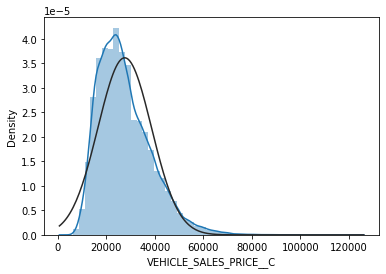

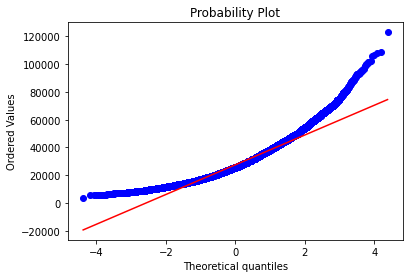

In [21]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(y,fit=norm);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

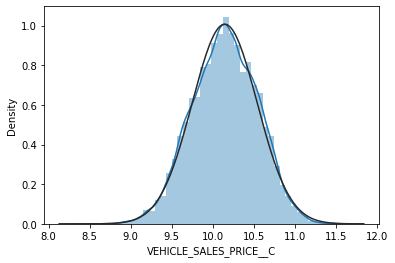

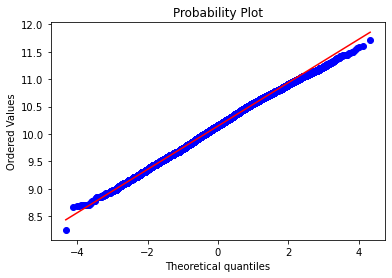

In [22]:
sns.distplot(y_train_log,fit=norm);
fig = plt.figure()
res = stats.probplot(y_train_log, plot=plt)


In [23]:
dtrain = lgb.Dataset(data=X_train, label=y_train_log)

def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
      
        params = {'application':'regression','num_iterations': 5000,
                  'learning_rate':0.05, 'early_stopping_round':50,
                  'metric':'l1'} # Default parameters
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, dtrain, nfold=5, seed=17, stratified=False, verbose_eval =None, 
                           metrics=['l1'])
        
        return -np.min(cv_result['l1-mean'])
        

In [24]:
# #Define R-squared
def lgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds), True
    
dtrain = lgb.Dataset(data=X_train, label=y_train_log)

# Objective Function
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight ):
      
        params = {'application':'regression','num_iterations': 100,
                  'learning_rate':0.05, 'early_stopping_round':50,
                  'metric':'lgb_r2_score'} # Default parameters
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=17,categorical_feature=[], stratified=False,
                            verbose_eval =None, feval=lgb_r2_score)
        # print(cv_results)
        return np.max(cv_results['r2-mean'])
        

In [25]:
# Domain space-- Range of hyperparameters
from skopt.space import Integer
pds = {'num_leaves': (8, 100),
          'feature_fraction': (0.1, 0.9),
          'bagging_fraction': (0.8, 1),
          'max_depth': (3, 10),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (30, 100)
                    }

In [26]:
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm,pds,random_state=314)
                                  
# Optimize
optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_row_wise=true` to remove the overhe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Info] Start training from score

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Info] Start training from score 10.145317
[LightGBM] [Info] Start training from score 10.145613
[LightGBM] [Info] Start training from score 10.146780
[LightGBM] [Warnin

[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Info] Start training from score 10.145317

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 10.145317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 10.145613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  13       |  0.8781   |  0.9198   |  0.3147   |  6.323    |  49.66    |  0.05843  |  69.54    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_row_wise=true` to remove t

|  16       |  0.9013   |  0.8685   |  0.9      |  9.719    |  53.99    |  0.04285  |  61.2     |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Info] Start training from score 10.145317
[LightGBM] [Info] Start training from score 10.145613
[LightGBM] [Info] Start training from score 10.146780
|  19       |  0.9011   |  0.9796   |  0.3192   |  8.789    |  52.31    |  0.08049  |  59.97    |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013940 seconds.
You can set `force_col_wise=true` to remov

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

|  28       |  0.9005   |  0.9498   |  0.6672   |  9.786    |  56.81    |  0.02408  |  57.24    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  32       |  0.892    |  0.877    |  0.4417   |  7.033    |  59.87    |  0.0185   |  54.83    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] 

[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Info] Start training from score 10.145317
[LightGBM] [Info] Start training from score 10.145613
[LightGBM] [Info] Start training from score 10.146780
|  36       |  0.8998   |  0.8781   |  0.2886   |  9.346    |  64.46    |  0.0746   |  55.77    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_row_wise=true` to remov

[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Info] Start training from score 10.145317
[LightGBM] [Info] Start training from score 10.145613
[LightGBM] [Info] Start training from score 10.146780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

|  40       |  0.8992   |  1.0      |  0.9      |  10.0     |  64.42    |  0.1      |  58.14    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

|  44       |  0.8989   |  0.8765   |  0.3049   |  9.346    |  62.46    |  0.08794  |  56.45    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Info] Start training from score 10.146289
[LightGBM] [Info] Start training from score 10.146751
[LightGBM] [Info] Start training from score 10.145317

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 73056, number of used features: 32
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number 

In [ ]:
# def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 100):
#   dtrain = lgb.Dataset(data=X, label=y)
#   def lgb_r2_score(preds, dtrain):
#       labels = dtrain.get_label()
#       return 'r2', r2_score(labels, preds), True
#   # Objective Function
#   def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain,
#                min_child_weight, learning_rate):
        
#           params = {'application':'regression','num_iterations': num_iterations,
#                     'learning_rate':0.05, 'early_stopping_round':50,
#                     'metric':'lgb_r2_score'} # Default parameters
#           params["num_leaves"] = int(round(num_leaves))
#           params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#           params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#           params['max_depth'] = int(round(max_depth))
#           params['min_split_gain'] = min_split_gain
#           params['min_child_weight'] = min_child_weight
#           params['learning_rate'] = max(min(learning_rate, 1), 0)
# #           params['min_data_in_leaf'] = int(round(min_data_in_leaf))
#           cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False,
#                               verbose_eval =False, feval=lgb_r2_score)
#           # print(cv_results)
#           return np.max(cv_results['r2-mean'])
#   # Domain space-- Range of hyperparameters 
#   pds = {'num_leaves': (80, 100),
#             'feature_fraction': (0.1, 0.9),
#             'bagging_fraction': (0.8, 1),
#             'max_depth': (17, 25),
#             'min_split_gain': (0.001, 0.1),
#             'min_child_weight': (10, 25),
#             'learning_rate': (0.0001, 0.05)
# #             'min_data_in_leaf': (100, 500)
#             }

#   # Surrogate model
#   optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
#   # Optimize
#   optimizer.maximize(init_points=init_iter, n_iter=n_iters)

# bayesion_opt_lgbm(X_train, y_train, init_iter=5, n_iters=10, random_state=77, seed = 101, num_iterations = 200)

In [50]:
optimizer.max['params'] #using all data

{'bagging_fraction': 0.8892313599962751,
 'feature_fraction': 0.7051485874131255,
 'max_depth': 12.767044958918607,
 'min_child_weight': 49.41899666360824,
 'min_split_gain': 0.09877432161176317,
 'num_leaves': 59.69353101890738}

In [41]:
optimizer.max['params'] # using training 

{'bagging_fraction': 0.8615251184610814,
 'feature_fraction': 0.8246009373866652,
 'max_depth': 8.886635536457062,
 'min_child_weight': 35.718920990961365,
 'min_split_gain': 0.06324539807231065,
 'num_leaves': 75.0096757971419}

In [26]:
optimizer.max['params'] # using log transform target variable

{'bagging_fraction': 0.9152728685504257,
 'feature_fraction': 0.9,
 'max_depth': 10.0,
 'min_child_weight': 61.40966440475863,
 'min_split_gain': 0.04561679344939494,
 'num_leaves': 83.36482478650797}

In [26]:
optimizer.max['params'] # using log transform target variable, more data cleaning

{'bagging_fraction': 1.0,
 'feature_fraction': 0.9,
 'max_depth': 10.0,
 'min_child_weight': 47.67196930892811,
 'min_split_gain': 0.1,
 'num_leaves': 88.97141914277107}

In [27]:
optimizer.max['params'] # using log transform target variable, more data cleaning, make model trim combined as of 20210916

{'bagging_fraction': 0.8244582737033339,
 'feature_fraction': 0.4088044289667119,
 'max_depth': 8.880568708703487,
 'min_child_weight': 49.47255521233224,
 'min_split_gain': 0.007921455625971248,
 'num_leaves': 66.24608747941329}

In [26]:
import lightgbm as lgb
from datetime import datetime

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.01,
    'feature_fraction': 0.4088044289667119,
    'bagging_fraction': 0.8244582737033339,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 9,
    "num_leaves": 66,  
    "max_bin": 512,
    "num_iterations": 10000,
    'min_child_weight': 49.47255521233224,
    'min_split_gain': 0.007921455625971248
}
start = datetime.now()
model_lgb = lgb.LGBMRegressor(**hyper_params)
model_lgb.fit(X_train, y_train_log,
         eval_set=[(X_test, y_test_log)],
         eval_metric='l1',
         early_stopping_rounds=1000
       )
model_elapse = datetime.now() - start
print('elapse:, ', model_elapse)


[LightGBM] [Warning] feature_fraction is set=0.4088044289667119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4088044289667119
[LightGBM] [Warning] bagging_fraction is set=0.8244582737033339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244582737033339
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4088044289667119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4088044289667119
[LightGBM] [Warning] bagging_fraction is set=0.8244582737033339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244582737033339
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [W

[139]	valid_0's l1: 0.129639	valid_0's l2: 0.0280921
[140]	valid_0's l1: 0.128953	valid_0's l2: 0.0278182
[141]	valid_0's l1: 0.12828	valid_0's l2: 0.0275499
[142]	valid_0's l1: 0.127667	valid_0's l2: 0.0273057
[143]	valid_0's l1: 0.127111	valid_0's l2: 0.0270881
[144]	valid_0's l1: 0.126583	valid_0's l2: 0.0268792
[145]	valid_0's l1: 0.125953	valid_0's l2: 0.0266324
[146]	valid_0's l1: 0.125473	valid_0's l2: 0.0264494
[147]	valid_0's l1: 0.124824	valid_0's l2: 0.0261984
[148]	valid_0's l1: 0.124222	valid_0's l2: 0.0259605
[149]	valid_0's l1: 0.12366	valid_0's l2: 0.0257474
[150]	valid_0's l1: 0.12304	valid_0's l2: 0.0255107
[151]	valid_0's l1: 0.122595	valid_0's l2: 0.0253369
[152]	valid_0's l1: 0.122019	valid_0's l2: 0.0251244
[153]	valid_0's l1: 0.121491	valid_0's l2: 0.02493
[154]	valid_0's l1: 0.120861	valid_0's l2: 0.024698
[155]	valid_0's l1: 0.120347	valid_0's l2: 0.0245018
[156]	valid_0's l1: 0.11981	valid_0's l2: 0.0243078
[157]	valid_0's l1: 0.119327	valid_0's l2: 0.0241302


[307]	valid_0's l1: 0.0781517	valid_0's l2: 0.0112563
[308]	valid_0's l1: 0.0779956	valid_0's l2: 0.0112147
[309]	valid_0's l1: 0.0778606	valid_0's l2: 0.0111776
[310]	valid_0's l1: 0.0777485	valid_0's l2: 0.011148
[311]	valid_0's l1: 0.0776302	valid_0's l2: 0.0111186
[312]	valid_0's l1: 0.0775022	valid_0's l2: 0.0110833
[313]	valid_0's l1: 0.077365	valid_0's l2: 0.0110478
[314]	valid_0's l1: 0.0772182	valid_0's l2: 0.0110087
[315]	valid_0's l1: 0.0771018	valid_0's l2: 0.0109807
[316]	valid_0's l1: 0.0770149	valid_0's l2: 0.0109559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	valid_0's l1: 0.0769329	valid_0's l2: 0.010934
[318]	valid_0's l1: 0.0767876	valid_0's l2: 0.0108951
[319]	valid_0's l1: 0.0766858	valid_0's l2: 0.0108677
[320]	valid_0's l1: 0.0765624	valid_0's l2: 0.0108361
[321]	valid_0's l1: 0.0764581	valid_0's l2: 0.0108057
[322]	valid_0's l1: 0.0763494	valid_0's l2: 0.010776
[323]	valid_0's l1: 0.0762672	valid_0's l2: 0.0107533
[324]	valid

[452]	valid_0's l1: 0.0674875	valid_0's l2: 0.00855069
[453]	valid_0's l1: 0.0674388	valid_0's l2: 0.00853952
[454]	valid_0's l1: 0.0673945	valid_0's l2: 0.00852927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's l1: 0.0673595	valid_0's l2: 0.0085193
[456]	valid_0's l1: 0.0673136	valid_0's l2: 0.00850809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's l1: 0.0672808	valid_0's l2: 0.00849958
[458]	valid_0's l1: 0.0672414	valid_0's l2: 0.00849063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's l1: 0.0672043	valid_0's l2: 0.00848192
[460]	valid_0's l1: 0.0671689	valid_0's l2: 0.00847214
[461]	valid_0's l1: 0.0671309	valid_0's l2: 0.00846401
[462]	valid_0's l1: 0.0670918	valid_0's l2: 0.00845452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[463]	valid_0's l1: 0.0670579	valid_0's l2: 0.00844692
[464]	valid_0's l1: 0.0670239	valid_0's l

[568]	valid_0's l1: 0.0639924	valid_0's l2: 0.00770656
[569]	valid_0's l1: 0.0639689	valid_0's l2: 0.0077004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's l1: 0.0639513	valid_0's l2: 0.00769518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's l1: 0.0639339	valid_0's l2: 0.00769101
[572]	valid_0's l1: 0.0639139	valid_0's l2: 0.00768601
[573]	valid_0's l1: 0.0638886	valid_0's l2: 0.00768037
[574]	valid_0's l1: 0.0638661	valid_0's l2: 0.00767474
[575]	valid_0's l1: 0.0638438	valid_0's l2: 0.00767054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's l1: 0.0638233	valid_0's l2: 0.00766522
[577]	valid_0's l1: 0.0637986	valid_0's l2: 0.00765954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's l1: 0.0637824	valid_0's l2: 0.00765544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[579]	valid_0's l1: 0

[669]	valid_0's l1: 0.0622258	valid_0's l2: 0.00728878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's l1: 0.0622115	valid_0's l2: 0.00728568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's l1: 0.0621952	valid_0's l2: 0.00728179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's l1: 0.062187	valid_0's l2: 0.00728016
[673]	valid_0's l1: 0.062172	valid_0's l2: 0.00727668
[674]	valid_0's l1: 0.0621565	valid_0's l2: 0.00727327
[675]	valid_0's l1: 0.0621369	valid_0's l2: 0.00726918
[676]	valid_0's l1: 0.0621214	valid_0's l2: 0.00726574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's l1: 0.0621097	valid_0's l2: 0.00726326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's l1: 0.0620998	valid_0's l2: 0.00726109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6

[749]	valid_0's l1: 0.0612364	valid_0's l2: 0.00706018
[750]	valid_0's l1: 0.0612282	valid_0's l2: 0.00705807
[751]	valid_0's l1: 0.0612129	valid_0's l2: 0.00705436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's l1: 0.0612053	valid_0's l2: 0.00705263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's l1: 0.0611932	valid_0's l2: 0.00704985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's l1: 0.0611826	valid_0's l2: 0.00704772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's l1: 0.0611752	valid_0's l2: 0.00704604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid_0's l1: 0.0611661	valid_0's l2: 0.00704362
[757]	valid_0's l1: 0.061147	valid_0's l2: 0.00703958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's l1: 0.0611389	valid_0's l2: 0.00703764
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[841]	valid_0's l1: 0.0603691	valid_0's l2: 0.00686114
[842]	valid_0's l1: 0.0603577	valid_0's l2: 0.00685841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[843]	valid_0's l1: 0.060353	valid_0's l2: 0.00685737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	valid_0's l1: 0.0603476	valid_0's l2: 0.00685603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	valid_0's l1: 0.0603449	valid_0's l2: 0.00685556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	valid_0's l1: 0.0603378	valid_0's l2: 0.00685397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	valid_0's l1: 0.0603318	valid_0's l2: 0.00685264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	valid_0's l1: 0.0603255	valid_0's l2: 0.0068512
[LightGBM] [Warning] No further split

[922]	valid_0's l1: 0.059811	valid_0's l2: 0.00673137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[923]	valid_0's l1: 0.059808	valid_0's l2: 0.00673077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's l1: 0.0598054	valid_0's l2: 0.00673017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's l1: 0.0598023	valid_0's l2: 0.00672963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's l1: 0.0597983	valid_0's l2: 0.00672883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's l1: 0.0597936	valid_0's l2: 0.00672798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's l1: 0.0597898	valid_0's l2: 0.0067272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's l1: 0.0597841	valid_0's l2: 0.00672605
[930]	valid_0's l1: 0.0597739	valid_0'

[1001]	valid_0's l1: 0.0593735	valid_0's l2: 0.00663215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1002]	valid_0's l1: 0.0593701	valid_0's l2: 0.00663135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1003]	valid_0's l1: 0.0593651	valid_0's l2: 0.0066302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1004]	valid_0's l1: 0.0593629	valid_0's l2: 0.00662951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1005]	valid_0's l1: 0.0593596	valid_0's l2: 0.00662867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1006]	valid_0's l1: 0.0593542	valid_0's l2: 0.00662761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1007]	valid_0's l1: 0.0593513	valid_0's l2: 0.0066269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's l1: 0.0593482	valid_0's l2: 0.00662614
[LightGBM] [Warning] No furth

[1079]	valid_0's l1: 0.0590261	valid_0's l2: 0.00655171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's l1: 0.0590236	valid_0's l2: 0.00655123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's l1: 0.0590199	valid_0's l2: 0.0065504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's l1: 0.0590186	valid_0's l2: 0.00655002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's l1: 0.0590176	valid_0's l2: 0.00654967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's l1: 0.0590157	valid_0's l2: 0.00654924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's l1: 0.0590107	valid_0's l2: 0.00654816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1086]	valid_0's l1: 0.0590095	valid_0's l2: 0.00654783
[LightGBM] [Warning] No furt

[1154]	valid_0's l1: 0.058694	valid_0's l2: 0.00647474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's l1: 0.0586885	valid_0's l2: 0.00647331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's l1: 0.0586863	valid_0's l2: 0.00647271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's l1: 0.0586825	valid_0's l2: 0.00647185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1158]	valid_0's l1: 0.0586804	valid_0's l2: 0.0064711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1159]	valid_0's l1: 0.058677	valid_0's l2: 0.00647028
[1160]	valid_0's l1: 0.0586725	valid_0's l2: 0.00646907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1161]	valid_0's l1: 0.0586665	valid_0's l2: 0.00646778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1162]	valid_0's l1: 0.0586632

[1236]	valid_0's l1: 0.0583979	valid_0's l2: 0.00640348
[1237]	valid_0's l1: 0.0583914	valid_0's l2: 0.00640166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1238]	valid_0's l1: 0.0583853	valid_0's l2: 0.00639993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1239]	valid_0's l1: 0.0583828	valid_0's l2: 0.00639919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1240]	valid_0's l1: 0.0583766	valid_0's l2: 0.00639771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1241]	valid_0's l1: 0.0583738	valid_0's l2: 0.00639706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1242]	valid_0's l1: 0.0583704	valid_0's l2: 0.00639602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1243]	valid_0's l1: 0.0583677	valid_0's l2: 0.00639514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1244]	valid_0's l1: 0.0583

[1321]	valid_0's l1: 0.058113	valid_0's l2: 0.00633132
[1322]	valid_0's l1: 0.05811	valid_0's l2: 0.00633056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's l1: 0.0581092	valid_0's l2: 0.00633027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's l1: 0.0581076	valid_0's l2: 0.00632981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's l1: 0.0581026	valid_0's l2: 0.00632889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's l1: 0.0581019	valid_0's l2: 0.00632867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1327]	valid_0's l1: 0.0580978	valid_0's l2: 0.00632787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's l1: 0.0580962	valid_0's l2: 0.0063275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1329]	valid_0's l1: 0.0580952	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's l1: 0.057935	valid_0's l2: 0.00628381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's l1: 0.0579323	valid_0's l2: 0.00628323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1396]	valid_0's l1: 0.0579289	valid_0's l2: 0.0062823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1397]	valid_0's l1: 0.0579268	valid_0's l2: 0.00628132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1398]	valid_0's l1: 0.0579255	valid_0's l2: 0.00628104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1399]	valid_0's l1: 0.0579222	valid_0's l2: 0.00627998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1400]	valid_0's l1: 0.0579195	valid_0's l2: 0.00627928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1401]	val

[1466]	valid_0's l1: 0.0577497	valid_0's l2: 0.00623596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1467]	valid_0's l1: 0.0577472	valid_0's l2: 0.00623538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1468]	valid_0's l1: 0.0577462	valid_0's l2: 0.00623519
[1469]	valid_0's l1: 0.0577426	valid_0's l2: 0.00623441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1470]	valid_0's l1: 0.0577401	valid_0's l2: 0.00623373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's l1: 0.0577379	valid_0's l2: 0.00623324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's l1: 0.0577357	valid_0's l2: 0.0062322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's l1: 0.0577322	valid_0's l2: 0.00623158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's l1: 0.05773

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's l1: 0.0575626	valid_0's l2: 0.0061875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1553]	valid_0's l1: 0.0575613	valid_0's l2: 0.00618721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1554]	valid_0's l1: 0.0575595	valid_0's l2: 0.00618687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1555]	valid_0's l1: 0.0575584	valid_0's l2: 0.00618666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1556]	valid_0's l1: 0.057558	valid_0's l2: 0.00618657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1557]	valid_0's l1: 0.0575557	valid_0's l2: 0.00618622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1558]	valid_0's l1: 0.0575544	valid_0's l2: 0.00618602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1559]	val

[1626]	valid_0's l1: 0.057415	valid_0's l2: 0.00615135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1627]	valid_0's l1: 0.0574149	valid_0's l2: 0.00615136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1628]	valid_0's l1: 0.0574141	valid_0's l2: 0.00615115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1629]	valid_0's l1: 0.0574131	valid_0's l2: 0.00615078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1630]	valid_0's l1: 0.0574126	valid_0's l2: 0.0061506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1631]	valid_0's l1: 0.0574116	valid_0's l2: 0.00615043
[1632]	valid_0's l1: 0.057406	valid_0's l2: 0.00614936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1633]	valid_0's l1: 0.0574047	valid_0's l2: 0.00614908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1634]	valid_0's l1: 0.0574041

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1696]	valid_0's l1: 0.0572946	valid_0's l2: 0.00612279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1697]	valid_0's l1: 0.0572929	valid_0's l2: 0.00612247
[1698]	valid_0's l1: 0.0572876	valid_0's l2: 0.00612122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1699]	valid_0's l1: 0.0572872	valid_0's l2: 0.00612105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1700]	valid_0's l1: 0.0572862	valid_0's l2: 0.00612085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1701]	valid_0's l1: 0.0572842	valid_0's l2: 0.00612012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1702]	valid_0's l1: 0.0572824	valid_0's l2: 0.00611948
[1703]	valid_0's l1: 0.0572798	valid_0's l2: 0.00611876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1704]	valid_0's l1: 0.0572

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1778]	valid_0's l1: 0.0571715	valid_0's l2: 0.00608991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1779]	valid_0's l1: 0.0571714	valid_0's l2: 0.00608965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1780]	valid_0's l1: 0.0571711	valid_0's l2: 0.00608952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1781]	valid_0's l1: 0.0571706	valid_0's l2: 0.00608937
[1782]	valid_0's l1: 0.0571679	valid_0's l2: 0.00608846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1783]	valid_0's l1: 0.0571673	valid_0's l2: 0.00608807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1784]	valid_0's l1: 0.0571647	valid_0's l2: 0.00608704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1785]	valid_0's l1: 0.0571633	valid_0's l2: 0.00608666
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1863]	valid_0's l1: 0.057046	valid_0's l2: 0.00605731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1864]	valid_0's l1: 0.057045	valid_0's l2: 0.00605709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1865]	valid_0's l1: 0.057044	valid_0's l2: 0.00605689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1866]	valid_0's l1: 0.0570406	valid_0's l2: 0.00605631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1867]	valid_0's l1: 0.0570394	valid_0's l2: 0.00605608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1868]	valid_0's l1: 0.0570364	valid_0's l2: 0.0060551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1869]	valid_0's l1: 0.0570347	valid_0's l2: 0.00605478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1870]	valid

[1940]	valid_0's l1: 0.0569503	valid_0's l2: 0.00603246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's l1: 0.0569496	valid_0's l2: 0.00603226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1942]	valid_0's l1: 0.0569479	valid_0's l2: 0.00603168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1943]	valid_0's l1: 0.0569447	valid_0's l2: 0.00603071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1944]	valid_0's l1: 0.0569432	valid_0's l2: 0.00603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1945]	valid_0's l1: 0.0569426	valid_0's l2: 0.00602984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1946]	valid_0's l1: 0.0569411	valid_0's l2: 0.00602919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1947]	valid_0's l1: 0.05694	valid_0's l2: 0.00602896
[LightGBM] [Warning] No further 

[2023]	valid_0's l1: 0.056857	valid_0's l2: 0.00600449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2024]	valid_0's l1: 0.0568564	valid_0's l2: 0.0060044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2025]	valid_0's l1: 0.0568547	valid_0's l2: 0.00600382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2026]	valid_0's l1: 0.0568526	valid_0's l2: 0.00600324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2027]	valid_0's l1: 0.0568521	valid_0's l2: 0.00600317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2028]	valid_0's l1: 0.0568516	valid_0's l2: 0.00600296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2029]	valid_0's l1: 0.0568516	valid_0's l2: 0.00600268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2030]	valid_0's l1: 0.0568513	valid_0's l2: 0.00600254
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2109]	valid_0's l1: 0.056769	valid_0's l2: 0.00598153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2110]	valid_0's l1: 0.0567681	valid_0's l2: 0.00598137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2111]	valid_0's l1: 0.0567675	valid_0's l2: 0.00598109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2112]	valid_0's l1: 0.056767	valid_0's l2: 0.00598103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2113]	valid_0's l1: 0.0567659	valid_0's l2: 0.00598073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2114]	valid_0's l1: 0.0567653	valid_0's l2: 0.00598061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2115]	valid_0's l1: 0.056765	valid_0's l2: 0.00598052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2116]	vali

[2195]	valid_0's l1: 0.0566815	valid_0's l2: 0.00595835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2196]	valid_0's l1: 0.0566801	valid_0's l2: 0.00595792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2197]	valid_0's l1: 0.0566792	valid_0's l2: 0.00595772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2198]	valid_0's l1: 0.0566785	valid_0's l2: 0.00595759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2199]	valid_0's l1: 0.0566776	valid_0's l2: 0.0059573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2200]	valid_0's l1: 0.0566775	valid_0's l2: 0.0059573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2201]	valid_0's l1: 0.0566776	valid_0's l2: 0.00595726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2202]	valid_0's l1: 0.0566768	valid_0's l2: 0.00595713
[LightGBM] [Warning] No furth

[2275]	valid_0's l1: 0.0566176	valid_0's l2: 0.00594101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2276]	valid_0's l1: 0.0566181	valid_0's l2: 0.00594105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2277]	valid_0's l1: 0.0566173	valid_0's l2: 0.00594086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2278]	valid_0's l1: 0.0566169	valid_0's l2: 0.00594079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2279]	valid_0's l1: 0.0566171	valid_0's l2: 0.0059408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2280]	valid_0's l1: 0.0566162	valid_0's l2: 0.0059406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2281]	valid_0's l1: 0.0566151	valid_0's l2: 0.00594035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2282]	valid_0's l1: 0.0566129	valid_0's l2: 0.00593991
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2356]	valid_0's l1: 0.0565459	valid_0's l2: 0.00592286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2357]	valid_0's l1: 0.0565439	valid_0's l2: 0.00592218
[2358]	valid_0's l1: 0.0565399	valid_0's l2: 0.00592146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2359]	valid_0's l1: 0.0565392	valid_0's l2: 0.00592139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2360]	valid_0's l1: 0.0565383	valid_0's l2: 0.00592117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2361]	valid_0's l1: 0.0565372	valid_0's l2: 0.00592082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2362]	valid_0's l1: 0.0565375	valid_0's l2: 0.00592085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2363]	valid_0's l1: 0.0565377	valid_0's l2: 0.00592087
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2440]	valid_0's l1: 0.0564845	valid_0's l2: 0.0059048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2441]	valid_0's l1: 0.0564833	valid_0's l2: 0.00590456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2442]	valid_0's l1: 0.0564826	valid_0's l2: 0.00590433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2443]	valid_0's l1: 0.0564818	valid_0's l2: 0.00590412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2444]	valid_0's l1: 0.056481	valid_0's l2: 0.00590397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2445]	valid_0's l1: 0.0564803	valid_0's l2: 0.00590377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2446]	valid_0's l1: 0.0564801	valid_0's l2: 0.00590365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2447]	val

[2520]	valid_0's l1: 0.0564169	valid_0's l2: 0.00588619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2521]	valid_0's l1: 0.0564159	valid_0's l2: 0.00588598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2522]	valid_0's l1: 0.0564152	valid_0's l2: 0.00588582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2523]	valid_0's l1: 0.0564145	valid_0's l2: 0.00588567
[2524]	valid_0's l1: 0.056412	valid_0's l2: 0.00588494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2525]	valid_0's l1: 0.0564104	valid_0's l2: 0.00588466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2526]	valid_0's l1: 0.0564095	valid_0's l2: 0.0058845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2527]	valid_0's l1: 0.0564088	valid_0's l2: 0.00588437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2528]	valid_0's l1: 0.056407

[2590]	valid_0's l1: 0.056351	valid_0's l2: 0.00586908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2591]	valid_0's l1: 0.0563506	valid_0's l2: 0.005869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2592]	valid_0's l1: 0.0563494	valid_0's l2: 0.00586887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2593]	valid_0's l1: 0.0563483	valid_0's l2: 0.00586841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2594]	valid_0's l1: 0.0563474	valid_0's l2: 0.00586803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2595]	valid_0's l1: 0.0563465	valid_0's l2: 0.00586791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2596]	valid_0's l1: 0.0563459	valid_0's l2: 0.00586779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2597]	valid_0's l1: 0.0563444	valid_0's l2: 0.00586716
[LightGBM] [Warning] No furthe

[2675]	valid_0's l1: 0.0562886	valid_0's l2: 0.00585273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2676]	valid_0's l1: 0.0562872	valid_0's l2: 0.00585197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2677]	valid_0's l1: 0.0562872	valid_0's l2: 0.0058519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2678]	valid_0's l1: 0.0562872	valid_0's l2: 0.00585178
[2679]	valid_0's l1: 0.0562837	valid_0's l2: 0.00585031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2680]	valid_0's l1: 0.0562835	valid_0's l2: 0.0058502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2681]	valid_0's l1: 0.0562815	valid_0's l2: 0.00584962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2682]	valid_0's l1: 0.0562804	valid_0's l2: 0.00584947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2683]	valid_0's l1: 0.056280

[2747]	valid_0's l1: 0.0562384	valid_0's l2: 0.00583784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2748]	valid_0's l1: 0.0562381	valid_0's l2: 0.00583778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2749]	valid_0's l1: 0.0562377	valid_0's l2: 0.00583755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2750]	valid_0's l1: 0.0562367	valid_0's l2: 0.00583729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2751]	valid_0's l1: 0.0562363	valid_0's l2: 0.00583711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2752]	valid_0's l1: 0.0562359	valid_0's l2: 0.00583693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2753]	valid_0's l1: 0.0562353	valid_0's l2: 0.00583672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2754]	valid_0's l1: 0.0562355	valid_0's l2: 0.00583649
[2755]	valid_0's l1: 0.0562

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2828]	valid_0's l1: 0.0561867	valid_0's l2: 0.00582441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2829]	valid_0's l1: 0.056185	valid_0's l2: 0.00582381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2830]	valid_0's l1: 0.0561848	valid_0's l2: 0.00582376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2831]	valid_0's l1: 0.0561841	valid_0's l2: 0.00582348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2832]	valid_0's l1: 0.0561819	valid_0's l2: 0.00582291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2833]	valid_0's l1: 0.0561807	valid_0's l2: 0.00582275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2834]	valid_0's l1: 0.0561799	valid_0's l2: 0.00582261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2835]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2899]	valid_0's l1: 0.0561308	valid_0's l2: 0.00580977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2900]	valid_0's l1: 0.0561292	valid_0's l2: 0.00580934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2901]	valid_0's l1: 0.0561292	valid_0's l2: 0.00580933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2902]	valid_0's l1: 0.0561282	valid_0's l2: 0.00580902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2903]	valid_0's l1: 0.0561268	valid_0's l2: 0.00580881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2904]	valid_0's l1: 0.0561264	valid_0's l2: 0.00580878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2905]	valid_0's l1: 0.0561258	valid_0's l2: 0.00580871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2906]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2978]	valid_0's l1: 0.0560797	valid_0's l2: 0.00579611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2979]	valid_0's l1: 0.0560795	valid_0's l2: 0.00579606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2980]	valid_0's l1: 0.0560785	valid_0's l2: 0.00579584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2981]	valid_0's l1: 0.0560775	valid_0's l2: 0.00579557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2982]	valid_0's l1: 0.056077	valid_0's l2: 0.0057954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2983]	valid_0's l1: 0.0560769	valid_0's l2: 0.00579534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2984]	valid_0's l1: 0.0560768	valid_0's l2: 0.0057953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2985]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3054]	valid_0's l1: 0.0560365	valid_0's l2: 0.00578446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3055]	valid_0's l1: 0.0560361	valid_0's l2: 0.00578428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3056]	valid_0's l1: 0.0560355	valid_0's l2: 0.00578404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3057]	valid_0's l1: 0.0560356	valid_0's l2: 0.00578403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3058]	valid_0's l1: 0.0560352	valid_0's l2: 0.00578394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3059]	valid_0's l1: 0.0560344	valid_0's l2: 0.00578361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3060]	valid_0's l1: 0.0560338	valid_0's l2: 0.00578338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3061]	v

[3132]	valid_0's l1: 0.0559886	valid_0's l2: 0.00577156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3133]	valid_0's l1: 0.0559885	valid_0's l2: 0.00577151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3134]	valid_0's l1: 0.0559881	valid_0's l2: 0.00577118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3135]	valid_0's l1: 0.0559881	valid_0's l2: 0.00577119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3136]	valid_0's l1: 0.0559877	valid_0's l2: 0.00577109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3137]	valid_0's l1: 0.0559877	valid_0's l2: 0.00577107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3138]	valid_0's l1: 0.0559869	valid_0's l2: 0.0057709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3139]	valid_0's l1: 0.0559866	valid_0's l2: 0.0057708
[LightGBM] [Warning] No furth

[3213]	valid_0's l1: 0.0559499	valid_0's l2: 0.00576057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3214]	valid_0's l1: 0.0559497	valid_0's l2: 0.00576051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3215]	valid_0's l1: 0.0559498	valid_0's l2: 0.00576052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3216]	valid_0's l1: 0.0559499	valid_0's l2: 0.00576049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3217]	valid_0's l1: 0.0559498	valid_0's l2: 0.00576045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3218]	valid_0's l1: 0.0559495	valid_0's l2: 0.00576037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3219]	valid_0's l1: 0.0559496	valid_0's l2: 0.00576038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3220]	valid_0's l1: 0.0559493	valid_0's l2: 0.00576033
[LightGBM] [Warning] No fur

[3279]	valid_0's l1: 0.0559187	valid_0's l2: 0.00575304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3280]	valid_0's l1: 0.0559184	valid_0's l2: 0.00575296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3281]	valid_0's l1: 0.0559183	valid_0's l2: 0.00575294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3282]	valid_0's l1: 0.0559182	valid_0's l2: 0.00575281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3283]	valid_0's l1: 0.0559178	valid_0's l2: 0.00575258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3284]	valid_0's l1: 0.0559177	valid_0's l2: 0.00575246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3285]	valid_0's l1: 0.0559171	valid_0's l2: 0.0057523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3286]	valid_0's l1: 0.055917	valid_0's l2: 0.00575223
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3358]	valid_0's l1: 0.0558821	valid_0's l2: 0.00574248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3359]	valid_0's l1: 0.0558824	valid_0's l2: 0.00574259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3360]	valid_0's l1: 0.0558815	valid_0's l2: 0.00574241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3361]	valid_0's l1: 0.0558816	valid_0's l2: 0.00574239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3362]	valid_0's l1: 0.0558809	valid_0's l2: 0.00574224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3363]	valid_0's l1: 0.0558808	valid_0's l2: 0.00574223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3364]	valid_0's l1: 0.0558794	valid_0's l2: 0.00574196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3365]	v

[3439]	valid_0's l1: 0.0558365	valid_0's l2: 0.00573125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3440]	valid_0's l1: 0.0558362	valid_0's l2: 0.00573121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3441]	valid_0's l1: 0.0558357	valid_0's l2: 0.00573114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3442]	valid_0's l1: 0.055835	valid_0's l2: 0.00573098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3443]	valid_0's l1: 0.055835	valid_0's l2: 0.00573096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3444]	valid_0's l1: 0.0558348	valid_0's l2: 0.00573094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3445]	valid_0's l1: 0.0558346	valid_0's l2: 0.00573095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3446]	valid_0's l1: 0.055834	valid_0's l2: 0.00573092
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3524]	valid_0's l1: 0.0558052	valid_0's l2: 0.00572307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3525]	valid_0's l1: 0.0558051	valid_0's l2: 0.00572304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3526]	valid_0's l1: 0.0558053	valid_0's l2: 0.00572313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3527]	valid_0's l1: 0.0558046	valid_0's l2: 0.00572302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3528]	valid_0's l1: 0.055804	valid_0's l2: 0.00572276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3529]	valid_0's l1: 0.0558037	valid_0's l2: 0.00572271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3530]	valid_0's l1: 0.055803	valid_0's l2: 0.00572251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3531]	val

[3593]	valid_0's l1: 0.0557702	valid_0's l2: 0.00571429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3594]	valid_0's l1: 0.0557699	valid_0's l2: 0.00571426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3595]	valid_0's l1: 0.0557688	valid_0's l2: 0.00571389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3596]	valid_0's l1: 0.055769	valid_0's l2: 0.00571394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3597]	valid_0's l1: 0.0557685	valid_0's l2: 0.00571382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3598]	valid_0's l1: 0.0557681	valid_0's l2: 0.00571375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3599]	valid_0's l1: 0.0557681	valid_0's l2: 0.00571372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3600]	valid_0's l1: 0.0557683	valid_0's l2: 0.00571374
[LightGBM] [Warning] No furt

[3662]	valid_0's l1: 0.0557435	valid_0's l2: 0.00570546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3663]	valid_0's l1: 0.055742	valid_0's l2: 0.00570493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3664]	valid_0's l1: 0.0557418	valid_0's l2: 0.0057049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3665]	valid_0's l1: 0.0557412	valid_0's l2: 0.00570474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3666]	valid_0's l1: 0.0557408	valid_0's l2: 0.00570463
[3667]	valid_0's l1: 0.0557391	valid_0's l2: 0.00570424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3668]	valid_0's l1: 0.0557395	valid_0's l2: 0.00570428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3669]	valid_0's l1: 0.0557392	valid_0's l2: 0.00570423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3670]	valid_0's l1: 0.055738

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3731]	valid_0's l1: 0.0557216	valid_0's l2: 0.00569902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3732]	valid_0's l1: 0.0557211	valid_0's l2: 0.00569898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3733]	valid_0's l1: 0.0557209	valid_0's l2: 0.00569899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3734]	valid_0's l1: 0.0557206	valid_0's l2: 0.00569889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3735]	valid_0's l1: 0.0557204	valid_0's l2: 0.00569885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3736]	valid_0's l1: 0.0557201	valid_0's l2: 0.0056988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3737]	valid_0's l1: 0.0557201	valid_0's l2: 0.00569877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3738]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3805]	valid_0's l1: 0.0556975	valid_0's l2: 0.00569249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3806]	valid_0's l1: 0.0556971	valid_0's l2: 0.00569242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3807]	valid_0's l1: 0.0556965	valid_0's l2: 0.00569235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3808]	valid_0's l1: 0.0556964	valid_0's l2: 0.0056923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3809]	valid_0's l1: 0.0556959	valid_0's l2: 0.00569225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3810]	valid_0's l1: 0.0556959	valid_0's l2: 0.00569222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3811]	valid_0's l1: 0.0556956	valid_0's l2: 0.00569216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3812]	va

[3870]	valid_0's l1: 0.0556646	valid_0's l2: 0.00568432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3871]	valid_0's l1: 0.0556642	valid_0's l2: 0.00568422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3872]	valid_0's l1: 0.0556636	valid_0's l2: 0.00568413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3873]	valid_0's l1: 0.0556637	valid_0's l2: 0.00568414
[3874]	valid_0's l1: 0.0556617	valid_0's l2: 0.00568381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3875]	valid_0's l1: 0.0556617	valid_0's l2: 0.00568375
[3876]	valid_0's l1: 0.0556612	valid_0's l2: 0.00568359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3877]	valid_0's l1: 0.0556613	valid_0's l2: 0.00568357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3878]	valid_0's l1: 0.0556605	valid_0's l2: 0.00568335
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3941]	valid_0's l1: 0.0556438	valid_0's l2: 0.00567838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3942]	valid_0's l1: 0.0556431	valid_0's l2: 0.00567827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3943]	valid_0's l1: 0.0556428	valid_0's l2: 0.00567822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3944]	valid_0's l1: 0.0556428	valid_0's l2: 0.00567819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3945]	valid_0's l1: 0.0556425	valid_0's l2: 0.00567813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3946]	valid_0's l1: 0.055642	valid_0's l2: 0.00567803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3947]	valid_0's l1: 0.0556414	valid_0's l2: 0.00567784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3948]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4015]	valid_0's l1: 0.0556213	valid_0's l2: 0.00567169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4016]	valid_0's l1: 0.0556212	valid_0's l2: 0.00567166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4017]	valid_0's l1: 0.055621	valid_0's l2: 0.0056716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4018]	valid_0's l1: 0.05562	valid_0's l2: 0.00567147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4019]	valid_0's l1: 0.0556194	valid_0's l2: 0.00567133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4020]	valid_0's l1: 0.0556186	valid_0's l2: 0.00567111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4021]	valid_0's l1: 0.0556178	valid_0's l2: 0.00567099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4022]	valid

[4086]	valid_0's l1: 0.0555909	valid_0's l2: 0.00566392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4087]	valid_0's l1: 0.0555903	valid_0's l2: 0.00566375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4088]	valid_0's l1: 0.0555896	valid_0's l2: 0.0056636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4089]	valid_0's l1: 0.0555892	valid_0's l2: 0.00566338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4090]	valid_0's l1: 0.0555889	valid_0's l2: 0.00566329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4091]	valid_0's l1: 0.0555884	valid_0's l2: 0.00566322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4092]	valid_0's l1: 0.0555878	valid_0's l2: 0.00566314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4093]	valid_0's l1: 0.055587	valid_0's l2: 0.00566297
[LightGBM] [Warning] No furth

[4161]	valid_0's l1: 0.0555598	valid_0's l2: 0.00565496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4162]	valid_0's l1: 0.0555586	valid_0's l2: 0.00565462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4163]	valid_0's l1: 0.0555579	valid_0's l2: 0.0056544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4164]	valid_0's l1: 0.055558	valid_0's l2: 0.00565441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4165]	valid_0's l1: 0.0555582	valid_0's l2: 0.00565438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4166]	valid_0's l1: 0.0555589	valid_0's l2: 0.00565447
[4167]	valid_0's l1: 0.0555582	valid_0's l2: 0.00565414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4168]	valid_0's l1: 0.0555584	valid_0's l2: 0.00565414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4169]	valid_0's l1: 0.055558

[4237]	valid_0's l1: 0.0555308	valid_0's l2: 0.00564776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4238]	valid_0's l1: 0.0555302	valid_0's l2: 0.00564767
[4239]	valid_0's l1: 0.0555287	valid_0's l2: 0.00564713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4240]	valid_0's l1: 0.0555289	valid_0's l2: 0.00564709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4241]	valid_0's l1: 0.0555288	valid_0's l2: 0.00564706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4242]	valid_0's l1: 0.0555282	valid_0's l2: 0.00564696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4243]	valid_0's l1: 0.0555278	valid_0's l2: 0.00564689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4244]	valid_0's l1: 0.0555275	valid_0's l2: 0.00564683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4245]	valid_0's l1: 0.0555

[4311]	valid_0's l1: 0.0555178	valid_0's l2: 0.00564284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4312]	valid_0's l1: 0.0555179	valid_0's l2: 0.00564287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4313]	valid_0's l1: 0.0555174	valid_0's l2: 0.00564281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4314]	valid_0's l1: 0.0555171	valid_0's l2: 0.00564277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4315]	valid_0's l1: 0.0555168	valid_0's l2: 0.00564273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4316]	valid_0's l1: 0.0555167	valid_0's l2: 0.00564265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4317]	valid_0's l1: 0.0555169	valid_0's l2: 0.00564269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4318]	valid_0's l1: 0.0555165	valid_0's l2: 0.00564266
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4386]	valid_0's l1: 0.0554923	valid_0's l2: 0.00563654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4387]	valid_0's l1: 0.0554922	valid_0's l2: 0.00563649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4388]	valid_0's l1: 0.055492	valid_0's l2: 0.00563644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4389]	valid_0's l1: 0.0554917	valid_0's l2: 0.00563634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4390]	valid_0's l1: 0.055492	valid_0's l2: 0.00563637
[4391]	valid_0's l1: 0.0554911	valid_0's l2: 0.00563614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4392]	valid_0's l1: 0.0554911	valid_0's l2: 0.00563609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4393]	valid_0's l1: 0.0554904	valid_0's l2: 0.00563597
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4460]	valid_0's l1: 0.0554717	valid_0's l2: 0.00563061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4461]	valid_0's l1: 0.0554713	valid_0's l2: 0.00563054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4462]	valid_0's l1: 0.055471	valid_0's l2: 0.00563055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4463]	valid_0's l1: 0.0554706	valid_0's l2: 0.00563044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4464]	valid_0's l1: 0.0554692	valid_0's l2: 0.00563016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4465]	valid_0's l1: 0.055469	valid_0's l2: 0.00563017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4466]	valid_0's l1: 0.0554689	valid_0's l2: 0.00563015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4467]	val

[4531]	valid_0's l1: 0.0554496	valid_0's l2: 0.00562388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4532]	valid_0's l1: 0.055449	valid_0's l2: 0.00562368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4533]	valid_0's l1: 0.0554493	valid_0's l2: 0.00562363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4534]	valid_0's l1: 0.0554495	valid_0's l2: 0.00562364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4535]	valid_0's l1: 0.0554494	valid_0's l2: 0.00562359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4536]	valid_0's l1: 0.0554496	valid_0's l2: 0.00562362
[4537]	valid_0's l1: 0.055448	valid_0's l2: 0.00562321
[4538]	valid_0's l1: 0.0554461	valid_0's l2: 0.00562282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4539]	valid_0's l1: 0.0554459	valid_0's l2: 0.00562275
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4611]	valid_0's l1: 0.0554262	valid_0's l2: 0.00561658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4612]	valid_0's l1: 0.0554263	valid_0's l2: 0.00561657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4613]	valid_0's l1: 0.0554257	valid_0's l2: 0.00561648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4614]	valid_0's l1: 0.0554253	valid_0's l2: 0.00561631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4615]	valid_0's l1: 0.0554248	valid_0's l2: 0.00561623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4616]	valid_0's l1: 0.0554249	valid_0's l2: 0.0056162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4617]	valid_0's l1: 0.0554251	valid_0's l2: 0.00561616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4618]	va

[4689]	valid_0's l1: 0.0554084	valid_0's l2: 0.00561164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4690]	valid_0's l1: 0.055408	valid_0's l2: 0.0056116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4691]	valid_0's l1: 0.0554079	valid_0's l2: 0.00561161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4692]	valid_0's l1: 0.0554081	valid_0's l2: 0.00561155
[4693]	valid_0's l1: 0.0554058	valid_0's l2: 0.00561107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4694]	valid_0's l1: 0.0554054	valid_0's l2: 0.00561102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4695]	valid_0's l1: 0.0554057	valid_0's l2: 0.00561106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4696]	valid_0's l1: 0.0554056	valid_0's l2: 0.00561102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4697]	valid_0's l1: 0.055405

[4757]	valid_0's l1: 0.0553812	valid_0's l2: 0.00560433
[4758]	valid_0's l1: 0.0553799	valid_0's l2: 0.00560396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4759]	valid_0's l1: 0.0553795	valid_0's l2: 0.00560389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4760]	valid_0's l1: 0.0553793	valid_0's l2: 0.00560388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4761]	valid_0's l1: 0.0553786	valid_0's l2: 0.00560372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4762]	valid_0's l1: 0.0553784	valid_0's l2: 0.00560366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4763]	valid_0's l1: 0.0553784	valid_0's l2: 0.00560367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4764]	valid_0's l1: 0.0553785	valid_0's l2: 0.00560364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4765]	valid_0's l1: 0.0553

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4840]	valid_0's l1: 0.0553655	valid_0's l2: 0.0055984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4841]	valid_0's l1: 0.0553648	valid_0's l2: 0.00559828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4842]	valid_0's l1: 0.0553641	valid_0's l2: 0.00559821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4843]	valid_0's l1: 0.0553632	valid_0's l2: 0.00559813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4844]	valid_0's l1: 0.0553625	valid_0's l2: 0.00559806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4845]	valid_0's l1: 0.0553618	valid_0's l2: 0.00559799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4846]	valid_0's l1: 0.0553614	valid_0's l2: 0.00559793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4847]	va

[4915]	valid_0's l1: 0.0553515	valid_0's l2: 0.00559352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4916]	valid_0's l1: 0.0553516	valid_0's l2: 0.00559352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4917]	valid_0's l1: 0.0553519	valid_0's l2: 0.00559354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4918]	valid_0's l1: 0.0553511	valid_0's l2: 0.00559341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4919]	valid_0's l1: 0.0553508	valid_0's l2: 0.00559338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4920]	valid_0's l1: 0.0553508	valid_0's l2: 0.00559334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4921]	valid_0's l1: 0.0553506	valid_0's l2: 0.0055933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4922]	valid_0's l1: 0.0553502	valid_0's l2: 0.00559306
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4985]	valid_0's l1: 0.0553409	valid_0's l2: 0.00559052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4986]	valid_0's l1: 0.0553412	valid_0's l2: 0.00559059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4987]	valid_0's l1: 0.0553411	valid_0's l2: 0.00559055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4988]	valid_0's l1: 0.0553413	valid_0's l2: 0.00559061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4989]	valid_0's l1: 0.0553416	valid_0's l2: 0.00559067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4990]	valid_0's l1: 0.0553418	valid_0's l2: 0.00559071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4991]	valid_0's l1: 0.0553415	valid_0's l2: 0.00559052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4992]	v

[5052]	valid_0's l1: 0.055332	valid_0's l2: 0.00558691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5053]	valid_0's l1: 0.0553322	valid_0's l2: 0.00558688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5054]	valid_0's l1: 0.0553321	valid_0's l2: 0.00558677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5055]	valid_0's l1: 0.0553316	valid_0's l2: 0.00558653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5056]	valid_0's l1: 0.0553317	valid_0's l2: 0.00558655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5057]	valid_0's l1: 0.0553315	valid_0's l2: 0.0055865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5058]	valid_0's l1: 0.0553311	valid_0's l2: 0.00558642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5059]	valid_0's l1: 0.0553309	valid_0's l2: 0.00558636
[LightGBM] [Warning] No furth

[5127]	valid_0's l1: 0.0553035	valid_0's l2: 0.00557939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5128]	valid_0's l1: 0.0553032	valid_0's l2: 0.0055793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5129]	valid_0's l1: 0.0553021	valid_0's l2: 0.00557905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5130]	valid_0's l1: 0.055302	valid_0's l2: 0.00557901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5131]	valid_0's l1: 0.055302	valid_0's l2: 0.00557903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5132]	valid_0's l1: 0.055302	valid_0's l2: 0.00557901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5133]	valid_0's l1: 0.0553018	valid_0's l2: 0.00557892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5134]	valid_0's l1: 0.055301	valid_0's l2: 0.00557861
[LightGBM] [Warning] No further 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5192]	valid_0's l1: 0.0552891	valid_0's l2: 0.00557568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5193]	valid_0's l1: 0.0552892	valid_0's l2: 0.00557566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5194]	valid_0's l1: 0.0552893	valid_0's l2: 0.0055757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5195]	valid_0's l1: 0.0552893	valid_0's l2: 0.00557565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5196]	valid_0's l1: 0.0552892	valid_0's l2: 0.00557567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5197]	valid_0's l1: 0.0552884	valid_0's l2: 0.00557551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5198]	valid_0's l1: 0.0552881	valid_0's l2: 0.00557546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5199]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5266]	valid_0's l1: 0.0552789	valid_0's l2: 0.00557327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5267]	valid_0's l1: 0.0552788	valid_0's l2: 0.00557327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5268]	valid_0's l1: 0.0552781	valid_0's l2: 0.00557317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5269]	valid_0's l1: 0.0552774	valid_0's l2: 0.005573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5270]	valid_0's l1: 0.0552774	valid_0's l2: 0.00557301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5271]	valid_0's l1: 0.0552772	valid_0's l2: 0.00557298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5272]	valid_0's l1: 0.0552762	valid_0's l2: 0.00557263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5273]	val

[5345]	valid_0's l1: 0.0552595	valid_0's l2: 0.00556864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5346]	valid_0's l1: 0.0552595	valid_0's l2: 0.00556865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5347]	valid_0's l1: 0.0552596	valid_0's l2: 0.00556865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5348]	valid_0's l1: 0.0552594	valid_0's l2: 0.00556867
[5349]	valid_0's l1: 0.0552577	valid_0's l2: 0.00556826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5350]	valid_0's l1: 0.0552577	valid_0's l2: 0.00556832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5351]	valid_0's l1: 0.0552576	valid_0's l2: 0.00556826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5352]	valid_0's l1: 0.0552576	valid_0's l2: 0.00556823
[5353]	valid_0's l1: 0.0552558	valid_0's l2: 0.00556786
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5419]	valid_0's l1: 0.0552564	valid_0's l2: 0.00556582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5420]	valid_0's l1: 0.0552565	valid_0's l2: 0.00556577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5421]	valid_0's l1: 0.055256	valid_0's l2: 0.00556557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5422]	valid_0's l1: 0.0552557	valid_0's l2: 0.00556553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5423]	valid_0's l1: 0.0552553	valid_0's l2: 0.00556549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5424]	valid_0's l1: 0.0552547	valid_0's l2: 0.00556543
[5425]	valid_0's l1: 0.0552534	valid_0's l2: 0.00556497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5426]	valid_0's l1: 0.0552533	valid_0's l2: 0.00556485
[LightGBM] [Warning] No furt

[5490]	valid_0's l1: 0.0552308	valid_0's l2: 0.00555941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5491]	valid_0's l1: 0.0552309	valid_0's l2: 0.00555941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5492]	valid_0's l1: 0.0552308	valid_0's l2: 0.00555938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5493]	valid_0's l1: 0.055231	valid_0's l2: 0.00555938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5494]	valid_0's l1: 0.055231	valid_0's l2: 0.00555939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5495]	valid_0's l1: 0.0552309	valid_0's l2: 0.00555938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5496]	valid_0's l1: 0.055231	valid_0's l2: 0.0055594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5497]	valid_0's l1: 0.0552312	valid_0's l2: 0.00555939
[LightGBM] [Warning] No further

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5565]	valid_0's l1: 0.0552235	valid_0's l2: 0.00555652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5566]	valid_0's l1: 0.0552239	valid_0's l2: 0.00555656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5567]	valid_0's l1: 0.0552241	valid_0's l2: 0.00555658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5568]	valid_0's l1: 0.0552241	valid_0's l2: 0.00555656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5569]	valid_0's l1: 0.0552244	valid_0's l2: 0.00555659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5570]	valid_0's l1: 0.055224	valid_0's l2: 0.00555652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5571]	valid_0's l1: 0.0552238	valid_0's l2: 0.00555651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5572]	va

[5637]	valid_0's l1: 0.0552064	valid_0's l2: 0.00555219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5638]	valid_0's l1: 0.0552064	valid_0's l2: 0.00555217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5639]	valid_0's l1: 0.0552062	valid_0's l2: 0.00555215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5640]	valid_0's l1: 0.055206	valid_0's l2: 0.00555212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5641]	valid_0's l1: 0.0552057	valid_0's l2: 0.00555204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5642]	valid_0's l1: 0.0552058	valid_0's l2: 0.005552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5643]	valid_0's l1: 0.0552056	valid_0's l2: 0.00555196
[5644]	valid_0's l1: 0.0552037	valid_0's l2: 0.00555151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5645]	valid_0's l1: 0.0552035

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5711]	valid_0's l1: 0.0551969	valid_0's l2: 0.00554868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5712]	valid_0's l1: 0.0551963	valid_0's l2: 0.00554859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5713]	valid_0's l1: 0.0551959	valid_0's l2: 0.00554857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5714]	valid_0's l1: 0.0551955	valid_0's l2: 0.00554858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5715]	valid_0's l1: 0.055195	valid_0's l2: 0.00554849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5716]	valid_0's l1: 0.055195	valid_0's l2: 0.00554852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5717]	valid_0's l1: 0.0551943	valid_0's l2: 0.00554834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5718]	val

[5779]	valid_0's l1: 0.0551781	valid_0's l2: 0.00554444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5780]	valid_0's l1: 0.0551776	valid_0's l2: 0.00554437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5781]	valid_0's l1: 0.0551771	valid_0's l2: 0.00554426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5782]	valid_0's l1: 0.0551768	valid_0's l2: 0.0055442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5783]	valid_0's l1: 0.0551768	valid_0's l2: 0.0055442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5784]	valid_0's l1: 0.0551763	valid_0's l2: 0.0055441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5785]	valid_0's l1: 0.0551763	valid_0's l2: 0.00554412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5786]	valid_0's l1: 0.0551756	valid_0's l2: 0.00554394
[LightGBM] [Warning] No furthe

[5847]	valid_0's l1: 0.0551599	valid_0's l2: 0.00553959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5848]	valid_0's l1: 0.0551597	valid_0's l2: 0.00553959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5849]	valid_0's l1: 0.0551592	valid_0's l2: 0.00553944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5850]	valid_0's l1: 0.0551592	valid_0's l2: 0.00553938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5851]	valid_0's l1: 0.0551597	valid_0's l2: 0.0055394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5852]	valid_0's l1: 0.05516	valid_0's l2: 0.00553943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5853]	valid_0's l1: 0.0551593	valid_0's l2: 0.00553923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5854]	valid_0's l1: 0.0551593	valid_0's l2: 0.00553918
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5918]	valid_0's l1: 0.0551506	valid_0's l2: 0.00553658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5919]	valid_0's l1: 0.0551502	valid_0's l2: 0.00553634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5920]	valid_0's l1: 0.0551501	valid_0's l2: 0.00553634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5921]	valid_0's l1: 0.05515	valid_0's l2: 0.00553625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5922]	valid_0's l1: 0.0551499	valid_0's l2: 0.00553623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5923]	valid_0's l1: 0.05515	valid_0's l2: 0.00553618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5924]	valid_0's l1: 0.0551502	valid_0's l2: 0.00553615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5925]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5993]	valid_0's l1: 0.0551379	valid_0's l2: 0.00553213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5994]	valid_0's l1: 0.0551379	valid_0's l2: 0.00553216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5995]	valid_0's l1: 0.0551381	valid_0's l2: 0.00553214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5996]	valid_0's l1: 0.0551384	valid_0's l2: 0.00553221
[5997]	valid_0's l1: 0.0551374	valid_0's l2: 0.00553201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5998]	valid_0's l1: 0.0551377	valid_0's l2: 0.00553207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5999]	valid_0's l1: 0.0551368	valid_0's l2: 0.00553179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's l1: 0.055136	valid_0's l2: 0.00553146
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6066]	valid_0's l1: 0.0551261	valid_0's l2: 0.00552759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6067]	valid_0's l1: 0.0551257	valid_0's l2: 0.00552754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6068]	valid_0's l1: 0.0551257	valid_0's l2: 0.00552756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6069]	valid_0's l1: 0.0551256	valid_0's l2: 0.00552759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6070]	valid_0's l1: 0.0551256	valid_0's l2: 0.00552762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6071]	valid_0's l1: 0.0551252	valid_0's l2: 0.00552755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6072]	valid_0's l1: 0.055125	valid_0's l2: 0.00552751
[6073]	valid_0's l1: 0.0551234	valid_0's l2: 0.00552703
[LightGBM] [Warning] No furt

[6143]	valid_0's l1: 0.0551133	valid_0's l2: 0.00552426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6144]	valid_0's l1: 0.0551129	valid_0's l2: 0.00552417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6145]	valid_0's l1: 0.0551124	valid_0's l2: 0.0055241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6146]	valid_0's l1: 0.0551112	valid_0's l2: 0.00552385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6147]	valid_0's l1: 0.0551107	valid_0's l2: 0.00552378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6148]	valid_0's l1: 0.0551105	valid_0's l2: 0.00552374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6149]	valid_0's l1: 0.0551103	valid_0's l2: 0.00552364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6150]	valid_0's l1: 0.0551097	valid_0's l2: 0.0055235
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6214]	valid_0's l1: 0.0550982	valid_0's l2: 0.00551989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6215]	valid_0's l1: 0.0550981	valid_0's l2: 0.00551982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6216]	valid_0's l1: 0.0550979	valid_0's l2: 0.00551982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6217]	valid_0's l1: 0.0550974	valid_0's l2: 0.00551976
[6218]	valid_0's l1: 0.0550952	valid_0's l2: 0.00551938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6219]	valid_0's l1: 0.055095	valid_0's l2: 0.00551934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6220]	valid_0's l1: 0.055095	valid_0's l2: 0.00551933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6221]	valid_0's l1: 0.0550948	valid_0's l2: 0.00551925
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6280]	valid_0's l1: 0.0550836	valid_0's l2: 0.00551639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6281]	valid_0's l1: 0.0550834	valid_0's l2: 0.00551634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6282]	valid_0's l1: 0.0550832	valid_0's l2: 0.00551631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6283]	valid_0's l1: 0.0550829	valid_0's l2: 0.00551623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6284]	valid_0's l1: 0.0550827	valid_0's l2: 0.0055162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6285]	valid_0's l1: 0.0550825	valid_0's l2: 0.00551617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6286]	valid_0's l1: 0.0550821	valid_0's l2: 0.0055161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6287]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6353]	valid_0's l1: 0.0550619	valid_0's l2: 0.00551139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6354]	valid_0's l1: 0.055062	valid_0's l2: 0.0055114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6355]	valid_0's l1: 0.0550624	valid_0's l2: 0.00551147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6356]	valid_0's l1: 0.0550621	valid_0's l2: 0.00551141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6357]	valid_0's l1: 0.0550621	valid_0's l2: 0.00551139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6358]	valid_0's l1: 0.0550624	valid_0's l2: 0.00551142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6359]	valid_0's l1: 0.0550628	valid_0's l2: 0.00551145
[6360]	valid_0's l1: 0.0550627	valid_0's l2: 0.00551139
[LightGBM] [Warning] No furth

[6421]	valid_0's l1: 0.0550549	valid_0's l2: 0.0055095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6422]	valid_0's l1: 0.0550546	valid_0's l2: 0.00550944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6423]	valid_0's l1: 0.0550549	valid_0's l2: 0.00550948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6424]	valid_0's l1: 0.0550547	valid_0's l2: 0.00550946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6425]	valid_0's l1: 0.0550538	valid_0's l2: 0.00550909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6426]	valid_0's l1: 0.0550537	valid_0's l2: 0.00550905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6427]	valid_0's l1: 0.0550539	valid_0's l2: 0.00550907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6428]	valid_0's l1: 0.0550535	valid_0's l2: 0.005509
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6496]	valid_0's l1: 0.0550408	valid_0's l2: 0.00550575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6497]	valid_0's l1: 0.055041	valid_0's l2: 0.00550577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6498]	valid_0's l1: 0.0550408	valid_0's l2: 0.00550577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6499]	valid_0's l1: 0.055041	valid_0's l2: 0.00550581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's l1: 0.0550413	valid_0's l2: 0.00550585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6501]	valid_0's l1: 0.0550401	valid_0's l2: 0.0055056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6502]	valid_0's l1: 0.0550396	valid_0's l2: 0.00550554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6503]	vali

[6570]	valid_0's l1: 0.0550295	valid_0's l2: 0.00550299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6571]	valid_0's l1: 0.0550295	valid_0's l2: 0.00550299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6572]	valid_0's l1: 0.0550292	valid_0's l2: 0.00550296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6573]	valid_0's l1: 0.0550291	valid_0's l2: 0.00550294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6574]	valid_0's l1: 0.0550279	valid_0's l2: 0.00550261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6575]	valid_0's l1: 0.0550276	valid_0's l2: 0.00550256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6576]	valid_0's l1: 0.0550275	valid_0's l2: 0.00550254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6577]	valid_0's l1: 0.0550272	valid_0's l2: 0.00550249
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6639]	valid_0's l1: 0.0550221	valid_0's l2: 0.00550011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6640]	valid_0's l1: 0.0550223	valid_0's l2: 0.00550013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6641]	valid_0's l1: 0.0550224	valid_0's l2: 0.00550014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6642]	valid_0's l1: 0.0550229	valid_0's l2: 0.00550019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6643]	valid_0's l1: 0.055023	valid_0's l2: 0.0055002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6644]	valid_0's l1: 0.0550233	valid_0's l2: 0.00550022
[6645]	valid_0's l1: 0.0550223	valid_0's l2: 0.00549986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6646]	valid_0's l1: 0.0550229	valid_0's l2: 0.00549989
[LightGBM] [Warning] No furth

[6714]	valid_0's l1: 0.0550178	valid_0's l2: 0.00549783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6715]	valid_0's l1: 0.0550176	valid_0's l2: 0.00549778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6716]	valid_0's l1: 0.0550175	valid_0's l2: 0.00549774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6717]	valid_0's l1: 0.0550166	valid_0's l2: 0.00549751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6718]	valid_0's l1: 0.0550162	valid_0's l2: 0.00549746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6719]	valid_0's l1: 0.055016	valid_0's l2: 0.00549744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6720]	valid_0's l1: 0.0550158	valid_0's l2: 0.00549739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6721]	valid_0's l1: 0.055016	valid_0's l2: 0.00549737
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6799]	valid_0's l1: 0.0550018	valid_0's l2: 0.00549388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6800]	valid_0's l1: 0.0550017	valid_0's l2: 0.0054939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6801]	valid_0's l1: 0.0550017	valid_0's l2: 0.00549393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6802]	valid_0's l1: 0.0550021	valid_0's l2: 0.00549398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6803]	valid_0's l1: 0.0550022	valid_0's l2: 0.00549402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6804]	valid_0's l1: 0.055002	valid_0's l2: 0.00549405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6805]	valid_0's l1: 0.0550019	valid_0's l2: 0.00549405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6806]	val

[6873]	valid_0's l1: 0.0549871	valid_0's l2: 0.0054905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6874]	valid_0's l1: 0.0549866	valid_0's l2: 0.00549038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6875]	valid_0's l1: 0.0549855	valid_0's l2: 0.00549013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6876]	valid_0's l1: 0.0549854	valid_0's l2: 0.00549008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6877]	valid_0's l1: 0.0549857	valid_0's l2: 0.00549009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6878]	valid_0's l1: 0.0549858	valid_0's l2: 0.0054901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6879]	valid_0's l1: 0.0549856	valid_0's l2: 0.00549006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6880]	valid_0's l1: 0.0549858	valid_0's l2: 0.00549009
[LightGBM] [Warning] No furth

[6957]	valid_0's l1: 0.0549669	valid_0's l2: 0.00548589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6958]	valid_0's l1: 0.054967	valid_0's l2: 0.00548586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6959]	valid_0's l1: 0.0549671	valid_0's l2: 0.00548585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6960]	valid_0's l1: 0.0549675	valid_0's l2: 0.00548588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6961]	valid_0's l1: 0.0549673	valid_0's l2: 0.00548581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6962]	valid_0's l1: 0.0549669	valid_0's l2: 0.00548575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6963]	valid_0's l1: 0.0549662	valid_0's l2: 0.00548566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6964]	valid_0's l1: 0.0549657	valid_0's l2: 0.00548559
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7033]	valid_0's l1: 0.05496	valid_0's l2: 0.00548369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7034]	valid_0's l1: 0.0549596	valid_0's l2: 0.00548366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7035]	valid_0's l1: 0.0549592	valid_0's l2: 0.00548365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7036]	valid_0's l1: 0.0549584	valid_0's l2: 0.00548349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7037]	valid_0's l1: 0.0549585	valid_0's l2: 0.00548349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7038]	valid_0's l1: 0.0549584	valid_0's l2: 0.00548352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7039]	valid_0's l1: 0.0549584	valid_0's l2: 0.00548352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7040]	val

[7100]	valid_0's l1: 0.0549514	valid_0's l2: 0.00548163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7101]	valid_0's l1: 0.0549511	valid_0's l2: 0.00548157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7102]	valid_0's l1: 0.054951	valid_0's l2: 0.00548153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7103]	valid_0's l1: 0.0549509	valid_0's l2: 0.00548149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7104]	valid_0's l1: 0.0549509	valid_0's l2: 0.00548146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7105]	valid_0's l1: 0.0549508	valid_0's l2: 0.00548144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7106]	valid_0's l1: 0.054951	valid_0's l2: 0.00548141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7107]	valid_0's l1: 0.0549513	valid_0's l2: 0.00548143
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7172]	valid_0's l1: 0.0549445	valid_0's l2: 0.0054791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7173]	valid_0's l1: 0.0549443	valid_0's l2: 0.00547902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7174]	valid_0's l1: 0.0549441	valid_0's l2: 0.00547895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7175]	valid_0's l1: 0.0549437	valid_0's l2: 0.00547883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7176]	valid_0's l1: 0.0549434	valid_0's l2: 0.00547877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7177]	valid_0's l1: 0.054943	valid_0's l2: 0.00547867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7178]	valid_0's l1: 0.054942	valid_0's l2: 0.00547845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7179]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7252]	valid_0's l1: 0.054929	valid_0's l2: 0.00547575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7253]	valid_0's l1: 0.0549284	valid_0's l2: 0.00547557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7254]	valid_0's l1: 0.0549278	valid_0's l2: 0.0054755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7255]	valid_0's l1: 0.0549273	valid_0's l2: 0.0054754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7256]	valid_0's l1: 0.0549268	valid_0's l2: 0.00547536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7257]	valid_0's l1: 0.0549265	valid_0's l2: 0.00547532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7258]	valid_0's l1: 0.0549261	valid_0's l2: 0.00547531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7259]	vali

[7316]	valid_0's l1: 0.0549187	valid_0's l2: 0.00547295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7317]	valid_0's l1: 0.0549188	valid_0's l2: 0.00547286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7318]	valid_0's l1: 0.054919	valid_0's l2: 0.00547291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7319]	valid_0's l1: 0.0549193	valid_0's l2: 0.00547297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7320]	valid_0's l1: 0.0549195	valid_0's l2: 0.00547303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7321]	valid_0's l1: 0.0549196	valid_0's l2: 0.00547306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7322]	valid_0's l1: 0.0549194	valid_0's l2: 0.00547305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7323]	valid_0's l1: 0.0549192	valid_0's l2: 0.00547303
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7382]	valid_0's l1: 0.054917	valid_0's l2: 0.00547072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7383]	valid_0's l1: 0.0549168	valid_0's l2: 0.00547062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7384]	valid_0's l1: 0.0549169	valid_0's l2: 0.00547062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7385]	valid_0's l1: 0.0549168	valid_0's l2: 0.00547058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7386]	valid_0's l1: 0.0549171	valid_0's l2: 0.00547058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7387]	valid_0's l1: 0.0549173	valid_0's l2: 0.00547058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7388]	valid_0's l1: 0.0549176	valid_0's l2: 0.00547058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7389]	va

[7466]	valid_0's l1: 0.0549164	valid_0's l2: 0.00546875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7467]	valid_0's l1: 0.0549162	valid_0's l2: 0.00546871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7468]	valid_0's l1: 0.0549158	valid_0's l2: 0.00546865
[7469]	valid_0's l1: 0.0549153	valid_0's l2: 0.00546856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7470]	valid_0's l1: 0.054915	valid_0's l2: 0.00546848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7471]	valid_0's l1: 0.0549149	valid_0's l2: 0.00546847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7472]	valid_0's l1: 0.0549144	valid_0's l2: 0.00546843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7473]	valid_0's l1: 0.0549141	valid_0's l2: 0.00546841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7474]	valid_0's l1: 0.05491

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7533]	valid_0's l1: 0.0549069	valid_0's l2: 0.0054671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7534]	valid_0's l1: 0.0549068	valid_0's l2: 0.0054671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7535]	valid_0's l1: 0.0549065	valid_0's l2: 0.00546711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7536]	valid_0's l1: 0.0549063	valid_0's l2: 0.00546709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7537]	valid_0's l1: 0.0549056	valid_0's l2: 0.00546691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7538]	valid_0's l1: 0.0549059	valid_0's l2: 0.00546696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7539]	valid_0's l1: 0.0549059	valid_0's l2: 0.00546697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7540]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7609]	valid_0's l1: 0.0549095	valid_0's l2: 0.00546676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7610]	valid_0's l1: 0.0549095	valid_0's l2: 0.00546674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7611]	valid_0's l1: 0.0549095	valid_0's l2: 0.00546669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7612]	valid_0's l1: 0.0549091	valid_0's l2: 0.0054666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7613]	valid_0's l1: 0.054909	valid_0's l2: 0.00546654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7614]	valid_0's l1: 0.0549089	valid_0's l2: 0.00546652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7615]	valid_0's l1: 0.0549091	valid_0's l2: 0.0054665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7616]	vali

[7678]	valid_0's l1: 0.0549073	valid_0's l2: 0.00546545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7679]	valid_0's l1: 0.0549071	valid_0's l2: 0.00546545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7680]	valid_0's l1: 0.0549073	valid_0's l2: 0.00546549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7681]	valid_0's l1: 0.0549068	valid_0's l2: 0.00546537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7682]	valid_0's l1: 0.0549064	valid_0's l2: 0.00546534
[7683]	valid_0's l1: 0.0549054	valid_0's l2: 0.00546506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7684]	valid_0's l1: 0.054905	valid_0's l2: 0.00546505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7685]	valid_0's l1: 0.0549046	valid_0's l2: 0.00546501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7686]	valid_0's l1: 0.05490

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7763]	valid_0's l1: 0.0548934	valid_0's l2: 0.00546209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7764]	valid_0's l1: 0.0548932	valid_0's l2: 0.00546204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7765]	valid_0's l1: 0.0548926	valid_0's l2: 0.00546195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7766]	valid_0's l1: 0.0548922	valid_0's l2: 0.0054619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7767]	valid_0's l1: 0.054892	valid_0's l2: 0.00546187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7768]	valid_0's l1: 0.0548921	valid_0's l2: 0.00546187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7769]	valid_0's l1: 0.054892	valid_0's l2: 0.00546182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7770]	vali

[7833]	valid_0's l1: 0.0548804	valid_0's l2: 0.00545886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7834]	valid_0's l1: 0.0548803	valid_0's l2: 0.0054589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7835]	valid_0's l1: 0.0548799	valid_0's l2: 0.00545887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7836]	valid_0's l1: 0.0548798	valid_0's l2: 0.0054589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7837]	valid_0's l1: 0.0548793	valid_0's l2: 0.00545875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7838]	valid_0's l1: 0.0548793	valid_0's l2: 0.00545878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7839]	valid_0's l1: 0.0548788	valid_0's l2: 0.00545864
[7840]	valid_0's l1: 0.0548777	valid_0's l2: 0.00545836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7841]	valid_0's l1: 0.054877

[7906]	valid_0's l1: 0.054875	valid_0's l2: 0.00545748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7907]	valid_0's l1: 0.0548752	valid_0's l2: 0.00545746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7908]	valid_0's l1: 0.0548751	valid_0's l2: 0.00545743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7909]	valid_0's l1: 0.0548751	valid_0's l2: 0.00545745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7910]	valid_0's l1: 0.054875	valid_0's l2: 0.0054574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7911]	valid_0's l1: 0.0548753	valid_0's l2: 0.00545743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7912]	valid_0's l1: 0.0548755	valid_0's l2: 0.00545744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7913]	valid_0's l1: 0.0548751	valid_0's l2: 0.00545719
[LightGBM] [Warning] No furthe

[7971]	valid_0's l1: 0.0548663	valid_0's l2: 0.00545406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7972]	valid_0's l1: 0.0548662	valid_0's l2: 0.00545405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7973]	valid_0's l1: 0.0548659	valid_0's l2: 0.00545401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7974]	valid_0's l1: 0.0548657	valid_0's l2: 0.00545399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7975]	valid_0's l1: 0.0548654	valid_0's l2: 0.00545395
[7976]	valid_0's l1: 0.0548644	valid_0's l2: 0.00545375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7977]	valid_0's l1: 0.0548642	valid_0's l2: 0.00545366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7978]	valid_0's l1: 0.054864	valid_0's l2: 0.00545362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7979]	valid_0's l1: 0.05486

[8054]	valid_0's l1: 0.054862	valid_0's l2: 0.00545236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8055]	valid_0's l1: 0.0548618	valid_0's l2: 0.0054522
[8056]	valid_0's l1: 0.0548604	valid_0's l2: 0.00545184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8057]	valid_0's l1: 0.0548605	valid_0's l2: 0.00545184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8058]	valid_0's l1: 0.0548606	valid_0's l2: 0.00545183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8059]	valid_0's l1: 0.0548609	valid_0's l2: 0.00545186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8060]	valid_0's l1: 0.054861	valid_0's l2: 0.00545187
[8061]	valid_0's l1: 0.0548602	valid_0's l2: 0.00545161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8062]	valid_0's l1: 0.0548601	valid_0's l2: 0.00545159
[LightGBM] [Warning] No further splits with posit

[8130]	valid_0's l1: 0.0548511	valid_0's l2: 0.00544929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8131]	valid_0's l1: 0.054851	valid_0's l2: 0.00544931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8132]	valid_0's l1: 0.0548511	valid_0's l2: 0.00544934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8133]	valid_0's l1: 0.0548507	valid_0's l2: 0.00544925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8134]	valid_0's l1: 0.0548508	valid_0's l2: 0.00544924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8135]	valid_0's l1: 0.0548509	valid_0's l2: 0.00544926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8136]	valid_0's l1: 0.0548508	valid_0's l2: 0.00544922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8137]	valid_0's l1: 0.0548505	valid_0's l2: 0.00544919
[LightGBM] [Warning] No furt

[8197]	valid_0's l1: 0.0548469	valid_0's l2: 0.00544735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8198]	valid_0's l1: 0.0548465	valid_0's l2: 0.00544729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8199]	valid_0's l1: 0.0548465	valid_0's l2: 0.00544727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8200]	valid_0's l1: 0.0548468	valid_0's l2: 0.0054473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8201]	valid_0's l1: 0.0548467	valid_0's l2: 0.00544728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8202]	valid_0's l1: 0.0548466	valid_0's l2: 0.00544725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8203]	valid_0's l1: 0.0548464	valid_0's l2: 0.00544719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8204]	valid_0's l1: 0.054846	valid_0's l2: 0.00544715
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8263]	valid_0's l1: 0.0548377	valid_0's l2: 0.00544488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8264]	valid_0's l1: 0.0548376	valid_0's l2: 0.00544485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8265]	valid_0's l1: 0.0548375	valid_0's l2: 0.00544483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8266]	valid_0's l1: 0.0548373	valid_0's l2: 0.00544477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8267]	valid_0's l1: 0.0548372	valid_0's l2: 0.00544472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8268]	valid_0's l1: 0.0548371	valid_0's l2: 0.0054447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8269]	valid_0's l1: 0.0548369	valid_0's l2: 0.00544468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8270]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8334]	valid_0's l1: 0.0548321	valid_0's l2: 0.00544337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8335]	valid_0's l1: 0.054832	valid_0's l2: 0.00544333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8336]	valid_0's l1: 0.054832	valid_0's l2: 0.00544331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8337]	valid_0's l1: 0.0548319	valid_0's l2: 0.00544328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8338]	valid_0's l1: 0.054832	valid_0's l2: 0.00544327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8339]	valid_0's l1: 0.0548322	valid_0's l2: 0.00544327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8340]	valid_0's l1: 0.0548321	valid_0's l2: 0.00544325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8341]	vali

[8400]	valid_0's l1: 0.0548252	valid_0's l2: 0.00544045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8401]	valid_0's l1: 0.0548251	valid_0's l2: 0.00544044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8402]	valid_0's l1: 0.054825	valid_0's l2: 0.00544042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8403]	valid_0's l1: 0.054825	valid_0's l2: 0.00544041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8404]	valid_0's l1: 0.0548249	valid_0's l2: 0.00544039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8405]	valid_0's l1: 0.0548249	valid_0's l2: 0.00544037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8406]	valid_0's l1: 0.0548252	valid_0's l2: 0.00544042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8407]	valid_0's l1: 0.0548252	valid_0's l2: 0.00544041
[LightGBM] [Warning] No furth

[8470]	valid_0's l1: 0.0548211	valid_0's l2: 0.00543941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8471]	valid_0's l1: 0.0548209	valid_0's l2: 0.00543939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8472]	valid_0's l1: 0.0548209	valid_0's l2: 0.00543941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8473]	valid_0's l1: 0.0548206	valid_0's l2: 0.00543938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8474]	valid_0's l1: 0.0548204	valid_0's l2: 0.00543938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8475]	valid_0's l1: 0.05482	valid_0's l2: 0.00543936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8476]	valid_0's l1: 0.0548199	valid_0's l2: 0.00543937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8477]	valid_0's l1: 0.0548201	valid_0's l2: 0.00543939
[LightGBM] [Warning] No furth

[8543]	valid_0's l1: 0.0548092	valid_0's l2: 0.00543619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8544]	valid_0's l1: 0.0548086	valid_0's l2: 0.00543611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8545]	valid_0's l1: 0.0548083	valid_0's l2: 0.0054361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8546]	valid_0's l1: 0.054808	valid_0's l2: 0.00543605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8547]	valid_0's l1: 0.0548075	valid_0's l2: 0.00543582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8548]	valid_0's l1: 0.054807	valid_0's l2: 0.00543572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8549]	valid_0's l1: 0.0548066	valid_0's l2: 0.00543566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8550]	valid_0's l1: 0.0548064	valid_0's l2: 0.00543563
[LightGBM] [Warning] No furthe

[8618]	valid_0's l1: 0.0547972	valid_0's l2: 0.00543362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8619]	valid_0's l1: 0.0547975	valid_0's l2: 0.00543367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8620]	valid_0's l1: 0.0547973	valid_0's l2: 0.00543365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8621]	valid_0's l1: 0.0547974	valid_0's l2: 0.00543365
[8622]	valid_0's l1: 0.0547967	valid_0's l2: 0.00543353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8623]	valid_0's l1: 0.0547967	valid_0's l2: 0.00543354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8624]	valid_0's l1: 0.0547968	valid_0's l2: 0.00543354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8625]	valid_0's l1: 0.0547967	valid_0's l2: 0.00543355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8626]	valid_0's l1: 0.0547

[8690]	valid_0's l1: 0.0547938	valid_0's l2: 0.00543249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8691]	valid_0's l1: 0.0547941	valid_0's l2: 0.00543252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8692]	valid_0's l1: 0.0547938	valid_0's l2: 0.00543248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8693]	valid_0's l1: 0.0547937	valid_0's l2: 0.00543246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8694]	valid_0's l1: 0.0547935	valid_0's l2: 0.00543242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8695]	valid_0's l1: 0.0547935	valid_0's l2: 0.00543239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8696]	valid_0's l1: 0.0547934	valid_0's l2: 0.00543238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8697]	valid_0's l1: 0.0547932	valid_0's l2: 0.00543237
[LightGBM] [Warning] No fur

[8759]	valid_0's l1: 0.0547924	valid_0's l2: 0.00543153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8760]	valid_0's l1: 0.0547925	valid_0's l2: 0.00543153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8761]	valid_0's l1: 0.0547924	valid_0's l2: 0.00543151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8762]	valid_0's l1: 0.0547924	valid_0's l2: 0.0054315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8763]	valid_0's l1: 0.0547922	valid_0's l2: 0.00543139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8764]	valid_0's l1: 0.0547919	valid_0's l2: 0.00543134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8765]	valid_0's l1: 0.0547916	valid_0's l2: 0.00543131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8766]	valid_0's l1: 0.0547912	valid_0's l2: 0.00543124
[LightGBM] [Warning] No furt

[8831]	valid_0's l1: 0.0547894	valid_0's l2: 0.00542993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8832]	valid_0's l1: 0.0547892	valid_0's l2: 0.00542991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8833]	valid_0's l1: 0.0547893	valid_0's l2: 0.00542992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8834]	valid_0's l1: 0.054789	valid_0's l2: 0.00542993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8835]	valid_0's l1: 0.0547889	valid_0's l2: 0.00542991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8836]	valid_0's l1: 0.0547889	valid_0's l2: 0.00542998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8837]	valid_0's l1: 0.0547885	valid_0's l2: 0.00542983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8838]	valid_0's l1: 0.0547882	valid_0's l2: 0.00542985
[LightGBM] [Warning] No furt

[8900]	valid_0's l1: 0.0547807	valid_0's l2: 0.00542768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8901]	valid_0's l1: 0.0547801	valid_0's l2: 0.00542757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8902]	valid_0's l1: 0.0547799	valid_0's l2: 0.00542752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8903]	valid_0's l1: 0.0547797	valid_0's l2: 0.00542745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8904]	valid_0's l1: 0.0547796	valid_0's l2: 0.0054274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8905]	valid_0's l1: 0.0547793	valid_0's l2: 0.00542734
[8906]	valid_0's l1: 0.0547787	valid_0's l2: 0.00542716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8907]	valid_0's l1: 0.0547785	valid_0's l2: 0.00542709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8908]	valid_0's l1: 0.05477

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8972]	valid_0's l1: 0.0547782	valid_0's l2: 0.00542593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8973]	valid_0's l1: 0.0547782	valid_0's l2: 0.00542591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8974]	valid_0's l1: 0.054778	valid_0's l2: 0.00542589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8975]	valid_0's l1: 0.0547781	valid_0's l2: 0.00542589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8976]	valid_0's l1: 0.0547781	valid_0's l2: 0.00542587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8977]	valid_0's l1: 0.0547781	valid_0's l2: 0.00542588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8978]	valid_0's l1: 0.054778	valid_0's l2: 0.00542588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8979]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9044]	valid_0's l1: 0.0547756	valid_0's l2: 0.00542541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9045]	valid_0's l1: 0.0547753	valid_0's l2: 0.00542538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9046]	valid_0's l1: 0.0547748	valid_0's l2: 0.00542535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9047]	valid_0's l1: 0.0547746	valid_0's l2: 0.00542535
[9048]	valid_0's l1: 0.0547737	valid_0's l2: 0.00542522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9049]	valid_0's l1: 0.0547733	valid_0's l2: 0.0054251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9050]	valid_0's l1: 0.054773	valid_0's l2: 0.00542506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9051]	valid_0's l1: 0.054773	valid_0's l2: 0.00542507
[LightGBM] [Warning] No furthe

[9114]	valid_0's l1: 0.0547676	valid_0's l2: 0.00542381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9115]	valid_0's l1: 0.0547674	valid_0's l2: 0.00542382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9116]	valid_0's l1: 0.0547676	valid_0's l2: 0.00542384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9117]	valid_0's l1: 0.0547678	valid_0's l2: 0.00542388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9118]	valid_0's l1: 0.0547677	valid_0's l2: 0.00542388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9119]	valid_0's l1: 0.0547676	valid_0's l2: 0.00542386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9120]	valid_0's l1: 0.0547676	valid_0's l2: 0.00542385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9121]	valid_0's l1: 0.0547672	valid_0's l2: 0.00542378
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9184]	valid_0's l1: 0.0547581	valid_0's l2: 0.00542203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9185]	valid_0's l1: 0.0547582	valid_0's l2: 0.00542209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9186]	valid_0's l1: 0.0547586	valid_0's l2: 0.00542215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9187]	valid_0's l1: 0.0547587	valid_0's l2: 0.0054222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9188]	valid_0's l1: 0.0547595	valid_0's l2: 0.00542233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9189]	valid_0's l1: 0.0547599	valid_0's l2: 0.0054224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9190]	valid_0's l1: 0.0547605	valid_0's l2: 0.00542249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9191]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9254]	valid_0's l1: 0.0547605	valid_0's l2: 0.00542224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9255]	valid_0's l1: 0.0547607	valid_0's l2: 0.00542213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9256]	valid_0's l1: 0.0547606	valid_0's l2: 0.0054221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9257]	valid_0's l1: 0.0547608	valid_0's l2: 0.00542213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9258]	valid_0's l1: 0.0547609	valid_0's l2: 0.00542215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9259]	valid_0's l1: 0.054761	valid_0's l2: 0.00542213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9260]	valid_0's l1: 0.054761	valid_0's l2: 0.00542211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9261]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9327]	valid_0's l1: 0.0547553	valid_0's l2: 0.00541947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9328]	valid_0's l1: 0.0547551	valid_0's l2: 0.00541944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9329]	valid_0's l1: 0.0547548	valid_0's l2: 0.0054194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9330]	valid_0's l1: 0.0547548	valid_0's l2: 0.00541941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9331]	valid_0's l1: 0.0547546	valid_0's l2: 0.00541937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9332]	valid_0's l1: 0.0547545	valid_0's l2: 0.00541932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9333]	valid_0's l1: 0.0547546	valid_0's l2: 0.0054193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9334]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9401]	valid_0's l1: 0.054747	valid_0's l2: 0.0054177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9402]	valid_0's l1: 0.0547471	valid_0's l2: 0.00541774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9403]	valid_0's l1: 0.0547473	valid_0's l2: 0.00541778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9404]	valid_0's l1: 0.0547479	valid_0's l2: 0.00541784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9405]	valid_0's l1: 0.0547478	valid_0's l2: 0.00541787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9406]	valid_0's l1: 0.0547478	valid_0's l2: 0.00541787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9407]	valid_0's l1: 0.0547478	valid_0's l2: 0.00541789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9408]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9473]	valid_0's l1: 0.0547481	valid_0's l2: 0.00541716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9474]	valid_0's l1: 0.054748	valid_0's l2: 0.00541717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9475]	valid_0's l1: 0.0547477	valid_0's l2: 0.00541712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9476]	valid_0's l1: 0.0547474	valid_0's l2: 0.00541712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9477]	valid_0's l1: 0.0547474	valid_0's l2: 0.00541711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9478]	valid_0's l1: 0.0547475	valid_0's l2: 0.00541713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9479]	valid_0's l1: 0.0547476	valid_0's l2: 0.00541714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9480]	va

[9547]	valid_0's l1: 0.0547441	valid_0's l2: 0.00541552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9548]	valid_0's l1: 0.0547441	valid_0's l2: 0.00541549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9549]	valid_0's l1: 0.0547442	valid_0's l2: 0.0054155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9550]	valid_0's l1: 0.0547443	valid_0's l2: 0.00541552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9551]	valid_0's l1: 0.0547439	valid_0's l2: 0.00541548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9552]	valid_0's l1: 0.0547437	valid_0's l2: 0.00541545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9553]	valid_0's l1: 0.0547438	valid_0's l2: 0.00541546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9554]	valid_0's l1: 0.0547437	valid_0's l2: 0.00541543
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9617]	valid_0's l1: 0.054745	valid_0's l2: 0.0054153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9618]	valid_0's l1: 0.0547452	valid_0's l2: 0.00541531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9619]	valid_0's l1: 0.0547452	valid_0's l2: 0.0054153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9620]	valid_0's l1: 0.0547451	valid_0's l2: 0.00541528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9621]	valid_0's l1: 0.0547449	valid_0's l2: 0.00541518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9622]	valid_0's l1: 0.0547451	valid_0's l2: 0.00541525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9623]	valid_0's l1: 0.0547452	valid_0's l2: 0.00541526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9624]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9691]	valid_0's l1: 0.054741	valid_0's l2: 0.00541313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9692]	valid_0's l1: 0.0547408	valid_0's l2: 0.00541309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9693]	valid_0's l1: 0.0547408	valid_0's l2: 0.00541312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9694]	valid_0's l1: 0.0547402	valid_0's l2: 0.00541296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9695]	valid_0's l1: 0.05474	valid_0's l2: 0.00541295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9696]	valid_0's l1: 0.0547398	valid_0's l2: 0.00541297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9697]	valid_0's l1: 0.0547399	valid_0's l2: 0.005413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9698]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9766]	valid_0's l1: 0.0547386	valid_0's l2: 0.00541136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9767]	valid_0's l1: 0.0547391	valid_0's l2: 0.00541142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9768]	valid_0's l1: 0.0547393	valid_0's l2: 0.00541146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9769]	valid_0's l1: 0.0547396	valid_0's l2: 0.00541149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9770]	valid_0's l1: 0.0547393	valid_0's l2: 0.00541136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9771]	valid_0's l1: 0.0547394	valid_0's l2: 0.00541137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9772]	valid_0's l1: 0.0547399	valid_0's l2: 0.0054114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9773]	va

[9836]	valid_0's l1: 0.0547386	valid_0's l2: 0.00541106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9837]	valid_0's l1: 0.0547385	valid_0's l2: 0.00541098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9838]	valid_0's l1: 0.0547384	valid_0's l2: 0.00541097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9839]	valid_0's l1: 0.0547382	valid_0's l2: 0.00541092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9840]	valid_0's l1: 0.054738	valid_0's l2: 0.0054109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9841]	valid_0's l1: 0.0547377	valid_0's l2: 0.00541086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9842]	valid_0's l1: 0.0547377	valid_0's l2: 0.00541082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9843]	valid_0's l1: 0.0547373	valid_0's l2: 0.00541075
[LightGBM] [Warning] No furth

[9911]	valid_0's l1: 0.0547308	valid_0's l2: 0.00540862
[9912]	valid_0's l1: 0.05473	valid_0's l2: 0.00540841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9913]	valid_0's l1: 0.0547301	valid_0's l2: 0.00540842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9914]	valid_0's l1: 0.0547301	valid_0's l2: 0.00540841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9915]	valid_0's l1: 0.0547302	valid_0's l2: 0.00540845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9916]	valid_0's l1: 0.0547302	valid_0's l2: 0.00540846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9917]	valid_0's l1: 0.0547303	valid_0's l2: 0.00540845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9918]	valid_0's l1: 0.0547305	valid_0's l2: 0.00540847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9919]	valid_0's l1: 0.054730

[9980]	valid_0's l1: 0.0547274	valid_0's l2: 0.00540783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9981]	valid_0's l1: 0.054727	valid_0's l2: 0.00540775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9982]	valid_0's l1: 0.0547268	valid_0's l2: 0.00540774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9983]	valid_0's l1: 0.054726	valid_0's l2: 0.00540756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9984]	valid_0's l1: 0.0547256	valid_0's l2: 0.00540749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9985]	valid_0's l1: 0.0547243	valid_0's l2: 0.00540722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9986]	valid_0's l1: 0.0547239	valid_0's l2: 0.00540715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9987]	valid_0's l1: 0.0547238	valid_0's l2: 0.00540711
[9988]	valid_0's l1: 0.054723

In [30]:
import sklearn.metrics as metrics

print(); print(model_lgb)# make predictions
# expected_y  = y_test
y_pred = np.exp(model_lgb.predict(X_test))# summarize the fit of the model
# Basic RMSE
print('The rmse of prediction is:', round(metrics.mean_squared_log_error(y_pred, y_test) ** 0.5, 5))
# print(); print(metrics.classification_report(expected_y, y_pred))
# print(); print(metrics.confusion_matrix(expected_y, y_pred))


LGBMRegressor(bagging_fraction=0.8244582737033339, bagging_freq=10,
              feature_fraction=0.4088044289667119, learning_rate=0.01,
              max_bin=512, max_depth=9, metric=['l1', 'l2'],
              min_child_weight=49.47255521233224,
              min_split_gain=0.007921455625971248, num_iterations=10000,
              num_leaves=66, objective='regression', task='train', verbose=0)
The rmse of prediction is: 0.07353



0.9576870850112129

0.005206320930221335


<AxesSubplot:xlabel='VEHICLE_SALES_PRICE__C'>

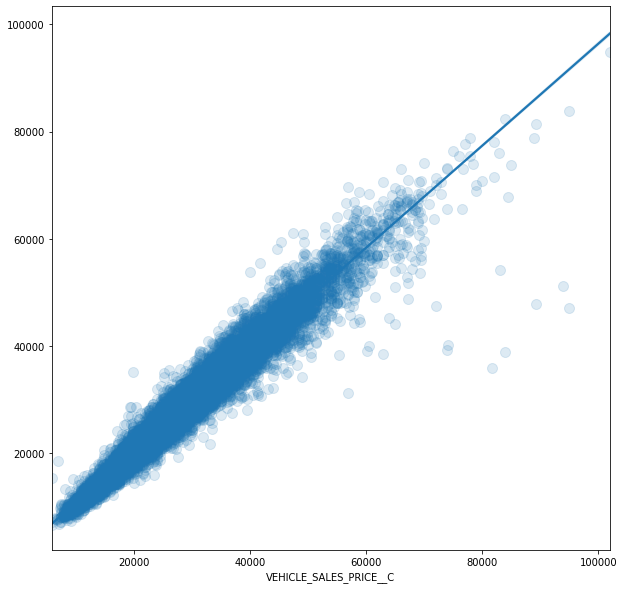

In [40]:
# summarizing the fit of the model. Not log transformed
print(); print(metrics.r2_score(y_test, y_pred))
print(); print(metrics.mean_squared_log_error(y_test, y_pred))
plt.figure(figsize=(10,10))
sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100,'alpha': 0.15})


0.9576870850112129

0.005206320930221335


<AxesSubplot:xlabel='VEHICLE_SALES_PRICE__C'>

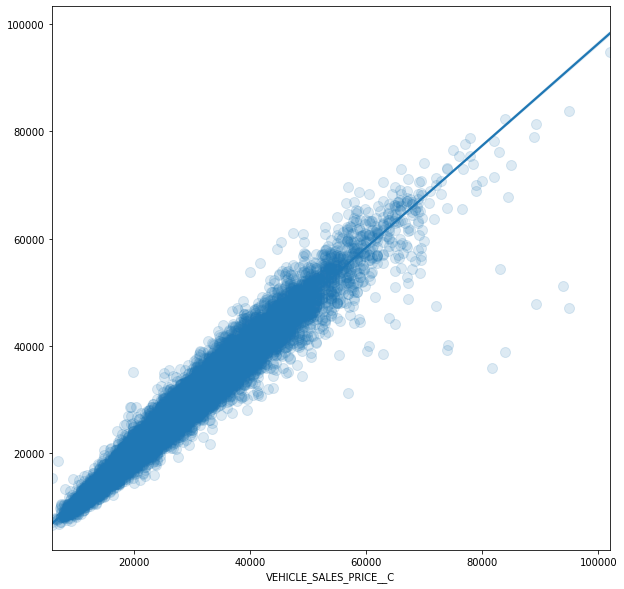

In [41]:
# summarizing the fit of the model. Log transformed
print(); print(metrics.r2_score(y_test, y_pred))
print(); print(metrics.mean_squared_log_error(y_test, y_pred))
plt.figure(figsize=(10,10))
sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100,'alpha': 0.15})


0.9576870850112129

0.005206320930221335


<AxesSubplot:xlabel='VEHICLE_SALES_PRICE__C'>

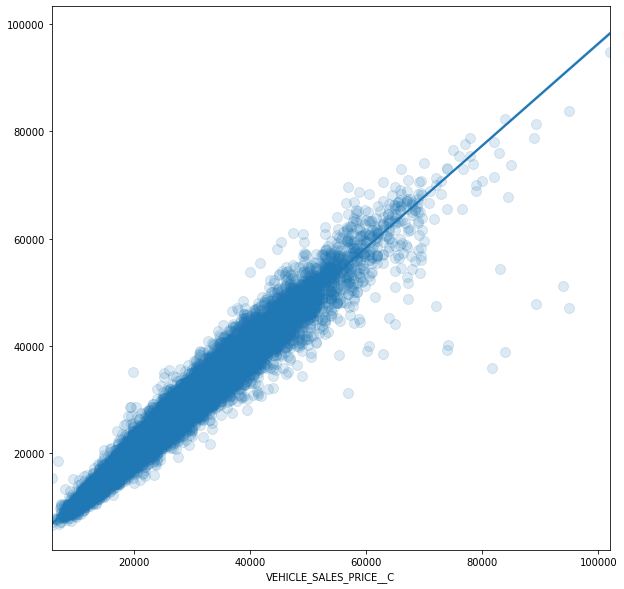

In [42]:
# summarizing the fit of the model. Log transformed 
print(); print(metrics.r2_score(y_test, y_pred))
print(); print(metrics.mean_squared_log_error(y_test, y_pred))
plt.figure(figsize=(10,10))
sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100,'alpha': 0.15})


0.9542777389030603

0.005406220090755218


[Text(0.5, 0, 'Vehicle Sales Price'), Text(0, 0.5, 'Predicted Sales Price')]

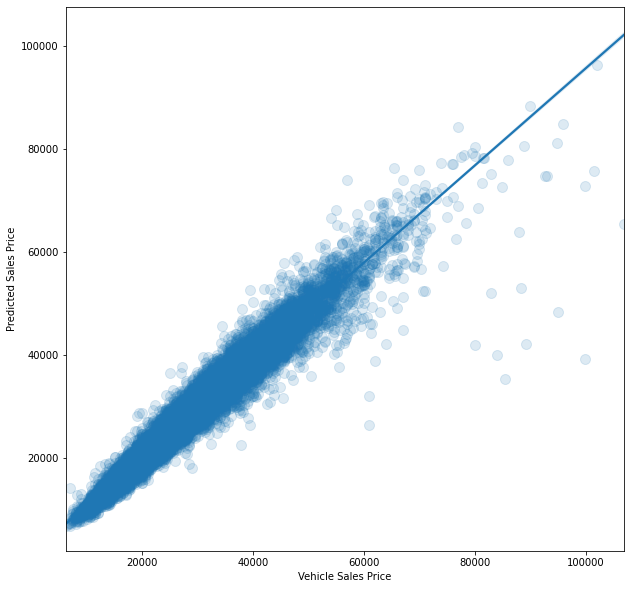

In [31]:
# summarizing the fit of the model. Log transformed. eval_set used test sets.
print(); print(metrics.r2_score(y_test, y_pred))
print(); print(metrics.mean_squared_log_error(y_test, y_pred))
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.figure(figsize=(10,10))
a = sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100,'alpha': 0.15})
a.set(xlabel = 'Vehicle Sales Price', ylabel='Predicted Sales Price')


<AxesSubplot:>

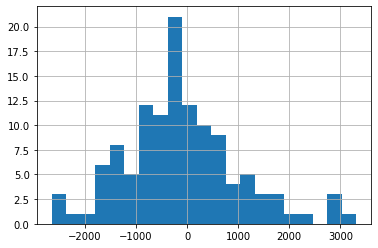

In [32]:
# For all 2017 Nissan Rogue
Nissan_Pred = np.exp(model_lgb.predict(X_test.loc[(X_test['MAKE__C']=='Nissan') & (X_test['MODEL__C']=='Rogue') &(X_test['YEAR__C']==2017)]))
Nissan_Actual = y_test[X_test.loc[(X_test['MAKE__C']=='Nissan') & (X_test['MODEL__C']=='Rogue') &(X_test['YEAR__C']==2017)].index]
Nissan_Diff = Nissan_Actual - Nissan_Pred
Nissan_Diff.hist(bins = 21)

<AxesSubplot:>

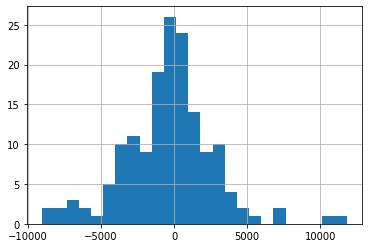

In [33]:
# For all 2018 Ford F-150
Ford_Pred = np.exp(model_lgb.predict(X_test.loc[(X_test['MAKE__C']=='Ford') & (X_test['MODEL__C']=='F-150') &(X_test['YEAR__C']==2018)]))
Ford_Actual = y_test[X_test.loc[(X_test['MAKE__C']=='Ford') & (X_test['MODEL__C']=='F-150') &(X_test['YEAR__C']==2018)].index]
Ford_Diff = Ford_Actual - Ford_Pred
Ford_Diff.hist(bins = 25)

<AxesSubplot:>

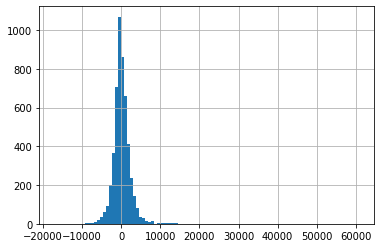

In [34]:
# For all 2018 vehicle
Pred_2018 = np.exp(model_lgb.predict(X_test.loc[(X_test['YEAR__C']==2018)]))
Actual_2018 = y_test[X_test.loc[(X_test['YEAR__C']==2018)].index]
Diff_2018 = Actual_2018 - Pred_2018
Diff_2018.hist(bins = 101)

<AxesSubplot:>

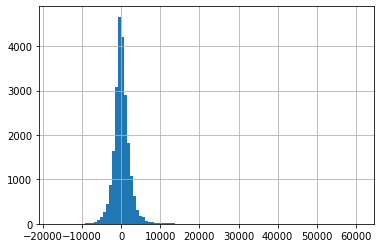

In [35]:
# For all vehicle
Pred = np.exp(model_lgb.predict(X_test))
Actual = y_test
Diff = Actual - Pred
Diff.hist(bins = 101)

<AxesSubplot:xlabel='RATIO', ylabel='SOLD_TAT'>

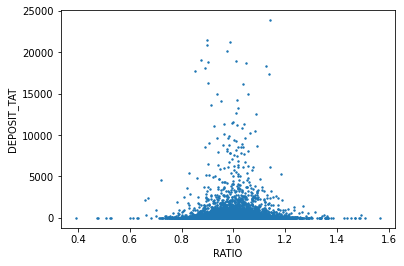

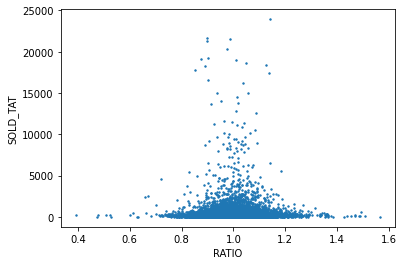

In [36]:
temp = data_raw[['DEPOSIT_TAT','SOLD_TAT']]
temp = temp.iloc[y_test.index]
result = temp.merge(y_test, how='inner',
                   on=None, left_on=None, right_on=None, 
                   left_index=True, right_index=True, 
                   sort=False)
result = result.rename(columns={"VEHICLE_SALES_PRICE__C": "SALES_PRICE_ACTUAL"})
result2 = pd.DataFrame(pd.np.column_stack([result, y_pred]))
result2 = result2.rename(columns={0:'DEPOSIT_TAT',1:'SOLD_TAT',2:'SALES_PRICE_ACTUAL',3:'SALES_PRICE_PRED'})
result2['RATIO'] =result2['SALES_PRICE_PRED']/result2['SALES_PRICE_ACTUAL']
result2.plot.scatter(x = 'RATIO', y = 'DEPOSIT_TAT', s = 2)
result2.plot.scatter(x = 'RATIO', y = 'SOLD_TAT', s = 2)

In [40]:
# how many vehicles has predicted price < actual selling price?


DEPOSIT_TAT  SOLD_TAT  SALES_PRICE_ACTUAL  SALES_PRICE_PRED     RATIO
2           1305.0    1405.0            28999.00      26485.783125  0.913334
7              1.0      24.0            21860.00      20919.753333  0.956988
8              0.0     197.0            37480.00      36836.691656  0.982836
10             9.0     134.0            36999.00      36417.459423  0.984282
11             3.0     127.0            27490.00      25580.467728  0.930537
15            44.0       NaN            15440.00      14217.231674  0.920805
25           506.0     555.0            22940.00      21263.437405  0.926915
27            97.0       NaN            42170.00      35567.941514  0.843442
31            23.0     191.0            25840.00      23966.243831  0.927486
32             2.0     217.0            27880.00      24375.421057  0.874298
33            67.0     301.0            31610.00      31591.412808  0.999412
35            98.0     385.0            24799.00      24540.035228  0.989557
36           746.0     891.0            36999.00      35777.693506  0.966991
37             NaN       NaN            44180.00      41139.308775  0.931175
38            13.0     136.0            33980.00      32959.545771  0.969969
39            21.0      41.0            36999.00      33520.689120  0.905989
40             2.0      50.0            12980.00      12955.641446  0.998123
41            22.0      76.0            44620.00      43874.143637  0.983284
44           652.0     793.0            33740.00      30849.495275  0.914330
45             1.0     212.0            49999.00      44845.927351  0.896936
46            12.0     151.0            29220.00      27869.551399  0.953783
47             1.0     267.0            18999.00      16163.571911  0.850759
51            34.0       NaN            26200.00      25792.073243  0.984430
52            20.0       NaN            23810.00      23774.145552  0.998494
54             2.0      93.0            37670.00      37120.539384  0.985414
57           147.0     239.0            31499.00      30073.119386  0.954733
61           157.0     282.0            47999.00      46090.345680  0.960236
62            18.0     144.0            22720.00      22221.148482  0.978044
65             7.0     151.0            39080.00      36390.284714  0.931174
66            18.0     122.0            23600.00      21572.845578  0.914104
72            75.0     117.0            29999.00      29035.238573  0.967874
73           334.0     568.0            37480.00      36230.268470  0.966656
75            18.0     121.0            23499.00      20036.476187  0.852652
76            22.0     162.0            21999.00      21245.821012  0.965763
77            29.0     128.0            16999.00      15299.579141  0.900028
80             NaN       NaN            34780.00      29816.899826  0.857300
84             4.0     525.0            37499.00      34070.827071  0.908580
85             0.0       9.0            18100.00      16337.439397  0.902621
86            66.0     694.0            29990.00      28922.210105  0.964395
87            31.0     104.0            21290.00      20738.948772  0.974117
89             2.0     318.0            28480.00      26869.128296  0.943438
91           520.0     720.0            24100.00      23222.084841  0.963572
94             1.0      67.0            36580.00      36142.930141  0.988052
95             1.0     198.0            24980.00      24291.044963  0.972420
97            18.0     137.0            38780.00      36459.494540  0.940162
99            23.0      87.0            20790.00      19980.494911  0.961063
101            1.0     116.0            12180.00      12055.532071  0.989781
103            6.0      86.0            25200.00      22258.712804  0.883282
104           42.0     211.0            39999.00      37798.267818  0.944980
107            1.0     712.0            16480.00      16366.711962  0.993126
109          746.0     842.0            29999.00      25867.010127  0.862262
110

In [51]:
result2.groupby(pd.qcut(result2.RATIO, 10)).count()

DEPOSIT_TAT  SOLD_TAT  SALES_PRICE_ACTUAL  SALES_PRICE_PRED  \
RATIO                                                                         
(0.391, 0.916]         2026      1893                2284              2284   
(0.916, 0.947]         1999      1890                2283              2283   
(0.947, 0.968]         2039      1935                2283              2283   
(0.968, 0.985]         2044      1982                2283              2283   
(0.985, 1.001]         2040      2015                2283              2283   
(1.001, 1.017]         2057      2043                2283              2283   
(1.017, 1.034]         2048      2072                2283              2283   
(1.034, 1.055]         2045      2089                2283              2283   
(1.055, 1.089]         2088      2110                2283              2283   
(1.089, 2.033]         2128      2152                2283              2283   

                RATIO  
RATIO                  
(0.391, 0.916]   2284  
(0.916, 0.947]   2283  
(0.947, 0.968]   2283  
(0.968, 0.985]   2283  
(0.985, 1.001]   2283  
(1.001, 1.017]   2283  
(1.017, 1.034]   2283  
(1.034, 1.055]   2283  
(1.055, 1.089]   2283  
(1.089, 2.033]   2283

In [55]:
result2.groupby(pd.qcut(result2.RATIO, 20))['DEPOSIT_TAT'].mean()

RATIO
(0.391, 0.889]    152.972305
(0.889, 0.916]    248.693596
(0.916, 0.933]    114.827621
(0.933, 0.947]    149.711023
(0.947, 0.958]    136.397233
(0.958, 0.968]    151.447907
(0.968, 0.977]    149.372530
(0.977, 0.985]    144.430233
(0.985, 0.993]    145.760933
(0.993, 1.001]    162.751731
(1.001, 1.009]    155.395773
(1.009, 1.017]    169.213583
(1.017, 1.025]    185.968269
(1.025, 1.034]    146.571429
(1.034, 1.044]    165.261209
(1.044, 1.055]    164.902846
(1.055, 1.069]    140.513094
(1.069, 1.089]    146.400189
(1.089, 1.12]     143.594877
(1.12, 2.033]     180.233706
Name: DEPOSIT_TAT, dtype: float64

In [54]:
result2.groupby(pd.qcut(result2.RATIO, 10))['SOLD_TAT'].median()

RATIO
(0.391, 0.916]    154.0
(0.916, 0.947]    166.0
(0.947, 0.968]    166.0
(0.968, 0.985]    169.0
(0.985, 1.001]    167.0
(1.001, 1.017]    169.0
(1.017, 1.034]    170.0
(1.034, 1.055]    186.0
(1.055, 1.089]    173.5
(1.089, 2.033]    170.0
Name: SOLD_TAT, dtype: float64

In [32]:
X_test.loc[(X_test['MAKE__C']=='Ford') & (X_test['MODEL__C']=='F-150') &(X_test['YEAR__C']==2018)]['TRIM__C'].value_counts()

XLT                                                                                      48
4x2 XLT 4dr SuperCrew 5.5 ft. SB                                                         26
XL                                                                                       22
Lariat                                                                                   14
4x4 Lariat 4dr SuperCrew 5.5 ft. SB                                                      10
Raptor                                                                                    9
4x4 King Ranch 4dr SuperCrew 5.5 ft. SB                                                   7
4x4 XLT 4dr SuperCrew 5.5 ft. SB                                                          7
4x4 XL 4dr SuperCrew 5.5 ft. SB                                                           4
4x2 XL 4dr SuperCrew 5.5 ft. SB                                                           3
Platinum                                                                        

In [97]:
# spot check how combined mpg is calculated
#data_raw.loc[(data_raw['MAKE__C']=='Ford') & (data_raw['MODEL__C']=='F-150') &(data_raw['YEAR__C']==2018)][0]

KeyError: 0

In [60]:
#Try a new car Ford F-150 
#https://www.vroom.com/inventory/ford-f-150-2018-1FTEW1EP3JFB83764 1FTEW1EP3JFB83764 Listed at $37499
#https://www.rocketauto.com/detail/2018-ford-f-150-lariat-1193545 1FTFW1E19JFE66587 Listed at $48499
#https://www.vroom.com/inventory/ford-f-150-2018-1FTFW1E19JFE66587
new = X_test.loc[(X_test['MAKE__C']=='Ford') & (X_test['MODEL__C']=='F-150') &(X_test['YEAR__C']==2018)].iloc[0:2]

In [61]:
new.at[68124,'MILES__C']=30994
new.at[68124,'DRIVE_TYPE__C']='4X4'
new.at[68124,'EXTERIOR_COLOR__C']='Magnetic'
new.at[68124,'INTERIOR_COLOR__C']='Black'
new.at[68124,'COMBINED_MPG__C']=21
new.at[68124,'OWNER_COUNT__C']=2
new.at[68124,'MODEL_TRIM']=new.iloc[0]['MODEL__C']+'_'+new.iloc[0]['TRIM__C']
new.at[68124,'MAKE_MODEL_TRIM']=new.iloc[0]['MAKE__C']+'_'+new.iloc[0]['MODEL__C']+'_'+new.iloc[0]['TRIM__C']
new.at[68124,'VIN_1']='1'
new.at[68124,'VIN_2']='F'
new.at[68124,'VIN_3']='T'
new.at[68124,'VIN_4-8']='EW1EP'
new.at[68124,'VIN_9']='3'
new.at[68124,'VIN_10']='J'
new.at[68124,'VIN_11']='F'

new.at[44070,'MILES__C']=43381
new.at[44070,'DRIVE_TYPE__C']='4X4'
new.at[44070,'EXTERIOR_COLOR__C']='Grey'
new.at[44070,'INTERIOR_COLOR__C']='Black'
new.at[44070,'COMBINED_MPG__C']=20
new.at[44070,'TRIM__C']='Lariat'
new.at[44070,'OWNER_COUNT__C']=1
new.at[44070,'MODEL_TRIM']=new.iloc[1]['MODEL__C']+'_'+new.iloc[1]['TRIM__C']
new.at[44070,'MAKE_MODEL_TRIM']=new.iloc[1]['MAKE__C']+'_'+new.iloc[1]['MODEL__C']+'_'+new.iloc[1]['TRIM__C']
new.at[44070,'VIN_1']='1'
new.at[44070,'VIN_2']='F'
new.at[44070,'VIN_3']='T'
new.at[44070,'VIN_4-8']='FW1E1'
new.at[44070,'VIN_9']='9'
new.at[44070,'VIN_10']='J'
new.at[44070,'VIN_11']='F'

In [65]:
new

YEAR__C MAKE__C MODEL__C  MILES__C  BODY_TYPE__C  CYLINDERS__C  \
68124     2018    Ford    F-150     30994  Pickup Truck             6   
44070     2018    Ford    F-150     43381  Pickup Truck             6   

      DRIVE_TYPE__C EXTERIOR_COLOR__C INTERIOR_COLOR__C  DOOR_COUNT__C  \
68124           4X4          Magnetic             Black              4   
44070           4X4              Grey             Black              4   

      FUEL_TYPE__C TRANSMISSION__C TRIM__C  COMBINED_MPG__C TITLE_STATE__C  \
68124     Gasoline       Automatic     XLT               21             OH   
44070     Gasoline       Automatic  Lariat               20             CA   

       OWNER_COUNT__C  SHIPPED_ONLY__C  ELIGIBLE_FOR_LIMITED_WARRANTY__C  \
68124               2                1                                 1   
44070               1                0                                 1   

         MODEL_TRIM    MAKE_MODEL_TRIM  PreOwner_personal  PreOwner_lease  \
68124     F-150_XLT     Ford_F-150_XLT                  1               1   
44070  F-150_Lariat  Ford_F-150_Lariat                  1               0   

       PreOwner_rental  PreOwner_corporate  PreOwner_commercial  \
68124                0                   0                    0   
44070                0                   0                    0   

       PreOwner_taxi  PreOwner_government VIN_1 VIN_2 VIN_3 VIN_4-8 VIN_10  \
68124              0                    0     1     F     T   EW1EP      J   
44070              0                    0     1     F     T   FW1E1      J   

      VIN_11 VIN_9  
68124      F     3  
44070      F     9

In [63]:
np.exp(model_lgb.predict(new))

ValueError: Number of features of the model must match the input. Model n_features_ is 33 and input n_features is 34 

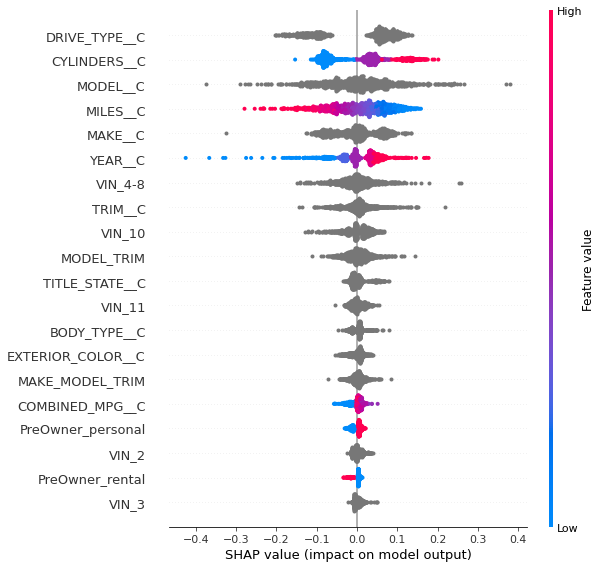

In [66]:
#Model explainability
import shap
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_train[0:1000])
shap.summary_plot(shap_values, X_train[0:1000])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

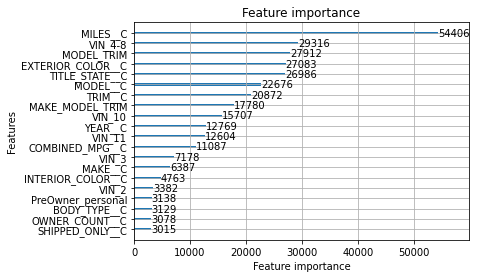

In [67]:
lgb.plot_importance(model_lgb, max_num_features=20)

In [ ]:
# Do the vehicles that has a predicted price that is 10% or more lower than the listed price, actually sells faster?
# Measure two things: From lead created time to deposite time. From lead created time to sold time.
# get X_test and y_test, get y_pred, find the index with y_pred < 0.9*y_test, generate a datafram with VIN, save as CSV


In [ ]:
# Model impromvement (more features)
# Model implementation


In [ ]:
# turn float into category
for c in df:
    col_type = type(c)
    if col_type == 'object' or col_type == 'str' or col_type == 'category':
        df[c] = df[c].astype('category')

In [60]:
# type(X_test.loc[(X_test['MAKE__C']=='Ford') & (X_test['MODEL__C']=='F-150') &(X_test['YEAR__C']==2018)])
# type(new)
# new.MAKE__C.astype('category')
new.dtype

dtype('O')

In [50]:
# type(new.iloc[0])
np.exp(lgb.predict(new))

ValueError: could not convert string to float: 'Ford'

In [61]:
new

YEAR__C                                     2018
MAKE__C                                     Ford
MODEL__C                                   F-150
MILES__C                                   30994
BODY_TYPE__C                        Pickup Truck
CYLINDERS__C                                   6
DRIVE_TYPE__C                                4X4
EXTERIOR_COLOR__C                          Black
INTERIOR_COLOR__C                          Black
DOOR_COUNT__C                                  4
FUEL_TYPE__C                            Gasoline
TRANSMISSION__C                        Automatic
TRIM__C                                      XLT
COMBINED_MPG__C                               21
TITLE_STATE__C                                TX
OWNER_COUNT__C                                 2
SHIPPED_ONLY__C                                0
ELIGIBLE_FOR_LIMITED_WARRANTY__C               1
PreOwner_personal                              1
PreOwner_lease                                 0
PreOwner_rental     

In [34]:
# log transfer target variable before prediction to make it normally distributed
import lightgbm as lgb
from datetime import datetime
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.82,
    'bagging_fraction': 0.86,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 9,
    "num_leaves": 75,  
    "max_bin": 512,
    "num_iterations": 10000
}
start = datetime.now()
lgb = lgb.LGBMRegressor(**hyper_params)
lgb.fit(X_train, y_train_log,
        eval_set=[(X_test, y_test_log)],
        eval_metric='l1',
        early_stopping_rounds=1000)
model_elapse = datetime.now() - start
print('elapse:, ', model_elapse)


[LightGBM] [Warning] feature_fraction is set=0.82, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82
[LightGBM] [Warning] bagging_fraction is set=0.86, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.82, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82
[LightGBM] [Warning] bagging_fraction is set=0.86, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.82, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82

[141]	valid_0's l1: 0.184651	valid_0's l2: 0.0542668
[142]	valid_0's l1: 0.184	valid_0's l2: 0.0539052
[143]	valid_0's l1: 0.183358	valid_0's l2: 0.053547
[144]	valid_0's l1: 0.182724	valid_0's l2: 0.0531926
[145]	valid_0's l1: 0.182105	valid_0's l2: 0.0528456
[146]	valid_0's l1: 0.181482	valid_0's l2: 0.0524988
[147]	valid_0's l1: 0.180876	valid_0's l2: 0.0521608
[148]	valid_0's l1: 0.180212	valid_0's l2: 0.0518001
[149]	valid_0's l1: 0.179552	valid_0's l2: 0.0514424
[150]	valid_0's l1: 0.178926	valid_0's l2: 0.0511076
[151]	valid_0's l1: 0.178389	valid_0's l2: 0.0508113
[152]	valid_0's l1: 0.177793	valid_0's l2: 0.0504888
[153]	valid_0's l1: 0.177196	valid_0's l2: 0.0501656
[154]	valid_0's l1: 0.176589	valid_0's l2: 0.0498363
[155]	valid_0's l1: 0.175976	valid_0's l2: 0.0495095
[156]	valid_0's l1: 0.175374	valid_0's l2: 0.0491869
[157]	valid_0's l1: 0.174771	valid_0's l2: 0.0488679
[158]	valid_0's l1: 0.174169	valid_0's l2: 0.048549
[159]	valid_0's l1: 0.173536	valid_0's l2: 0.048218

[302]	valid_0's l1: 0.113497	valid_0's l2: 0.0220065
[303]	valid_0's l1: 0.113208	valid_0's l2: 0.0219068
[304]	valid_0's l1: 0.112926	valid_0's l2: 0.0218095
[305]	valid_0's l1: 0.112668	valid_0's l2: 0.0217181
[306]	valid_0's l1: 0.112385	valid_0's l2: 0.0216197
[307]	valid_0's l1: 0.11212	valid_0's l2: 0.0215282
[308]	valid_0's l1: 0.111844	valid_0's l2: 0.0214315
[309]	valid_0's l1: 0.111576	valid_0's l2: 0.0213376
[310]	valid_0's l1: 0.111308	valid_0's l2: 0.0212437
[311]	valid_0's l1: 0.111044	valid_0's l2: 0.0211537
[312]	valid_0's l1: 0.110781	valid_0's l2: 0.0210644
[313]	valid_0's l1: 0.110523	valid_0's l2: 0.0209737
[314]	valid_0's l1: 0.110255	valid_0's l2: 0.0208843
[315]	valid_0's l1: 0.110003	valid_0's l2: 0.020798
[316]	valid_0's l1: 0.109766	valid_0's l2: 0.0207163
[317]	valid_0's l1: 0.109513	valid_0's l2: 0.0206313
[318]	valid_0's l1: 0.109266	valid_0's l2: 0.0205475
[319]	valid_0's l1: 0.108993	valid_0's l2: 0.0204569
[320]	valid_0's l1: 0.108744	valid_0's l2: 0.020

[469]	valid_0's l1: 0.0835823	valid_0's l2: 0.0126952
[470]	valid_0's l1: 0.0834652	valid_0's l2: 0.0126627
[471]	valid_0's l1: 0.0833554	valid_0's l2: 0.0126326
[472]	valid_0's l1: 0.0832497	valid_0's l2: 0.0126034
[473]	valid_0's l1: 0.0831507	valid_0's l2: 0.0125761
[474]	valid_0's l1: 0.0830478	valid_0's l2: 0.0125473
[475]	valid_0's l1: 0.0829489	valid_0's l2: 0.0125202
[476]	valid_0's l1: 0.0828445	valid_0's l2: 0.0124916
[477]	valid_0's l1: 0.0827444	valid_0's l2: 0.0124637
[478]	valid_0's l1: 0.0826468	valid_0's l2: 0.0124369
[479]	valid_0's l1: 0.0825522	valid_0's l2: 0.0124114
[480]	valid_0's l1: 0.082456	valid_0's l2: 0.012385
[481]	valid_0's l1: 0.0823429	valid_0's l2: 0.0123542
[482]	valid_0's l1: 0.0822386	valid_0's l2: 0.012325
[483]	valid_0's l1: 0.0821384	valid_0's l2: 0.012297
[484]	valid_0's l1: 0.0820376	valid_0's l2: 0.0122698
[485]	valid_0's l1: 0.0819309	valid_0's l2: 0.0122416
[486]	valid_0's l1: 0.0818337	valid_0's l2: 0.0122152
[487]	valid_0's l1: 0.0817284	va

[629]	valid_0's l1: 0.0716984	valid_0's l2: 0.00959221
[630]	valid_0's l1: 0.0716577	valid_0's l2: 0.00958178
[631]	valid_0's l1: 0.0716121	valid_0's l2: 0.00957001
[632]	valid_0's l1: 0.071562	valid_0's l2: 0.00955703
[633]	valid_0's l1: 0.0715069	valid_0's l2: 0.00954345
[634]	valid_0's l1: 0.0714628	valid_0's l2: 0.00953224
[635]	valid_0's l1: 0.0714154	valid_0's l2: 0.0095205
[636]	valid_0's l1: 0.0713714	valid_0's l2: 0.00950936
[637]	valid_0's l1: 0.0713277	valid_0's l2: 0.00949908
[638]	valid_0's l1: 0.0712845	valid_0's l2: 0.00948873
[639]	valid_0's l1: 0.0712305	valid_0's l2: 0.0094753
[640]	valid_0's l1: 0.0711795	valid_0's l2: 0.00946302
[641]	valid_0's l1: 0.0711349	valid_0's l2: 0.00945144
[642]	valid_0's l1: 0.0710936	valid_0's l2: 0.0094403
[643]	valid_0's l1: 0.0710509	valid_0's l2: 0.00942912
[644]	valid_0's l1: 0.0710111	valid_0's l2: 0.00941859
[645]	valid_0's l1: 0.0709605	valid_0's l2: 0.00940534
[646]	valid_0's l1: 0.0709174	valid_0's l2: 0.00939357
[647]	valid_0'

[790]	valid_0's l1: 0.0661546	valid_0's l2: 0.00823012
[791]	valid_0's l1: 0.0661318	valid_0's l2: 0.00822454
[792]	valid_0's l1: 0.0661102	valid_0's l2: 0.00821912
[793]	valid_0's l1: 0.0660883	valid_0's l2: 0.00821383
[794]	valid_0's l1: 0.0660636	valid_0's l2: 0.00820784
[795]	valid_0's l1: 0.0660411	valid_0's l2: 0.00820228
[796]	valid_0's l1: 0.0660165	valid_0's l2: 0.00819615
[797]	valid_0's l1: 0.0659938	valid_0's l2: 0.00819063
[798]	valid_0's l1: 0.0659698	valid_0's l2: 0.00818488
[799]	valid_0's l1: 0.0659494	valid_0's l2: 0.00817997
[800]	valid_0's l1: 0.0659304	valid_0's l2: 0.00817509
[801]	valid_0's l1: 0.0659089	valid_0's l2: 0.00816972
[802]	valid_0's l1: 0.0658879	valid_0's l2: 0.00816455
[803]	valid_0's l1: 0.0658662	valid_0's l2: 0.00815952
[804]	valid_0's l1: 0.065844	valid_0's l2: 0.00815395
[805]	valid_0's l1: 0.0658244	valid_0's l2: 0.0081495
[806]	valid_0's l1: 0.0658039	valid_0's l2: 0.00814441
[807]	valid_0's l1: 0.0657845	valid_0's l2: 0.00813957
[808]	valid_

[945]	valid_0's l1: 0.0633141	valid_0's l2: 0.00754427
[946]	valid_0's l1: 0.0632985	valid_0's l2: 0.00754074
[947]	valid_0's l1: 0.0632838	valid_0's l2: 0.00753738
[948]	valid_0's l1: 0.0632739	valid_0's l2: 0.00753505
[949]	valid_0's l1: 0.0632626	valid_0's l2: 0.00753218
[950]	valid_0's l1: 0.0632485	valid_0's l2: 0.00752905
[951]	valid_0's l1: 0.0632399	valid_0's l2: 0.00752671
[952]	valid_0's l1: 0.063229	valid_0's l2: 0.00752411
[953]	valid_0's l1: 0.0632128	valid_0's l2: 0.00752057
[954]	valid_0's l1: 0.0632037	valid_0's l2: 0.00751821
[955]	valid_0's l1: 0.0631888	valid_0's l2: 0.0075144
[956]	valid_0's l1: 0.0631741	valid_0's l2: 0.00751057
[957]	valid_0's l1: 0.0631602	valid_0's l2: 0.00750703
[958]	valid_0's l1: 0.0631467	valid_0's l2: 0.00750355
[959]	valid_0's l1: 0.0631379	valid_0's l2: 0.00750104
[960]	valid_0's l1: 0.0631266	valid_0's l2: 0.00749832
[961]	valid_0's l1: 0.0631182	valid_0's l2: 0.00749598
[962]	valid_0's l1: 0.0631029	valid_0's l2: 0.0074925
[963]	valid_0

[1095]	valid_0's l1: 0.0616513	valid_0's l2: 0.00715361
[1096]	valid_0's l1: 0.0616387	valid_0's l2: 0.00715089
[1097]	valid_0's l1: 0.0616267	valid_0's l2: 0.00714843
[1098]	valid_0's l1: 0.0616185	valid_0's l2: 0.00714671
[1099]	valid_0's l1: 0.0616063	valid_0's l2: 0.00714415
[1100]	valid_0's l1: 0.0615971	valid_0's l2: 0.00714171
[1101]	valid_0's l1: 0.0615894	valid_0's l2: 0.00713989
[1102]	valid_0's l1: 0.0615816	valid_0's l2: 0.00713795
[1103]	valid_0's l1: 0.0615743	valid_0's l2: 0.0071362
[1104]	valid_0's l1: 0.0615668	valid_0's l2: 0.00713442
[1105]	valid_0's l1: 0.0615603	valid_0's l2: 0.00713286
[1106]	valid_0's l1: 0.0615486	valid_0's l2: 0.00713019
[1107]	valid_0's l1: 0.0615387	valid_0's l2: 0.00712784
[1108]	valid_0's l1: 0.0615315	valid_0's l2: 0.00712595
[1109]	valid_0's l1: 0.061521	valid_0's l2: 0.00712365
[1110]	valid_0's l1: 0.061511	valid_0's l2: 0.00712128
[1111]	valid_0's l1: 0.0614998	valid_0's l2: 0.00711888
[1112]	valid_0's l1: 0.0614898	valid_0's l2: 0.0071

[1240]	valid_0's l1: 0.0605233	valid_0's l2: 0.00689586
[1241]	valid_0's l1: 0.0605202	valid_0's l2: 0.00689499
[1242]	valid_0's l1: 0.0605168	valid_0's l2: 0.00689417
[1243]	valid_0's l1: 0.0605129	valid_0's l2: 0.00689322
[1244]	valid_0's l1: 0.060506	valid_0's l2: 0.00689176
[1245]	valid_0's l1: 0.0604983	valid_0's l2: 0.00688986
[1246]	valid_0's l1: 0.0604924	valid_0's l2: 0.00688853
[1247]	valid_0's l1: 0.0604884	valid_0's l2: 0.00688756
[1248]	valid_0's l1: 0.0604842	valid_0's l2: 0.00688668
[1249]	valid_0's l1: 0.0604803	valid_0's l2: 0.00688573
[1250]	valid_0's l1: 0.0604719	valid_0's l2: 0.00688337
[1251]	valid_0's l1: 0.0604645	valid_0's l2: 0.00688162
[1252]	valid_0's l1: 0.06046	valid_0's l2: 0.0068805
[1253]	valid_0's l1: 0.0604529	valid_0's l2: 0.006879
[1254]	valid_0's l1: 0.0604471	valid_0's l2: 0.0068774
[1255]	valid_0's l1: 0.0604389	valid_0's l2: 0.00687538
[1256]	valid_0's l1: 0.0604321	valid_0's l2: 0.00687383
[1257]	valid_0's l1: 0.060427	valid_0's l2: 0.00687258


[1392]	valid_0's l1: 0.0596439	valid_0's l2: 0.00670125
[1393]	valid_0's l1: 0.0596359	valid_0's l2: 0.00669958
[1394]	valid_0's l1: 0.0596302	valid_0's l2: 0.00669842
[1395]	valid_0's l1: 0.0596235	valid_0's l2: 0.00669731
[1396]	valid_0's l1: 0.0596209	valid_0's l2: 0.00669671
[1397]	valid_0's l1: 0.0596133	valid_0's l2: 0.00669531
[1398]	valid_0's l1: 0.0596102	valid_0's l2: 0.00669474
[1399]	valid_0's l1: 0.0596041	valid_0's l2: 0.00669309
[1400]	valid_0's l1: 0.0596013	valid_0's l2: 0.00669251
[1401]	valid_0's l1: 0.0595951	valid_0's l2: 0.00669133
[1402]	valid_0's l1: 0.0595888	valid_0's l2: 0.00669006
[1403]	valid_0's l1: 0.0595815	valid_0's l2: 0.00668862
[1404]	valid_0's l1: 0.0595754	valid_0's l2: 0.00668747
[1405]	valid_0's l1: 0.0595722	valid_0's l2: 0.00668677
[1406]	valid_0's l1: 0.0595657	valid_0's l2: 0.00668552
[1407]	valid_0's l1: 0.05956	valid_0's l2: 0.00668436
[1408]	valid_0's l1: 0.0595533	valid_0's l2: 0.00668296
[1409]	valid_0's l1: 0.059549	valid_0's l2: 0.0066

[1545]	valid_0's l1: 0.0589855	valid_0's l2: 0.00654537
[1546]	valid_0's l1: 0.0589833	valid_0's l2: 0.00654486
[1547]	valid_0's l1: 0.0589773	valid_0's l2: 0.00654362
[1548]	valid_0's l1: 0.0589727	valid_0's l2: 0.00654266
[1549]	valid_0's l1: 0.0589692	valid_0's l2: 0.00654193
[1550]	valid_0's l1: 0.0589674	valid_0's l2: 0.00654141
[1551]	valid_0's l1: 0.0589643	valid_0's l2: 0.00654048
[1552]	valid_0's l1: 0.0589611	valid_0's l2: 0.00653982
[1553]	valid_0's l1: 0.0589574	valid_0's l2: 0.00653908
[1554]	valid_0's l1: 0.058955	valid_0's l2: 0.00653838
[1555]	valid_0's l1: 0.0589521	valid_0's l2: 0.00653744
[1556]	valid_0's l1: 0.0589483	valid_0's l2: 0.0065364
[1557]	valid_0's l1: 0.0589435	valid_0's l2: 0.00653531
[1558]	valid_0's l1: 0.0589399	valid_0's l2: 0.0065346
[1559]	valid_0's l1: 0.0589359	valid_0's l2: 0.00653357
[1560]	valid_0's l1: 0.0589339	valid_0's l2: 0.00653302
[1561]	valid_0's l1: 0.0589314	valid_0's l2: 0.00653236
[1562]	valid_0's l1: 0.0589261	valid_0's l2: 0.0065

[1705]	valid_0's l1: 0.0584454	valid_0's l2: 0.00642118
[1706]	valid_0's l1: 0.0584431	valid_0's l2: 0.00642064
[1707]	valid_0's l1: 0.0584408	valid_0's l2: 0.00642011
[1708]	valid_0's l1: 0.0584393	valid_0's l2: 0.00641967
[1709]	valid_0's l1: 0.0584348	valid_0's l2: 0.00641868
[1710]	valid_0's l1: 0.0584322	valid_0's l2: 0.00641816
[1711]	valid_0's l1: 0.0584306	valid_0's l2: 0.00641784
[1712]	valid_0's l1: 0.0584291	valid_0's l2: 0.00641748
[1713]	valid_0's l1: 0.058428	valid_0's l2: 0.0064172
[1714]	valid_0's l1: 0.0584222	valid_0's l2: 0.00641514
[1715]	valid_0's l1: 0.058421	valid_0's l2: 0.00641491
[1716]	valid_0's l1: 0.0584195	valid_0's l2: 0.00641447
[1717]	valid_0's l1: 0.0584182	valid_0's l2: 0.00641404
[1718]	valid_0's l1: 0.0584167	valid_0's l2: 0.00641377
[1719]	valid_0's l1: 0.0584145	valid_0's l2: 0.00641302
[1720]	valid_0's l1: 0.0584131	valid_0's l2: 0.00641269
[1721]	valid_0's l1: 0.0584101	valid_0's l2: 0.00641213
[1722]	valid_0's l1: 0.0584077	valid_0's l2: 0.0064

[1865]	valid_0's l1: 0.0580117	valid_0's l2: 0.00632232
[1866]	valid_0's l1: 0.0580092	valid_0's l2: 0.00632175
[1867]	valid_0's l1: 0.058007	valid_0's l2: 0.00632117
[1868]	valid_0's l1: 0.0580048	valid_0's l2: 0.00632059
[1869]	valid_0's l1: 0.0580016	valid_0's l2: 0.00631988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1870]	valid_0's l1: 0.0579983	valid_0's l2: 0.00631897
[1871]	valid_0's l1: 0.0579967	valid_0's l2: 0.00631861
[1872]	valid_0's l1: 0.0579951	valid_0's l2: 0.00631822
[1873]	valid_0's l1: 0.0579931	valid_0's l2: 0.0063178
[1874]	valid_0's l1: 0.0579913	valid_0's l2: 0.0063174
[1875]	valid_0's l1: 0.0579896	valid_0's l2: 0.00631698
[1876]	valid_0's l1: 0.0579876	valid_0's l2: 0.00631643
[1877]	valid_0's l1: 0.0579846	valid_0's l2: 0.00631584
[1878]	valid_0's l1: 0.0579826	valid_0's l2: 0.00631539
[1879]	valid_0's l1: 0.0579809	valid_0's l2: 0.00631499
[1880]	valid_0's l1: 0.057979	valid_0's l2: 0.00631453
[1881]	valid_0's l1: 0.057978	val

[2019]	valid_0's l1: 0.0576582	valid_0's l2: 0.00624057
[2020]	valid_0's l1: 0.0576561	valid_0's l2: 0.00624014
[2021]	valid_0's l1: 0.0576545	valid_0's l2: 0.00623976
[2022]	valid_0's l1: 0.0576531	valid_0's l2: 0.00623945
[2023]	valid_0's l1: 0.0576518	valid_0's l2: 0.0062391
[2024]	valid_0's l1: 0.0576503	valid_0's l2: 0.00623873
[2025]	valid_0's l1: 0.057649	valid_0's l2: 0.00623837
[2026]	valid_0's l1: 0.0576477	valid_0's l2: 0.00623798
[2027]	valid_0's l1: 0.0576468	valid_0's l2: 0.00623775
[2028]	valid_0's l1: 0.0576455	valid_0's l2: 0.00623742
[2029]	valid_0's l1: 0.0576438	valid_0's l2: 0.00623693
[2030]	valid_0's l1: 0.0576412	valid_0's l2: 0.00623637
[2031]	valid_0's l1: 0.0576389	valid_0's l2: 0.00623598
[2032]	valid_0's l1: 0.0576348	valid_0's l2: 0.0062346
[2033]	valid_0's l1: 0.0576307	valid_0's l2: 0.00623385
[2034]	valid_0's l1: 0.0576271	valid_0's l2: 0.00623279
[2035]	valid_0's l1: 0.0576242	valid_0's l2: 0.00623236
[2036]	valid_0's l1: 0.057621	valid_0's l2: 0.00623

[2181]	valid_0's l1: 0.0573311	valid_0's l2: 0.00615896
[2182]	valid_0's l1: 0.0573302	valid_0's l2: 0.00615877
[2183]	valid_0's l1: 0.0573284	valid_0's l2: 0.00615839
[2184]	valid_0's l1: 0.0573273	valid_0's l2: 0.0061581
[2185]	valid_0's l1: 0.0573264	valid_0's l2: 0.00615793
[2186]	valid_0's l1: 0.0573252	valid_0's l2: 0.0061577
[2187]	valid_0's l1: 0.0573242	valid_0's l2: 0.00615747
[2188]	valid_0's l1: 0.0573229	valid_0's l2: 0.00615726
[2189]	valid_0's l1: 0.0573212	valid_0's l2: 0.00615685
[2190]	valid_0's l1: 0.0573194	valid_0's l2: 0.00615641
[2191]	valid_0's l1: 0.0573182	valid_0's l2: 0.00615609
[2192]	valid_0's l1: 0.0573171	valid_0's l2: 0.00615583
[2193]	valid_0's l1: 0.0573152	valid_0's l2: 0.00615544
[2194]	valid_0's l1: 0.0573136	valid_0's l2: 0.00615508
[2195]	valid_0's l1: 0.0573119	valid_0's l2: 0.00615457
[2196]	valid_0's l1: 0.0573088	valid_0's l2: 0.00615379
[2197]	valid_0's l1: 0.0573069	valid_0's l2: 0.00615316
[2198]	valid_0's l1: 0.0573058	valid_0's l2: 0.006

[2341]	valid_0's l1: 0.0570795	valid_0's l2: 0.00610086
[2342]	valid_0's l1: 0.0570774	valid_0's l2: 0.00610045
[2343]	valid_0's l1: 0.0570763	valid_0's l2: 0.00610022
[2344]	valid_0's l1: 0.057074	valid_0's l2: 0.00609979
[2345]	valid_0's l1: 0.0570728	valid_0's l2: 0.00609958
[2346]	valid_0's l1: 0.0570717	valid_0's l2: 0.00609936
[2347]	valid_0's l1: 0.0570696	valid_0's l2: 0.00609897
[2348]	valid_0's l1: 0.0570677	valid_0's l2: 0.00609862
[2349]	valid_0's l1: 0.0570654	valid_0's l2: 0.00609819
[2350]	valid_0's l1: 0.0570639	valid_0's l2: 0.00609794
[2351]	valid_0's l1: 0.057063	valid_0's l2: 0.00609767
[2352]	valid_0's l1: 0.0570626	valid_0's l2: 0.00609754
[2353]	valid_0's l1: 0.0570613	valid_0's l2: 0.00609722
[2354]	valid_0's l1: 0.0570603	valid_0's l2: 0.00609698
[2355]	valid_0's l1: 0.0570597	valid_0's l2: 0.00609684
[2356]	valid_0's l1: 0.0570585	valid_0's l2: 0.00609664
[2357]	valid_0's l1: 0.0570577	valid_0's l2: 0.00609646
[2358]	valid_0's l1: 0.0570558	valid_0's l2: 0.006

[2502]	valid_0's l1: 0.0568172	valid_0's l2: 0.00603647
[2503]	valid_0's l1: 0.0568169	valid_0's l2: 0.00603638
[2504]	valid_0's l1: 0.0568159	valid_0's l2: 0.00603623
[2505]	valid_0's l1: 0.056814	valid_0's l2: 0.00603591
[2506]	valid_0's l1: 0.0568133	valid_0's l2: 0.00603574
[2507]	valid_0's l1: 0.0568123	valid_0's l2: 0.00603556
[2508]	valid_0's l1: 0.0568113	valid_0's l2: 0.00603536
[2509]	valid_0's l1: 0.0568104	valid_0's l2: 0.00603517
[2510]	valid_0's l1: 0.0568093	valid_0's l2: 0.006035
[2511]	valid_0's l1: 0.0568087	valid_0's l2: 0.00603493
[2512]	valid_0's l1: 0.0568078	valid_0's l2: 0.00603475
[2513]	valid_0's l1: 0.0568063	valid_0's l2: 0.00603444
[2514]	valid_0's l1: 0.0568048	valid_0's l2: 0.00603413
[2515]	valid_0's l1: 0.0568039	valid_0's l2: 0.00603398
[2516]	valid_0's l1: 0.0568026	valid_0's l2: 0.00603379
[2517]	valid_0's l1: 0.0568017	valid_0's l2: 0.00603351
[2518]	valid_0's l1: 0.0567986	valid_0's l2: 0.0060328
[2519]	valid_0's l1: 0.0567973	valid_0's l2: 0.00603

[2663]	valid_0's l1: 0.0566042	valid_0's l2: 0.00598046
[2664]	valid_0's l1: 0.0566029	valid_0's l2: 0.00598024
[2665]	valid_0's l1: 0.0566013	valid_0's l2: 0.00597989
[2666]	valid_0's l1: 0.0566004	valid_0's l2: 0.00597977
[2667]	valid_0's l1: 0.0565995	valid_0's l2: 0.00597963
[2668]	valid_0's l1: 0.0565982	valid_0's l2: 0.00597942
[2669]	valid_0's l1: 0.0565976	valid_0's l2: 0.00597928
[2670]	valid_0's l1: 0.0565968	valid_0's l2: 0.00597911
[2671]	valid_0's l1: 0.0565951	valid_0's l2: 0.00597874
[2672]	valid_0's l1: 0.0565941	valid_0's l2: 0.00597851
[2673]	valid_0's l1: 0.0565932	valid_0's l2: 0.00597833
[2674]	valid_0's l1: 0.0565922	valid_0's l2: 0.00597816
[2675]	valid_0's l1: 0.0565912	valid_0's l2: 0.00597799
[2676]	valid_0's l1: 0.0565901	valid_0's l2: 0.00597768
[2677]	valid_0's l1: 0.0565895	valid_0's l2: 0.00597749
[2678]	valid_0's l1: 0.0565887	valid_0's l2: 0.00597729
[2679]	valid_0's l1: 0.0565877	valid_0's l2: 0.00597704
[2680]	valid_0's l1: 0.0565865	valid_0's l2: 0.0

[2814]	valid_0's l1: 0.0564483	valid_0's l2: 0.00594492
[2815]	valid_0's l1: 0.0564471	valid_0's l2: 0.00594475
[2816]	valid_0's l1: 0.0564455	valid_0's l2: 0.00594448
[2817]	valid_0's l1: 0.056444	valid_0's l2: 0.00594425
[2818]	valid_0's l1: 0.0564425	valid_0's l2: 0.00594403
[2819]	valid_0's l1: 0.0564415	valid_0's l2: 0.00594378
[2820]	valid_0's l1: 0.0564407	valid_0's l2: 0.00594359
[2821]	valid_0's l1: 0.0564393	valid_0's l2: 0.00594328
[2822]	valid_0's l1: 0.0564377	valid_0's l2: 0.00594292
[2823]	valid_0's l1: 0.0564369	valid_0's l2: 0.00594277
[2824]	valid_0's l1: 0.056435	valid_0's l2: 0.00594233
[2825]	valid_0's l1: 0.0564338	valid_0's l2: 0.00594208
[2826]	valid_0's l1: 0.056432	valid_0's l2: 0.0059416
[2827]	valid_0's l1: 0.0564311	valid_0's l2: 0.00594147
[2828]	valid_0's l1: 0.0564304	valid_0's l2: 0.00594133
[2829]	valid_0's l1: 0.0564284	valid_0's l2: 0.00594058
[2830]	valid_0's l1: 0.0564274	valid_0's l2: 0.00594027
[2831]	valid_0's l1: 0.0564246	valid_0's l2: 0.00593

[2966]	valid_0's l1: 0.0562795	valid_0's l2: 0.0059004
[2967]	valid_0's l1: 0.0562787	valid_0's l2: 0.00590023
[2968]	valid_0's l1: 0.0562786	valid_0's l2: 0.00590019
[2969]	valid_0's l1: 0.0562775	valid_0's l2: 0.00589997
[2970]	valid_0's l1: 0.0562767	valid_0's l2: 0.00589976
[2971]	valid_0's l1: 0.0562758	valid_0's l2: 0.00589959
[2972]	valid_0's l1: 0.0562748	valid_0's l2: 0.00589932
[2973]	valid_0's l1: 0.0562723	valid_0's l2: 0.00589848
[2974]	valid_0's l1: 0.0562717	valid_0's l2: 0.00589827
[2975]	valid_0's l1: 0.0562711	valid_0's l2: 0.00589807
[2976]	valid_0's l1: 0.0562702	valid_0's l2: 0.00589775
[2977]	valid_0's l1: 0.0562692	valid_0's l2: 0.00589758
[2978]	valid_0's l1: 0.056268	valid_0's l2: 0.00589737
[2979]	valid_0's l1: 0.0562669	valid_0's l2: 0.00589706
[2980]	valid_0's l1: 0.0562655	valid_0's l2: 0.00589684
[2981]	valid_0's l1: 0.056265	valid_0's l2: 0.00589671
[2982]	valid_0's l1: 0.0562648	valid_0's l2: 0.00589664
[2983]	valid_0's l1: 0.0562642	valid_0's l2: 0.0058

[3116]	valid_0's l1: 0.056171	valid_0's l2: 0.00587314
[3117]	valid_0's l1: 0.0561696	valid_0's l2: 0.00587277
[3118]	valid_0's l1: 0.0561688	valid_0's l2: 0.00587231
[3119]	valid_0's l1: 0.056167	valid_0's l2: 0.00587167
[3120]	valid_0's l1: 0.056166	valid_0's l2: 0.00587117
[3121]	valid_0's l1: 0.0561649	valid_0's l2: 0.0058709
[3122]	valid_0's l1: 0.0561645	valid_0's l2: 0.00587083
[3123]	valid_0's l1: 0.0561636	valid_0's l2: 0.00587057
[3124]	valid_0's l1: 0.0561626	valid_0's l2: 0.00587038
[3125]	valid_0's l1: 0.0561605	valid_0's l2: 0.0058698
[3126]	valid_0's l1: 0.0561594	valid_0's l2: 0.00586963
[3127]	valid_0's l1: 0.0561586	valid_0's l2: 0.00586942
[3128]	valid_0's l1: 0.0561573	valid_0's l2: 0.00586902
[3129]	valid_0's l1: 0.0561564	valid_0's l2: 0.00586874
[3130]	valid_0's l1: 0.056156	valid_0's l2: 0.00586864
[3131]	valid_0's l1: 0.0561543	valid_0's l2: 0.00586826
[3132]	valid_0's l1: 0.0561529	valid_0's l2: 0.00586796
[3133]	valid_0's l1: 0.0561523	valid_0's l2: 0.0058677

[3276]	valid_0's l1: 0.0560365	valid_0's l2: 0.00583902
[3277]	valid_0's l1: 0.0560356	valid_0's l2: 0.00583856
[3278]	valid_0's l1: 0.0560344	valid_0's l2: 0.00583815
[3279]	valid_0's l1: 0.0560342	valid_0's l2: 0.00583804
[3280]	valid_0's l1: 0.0560333	valid_0's l2: 0.00583776
[3281]	valid_0's l1: 0.0560313	valid_0's l2: 0.00583729
[3282]	valid_0's l1: 0.0560291	valid_0's l2: 0.00583661
[3283]	valid_0's l1: 0.0560261	valid_0's l2: 0.00583567
[3284]	valid_0's l1: 0.0560255	valid_0's l2: 0.00583554
[3285]	valid_0's l1: 0.0560242	valid_0's l2: 0.00583527
[3286]	valid_0's l1: 0.0560227	valid_0's l2: 0.00583483
[3287]	valid_0's l1: 0.0560212	valid_0's l2: 0.00583454
[3288]	valid_0's l1: 0.0560205	valid_0's l2: 0.00583438
[3289]	valid_0's l1: 0.0560185	valid_0's l2: 0.00583369
[3290]	valid_0's l1: 0.0560172	valid_0's l2: 0.00583325
[3291]	valid_0's l1: 0.0560168	valid_0's l2: 0.00583311
[3292]	valid_0's l1: 0.0560164	valid_0's l2: 0.00583301
[3293]	valid_0's l1: 0.0560158	valid_0's l2: 0.0

[3442]	valid_0's l1: 0.0559035	valid_0's l2: 0.00580396
[3443]	valid_0's l1: 0.0559032	valid_0's l2: 0.00580397
[3444]	valid_0's l1: 0.0559022	valid_0's l2: 0.00580382
[3445]	valid_0's l1: 0.0559015	valid_0's l2: 0.00580362
[3446]	valid_0's l1: 0.0559008	valid_0's l2: 0.00580353
[3447]	valid_0's l1: 0.0559005	valid_0's l2: 0.00580348
[3448]	valid_0's l1: 0.0558993	valid_0's l2: 0.00580323
[3449]	valid_0's l1: 0.0558987	valid_0's l2: 0.00580316
[3450]	valid_0's l1: 0.0558976	valid_0's l2: 0.00580296
[3451]	valid_0's l1: 0.0558973	valid_0's l2: 0.00580284
[3452]	valid_0's l1: 0.055897	valid_0's l2: 0.00580276
[3453]	valid_0's l1: 0.0558967	valid_0's l2: 0.00580271
[3454]	valid_0's l1: 0.0558964	valid_0's l2: 0.00580266
[3455]	valid_0's l1: 0.0558957	valid_0's l2: 0.0058025
[3456]	valid_0's l1: 0.0558948	valid_0's l2: 0.00580227
[3457]	valid_0's l1: 0.0558941	valid_0's l2: 0.00580216
[3458]	valid_0's l1: 0.0558936	valid_0's l2: 0.00580206
[3459]	valid_0's l1: 0.0558925	valid_0's l2: 0.005

[3600]	valid_0's l1: 0.0558069	valid_0's l2: 0.00578076
[3601]	valid_0's l1: 0.0558059	valid_0's l2: 0.00578054
[3602]	valid_0's l1: 0.0558051	valid_0's l2: 0.00578041
[3603]	valid_0's l1: 0.0558048	valid_0's l2: 0.00578034
[3604]	valid_0's l1: 0.0558036	valid_0's l2: 0.0057799
[3605]	valid_0's l1: 0.0558034	valid_0's l2: 0.00577976
[3606]	valid_0's l1: 0.0558031	valid_0's l2: 0.0057797
[3607]	valid_0's l1: 0.0558021	valid_0's l2: 0.00577952
[3608]	valid_0's l1: 0.0558011	valid_0's l2: 0.00577925
[3609]	valid_0's l1: 0.0557999	valid_0's l2: 0.00577898
[3610]	valid_0's l1: 0.0557994	valid_0's l2: 0.00577892
[3611]	valid_0's l1: 0.0557986	valid_0's l2: 0.00577879
[3612]	valid_0's l1: 0.0557975	valid_0's l2: 0.00577861
[3613]	valid_0's l1: 0.0557963	valid_0's l2: 0.00577842
[3614]	valid_0's l1: 0.0557955	valid_0's l2: 0.00577831
[3615]	valid_0's l1: 0.0557943	valid_0's l2: 0.005778
[3616]	valid_0's l1: 0.055794	valid_0's l2: 0.00577796
[3617]	valid_0's l1: 0.0557935	valid_0's l2: 0.005777

[3754]	valid_0's l1: 0.0557161	valid_0's l2: 0.00575856
[3755]	valid_0's l1: 0.0557155	valid_0's l2: 0.00575847
[3756]	valid_0's l1: 0.055715	valid_0's l2: 0.00575839
[3757]	valid_0's l1: 0.0557149	valid_0's l2: 0.00575834
[3758]	valid_0's l1: 0.0557149	valid_0's l2: 0.00575837
[3759]	valid_0's l1: 0.0557147	valid_0's l2: 0.00575835
[3760]	valid_0's l1: 0.055714	valid_0's l2: 0.00575824
[3761]	valid_0's l1: 0.0557133	valid_0's l2: 0.00575809
[3762]	valid_0's l1: 0.055712	valid_0's l2: 0.0057578
[3763]	valid_0's l1: 0.0557115	valid_0's l2: 0.00575767
[3764]	valid_0's l1: 0.055711	valid_0's l2: 0.00575756
[3765]	valid_0's l1: 0.0557103	valid_0's l2: 0.00575745
[3766]	valid_0's l1: 0.0557098	valid_0's l2: 0.00575735
[3767]	valid_0's l1: 0.0557089	valid_0's l2: 0.00575714
[3768]	valid_0's l1: 0.0557074	valid_0's l2: 0.00575681
[3769]	valid_0's l1: 0.0557061	valid_0's l2: 0.00575653
[3770]	valid_0's l1: 0.0557049	valid_0's l2: 0.00575632
[3771]	valid_0's l1: 0.0557041	valid_0's l2: 0.005756

[3917]	valid_0's l1: 0.0556131	valid_0's l2: 0.00573301
[3918]	valid_0's l1: 0.055613	valid_0's l2: 0.00573301
[3919]	valid_0's l1: 0.0556128	valid_0's l2: 0.005733
[3920]	valid_0's l1: 0.0556127	valid_0's l2: 0.00573295
[3921]	valid_0's l1: 0.0556129	valid_0's l2: 0.0057329
[3922]	valid_0's l1: 0.0556129	valid_0's l2: 0.00573285
[3923]	valid_0's l1: 0.0556126	valid_0's l2: 0.00573277
[3924]	valid_0's l1: 0.0556127	valid_0's l2: 0.00573273
[3925]	valid_0's l1: 0.05561	valid_0's l2: 0.00573209
[3926]	valid_0's l1: 0.0556098	valid_0's l2: 0.00573203
[3927]	valid_0's l1: 0.055609	valid_0's l2: 0.0057318
[3928]	valid_0's l1: 0.0556082	valid_0's l2: 0.00573146
[3929]	valid_0's l1: 0.055608	valid_0's l2: 0.0057314
[3930]	valid_0's l1: 0.0556078	valid_0's l2: 0.00573133
[3931]	valid_0's l1: 0.0556074	valid_0's l2: 0.00573125
[3932]	valid_0's l1: 0.055607	valid_0's l2: 0.00573114
[3933]	valid_0's l1: 0.0556066	valid_0's l2: 0.00573108
[3934]	valid_0's l1: 0.0556062	valid_0's l2: 0.00573103
[39

[4082]	valid_0's l1: 0.0555055	valid_0's l2: 0.00570577
[4083]	valid_0's l1: 0.0555048	valid_0's l2: 0.00570564
[4084]	valid_0's l1: 0.0555044	valid_0's l2: 0.00570551
[4085]	valid_0's l1: 0.055503	valid_0's l2: 0.00570525
[4086]	valid_0's l1: 0.0555024	valid_0's l2: 0.00570514
[4087]	valid_0's l1: 0.0555023	valid_0's l2: 0.00570508
[4088]	valid_0's l1: 0.0555015	valid_0's l2: 0.00570493
[4089]	valid_0's l1: 0.0555008	valid_0's l2: 0.00570481
[4090]	valid_0's l1: 0.0555	valid_0's l2: 0.00570452
[4091]	valid_0's l1: 0.0554994	valid_0's l2: 0.00570433
[4092]	valid_0's l1: 0.0554991	valid_0's l2: 0.00570422
[4093]	valid_0's l1: 0.0554987	valid_0's l2: 0.00570412
[4094]	valid_0's l1: 0.0554985	valid_0's l2: 0.00570406
[4095]	valid_0's l1: 0.0554976	valid_0's l2: 0.00570385
[4096]	valid_0's l1: 0.0554976	valid_0's l2: 0.00570381
[4097]	valid_0's l1: 0.0554972	valid_0's l2: 0.00570369
[4098]	valid_0's l1: 0.055497	valid_0's l2: 0.00570365
[4099]	valid_0's l1: 0.0554967	valid_0's l2: 0.005703

[4249]	valid_0's l1: 0.0554307	valid_0's l2: 0.00568755
[4250]	valid_0's l1: 0.0554302	valid_0's l2: 0.00568745
[4251]	valid_0's l1: 0.0554297	valid_0's l2: 0.00568734
[4252]	valid_0's l1: 0.0554288	valid_0's l2: 0.00568717
[4253]	valid_0's l1: 0.0554284	valid_0's l2: 0.00568702
[4254]	valid_0's l1: 0.0554277	valid_0's l2: 0.00568688
[4255]	valid_0's l1: 0.0554272	valid_0's l2: 0.00568683
[4256]	valid_0's l1: 0.0554269	valid_0's l2: 0.00568672
[4257]	valid_0's l1: 0.0554263	valid_0's l2: 0.00568659
[4258]	valid_0's l1: 0.0554258	valid_0's l2: 0.00568648
[4259]	valid_0's l1: 0.055425	valid_0's l2: 0.00568629
[4260]	valid_0's l1: 0.0554243	valid_0's l2: 0.00568608
[4261]	valid_0's l1: 0.0554241	valid_0's l2: 0.0056861
[4262]	valid_0's l1: 0.0554239	valid_0's l2: 0.00568606
[4263]	valid_0's l1: 0.0554235	valid_0's l2: 0.00568597
[4264]	valid_0's l1: 0.0554229	valid_0's l2: 0.00568592
[4265]	valid_0's l1: 0.0554228	valid_0's l2: 0.00568594
[4266]	valid_0's l1: 0.0554229	valid_0's l2: 0.005

[4407]	valid_0's l1: 0.0553542	valid_0's l2: 0.00566954
[4408]	valid_0's l1: 0.0553538	valid_0's l2: 0.00566947
[4409]	valid_0's l1: 0.0553534	valid_0's l2: 0.00566936
[4410]	valid_0's l1: 0.055353	valid_0's l2: 0.00566928
[4411]	valid_0's l1: 0.0553527	valid_0's l2: 0.0056692
[4412]	valid_0's l1: 0.0553525	valid_0's l2: 0.00566905
[4413]	valid_0's l1: 0.0553514	valid_0's l2: 0.00566857
[4414]	valid_0's l1: 0.055351	valid_0's l2: 0.00566849
[4415]	valid_0's l1: 0.0553508	valid_0's l2: 0.00566827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4416]	valid_0's l1: 0.0553504	valid_0's l2: 0.00566802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4417]	valid_0's l1: 0.0553498	valid_0's l2: 0.00566785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4418]	valid_0's l1: 0.0553496	valid_0's l2: 0.00566765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4419]	valid_0's l1: 0.0553489	

[4554]	valid_0's l1: 0.0552934	valid_0's l2: 0.00565398
[4555]	valid_0's l1: 0.0552927	valid_0's l2: 0.00565381
[4556]	valid_0's l1: 0.0552909	valid_0's l2: 0.00565321
[4557]	valid_0's l1: 0.05529	valid_0's l2: 0.00565292
[4558]	valid_0's l1: 0.0552891	valid_0's l2: 0.00565267
[4559]	valid_0's l1: 0.0552883	valid_0's l2: 0.0056524
[4560]	valid_0's l1: 0.0552884	valid_0's l2: 0.00565238
[4561]	valid_0's l1: 0.0552879	valid_0's l2: 0.00565226
[4562]	valid_0's l1: 0.0552875	valid_0's l2: 0.00565218
[4563]	valid_0's l1: 0.0552864	valid_0's l2: 0.00565196
[4564]	valid_0's l1: 0.0552859	valid_0's l2: 0.00565189
[4565]	valid_0's l1: 0.0552855	valid_0's l2: 0.00565178
[4566]	valid_0's l1: 0.055285	valid_0's l2: 0.00565165
[4567]	valid_0's l1: 0.0552847	valid_0's l2: 0.00565157
[4568]	valid_0's l1: 0.0552841	valid_0's l2: 0.00565146
[4569]	valid_0's l1: 0.0552837	valid_0's l2: 0.0056514
[4570]	valid_0's l1: 0.0552835	valid_0's l2: 0.00565136
[4571]	valid_0's l1: 0.0552831	valid_0's l2: 0.005651

[4703]	valid_0's l1: 0.055227	valid_0's l2: 0.00563691
[4704]	valid_0's l1: 0.0552266	valid_0's l2: 0.00563683
[4705]	valid_0's l1: 0.0552262	valid_0's l2: 0.00563676
[4706]	valid_0's l1: 0.0552259	valid_0's l2: 0.00563667
[4707]	valid_0's l1: 0.0552258	valid_0's l2: 0.0056366
[4708]	valid_0's l1: 0.0552255	valid_0's l2: 0.00563652
[4709]	valid_0's l1: 0.0552252	valid_0's l2: 0.00563645
[4710]	valid_0's l1: 0.0552247	valid_0's l2: 0.00563637
[4711]	valid_0's l1: 0.0552236	valid_0's l2: 0.00563622
[4712]	valid_0's l1: 0.0552232	valid_0's l2: 0.00563598
[4713]	valid_0's l1: 0.0552228	valid_0's l2: 0.00563574
[4714]	valid_0's l1: 0.0552221	valid_0's l2: 0.00563544
[4715]	valid_0's l1: 0.0552217	valid_0's l2: 0.00563541
[4716]	valid_0's l1: 0.0552209	valid_0's l2: 0.00563514
[4717]	valid_0's l1: 0.0552199	valid_0's l2: 0.00563478
[4718]	valid_0's l1: 0.0552195	valid_0's l2: 0.00563476
[4719]	valid_0's l1: 0.0552191	valid_0's l2: 0.00563454
[4720]	valid_0's l1: 0.055219	valid_0's l2: 0.0056

[4863]	valid_0's l1: 0.0551614	valid_0's l2: 0.00562089
[4864]	valid_0's l1: 0.0551611	valid_0's l2: 0.00562071
[4865]	valid_0's l1: 0.0551601	valid_0's l2: 0.0056205
[4866]	valid_0's l1: 0.0551592	valid_0's l2: 0.00562031
[4867]	valid_0's l1: 0.0551586	valid_0's l2: 0.00562017
[4868]	valid_0's l1: 0.0551582	valid_0's l2: 0.00562004
[4869]	valid_0's l1: 0.0551571	valid_0's l2: 0.00561978
[4870]	valid_0's l1: 0.0551566	valid_0's l2: 0.00561962
[4871]	valid_0's l1: 0.0551562	valid_0's l2: 0.00561956
[4872]	valid_0's l1: 0.0551558	valid_0's l2: 0.00561951
[4873]	valid_0's l1: 0.0551555	valid_0's l2: 0.00561946
[4874]	valid_0's l1: 0.0551554	valid_0's l2: 0.00561943
[4875]	valid_0's l1: 0.0551538	valid_0's l2: 0.00561889
[4876]	valid_0's l1: 0.0551532	valid_0's l2: 0.00561871
[4877]	valid_0's l1: 0.0551526	valid_0's l2: 0.00561854
[4878]	valid_0's l1: 0.0551525	valid_0's l2: 0.00561852
[4879]	valid_0's l1: 0.0551523	valid_0's l2: 0.00561847
[4880]	valid_0's l1: 0.0551521	valid_0's l2: 0.00

[5016]	valid_0's l1: 0.0551162	valid_0's l2: 0.0056088
[5017]	valid_0's l1: 0.055116	valid_0's l2: 0.00560878
[5018]	valid_0's l1: 0.055115	valid_0's l2: 0.00560857
[5019]	valid_0's l1: 0.0551139	valid_0's l2: 0.00560833
[5020]	valid_0's l1: 0.0551136	valid_0's l2: 0.00560822
[5021]	valid_0's l1: 0.0551125	valid_0's l2: 0.00560782
[5022]	valid_0's l1: 0.055112	valid_0's l2: 0.00560775
[5023]	valid_0's l1: 0.0551118	valid_0's l2: 0.0056077
[5024]	valid_0's l1: 0.0551111	valid_0's l2: 0.00560759
[5025]	valid_0's l1: 0.0551101	valid_0's l2: 0.00560737
[5026]	valid_0's l1: 0.0551098	valid_0's l2: 0.0056073
[5027]	valid_0's l1: 0.0551092	valid_0's l2: 0.0056072
[5028]	valid_0's l1: 0.0551087	valid_0's l2: 0.00560703
[5029]	valid_0's l1: 0.0551085	valid_0's l2: 0.00560696
[5030]	valid_0's l1: 0.0551082	valid_0's l2: 0.0056069
[5031]	valid_0's l1: 0.0551077	valid_0's l2: 0.0056068
[5032]	valid_0's l1: 0.055107	valid_0's l2: 0.00560668
[5033]	valid_0's l1: 0.0551065	valid_0's l2: 0.0056066
[50

[5168]	valid_0's l1: 0.0550524	valid_0's l2: 0.00559295
[5169]	valid_0's l1: 0.0550521	valid_0's l2: 0.00559287
[5170]	valid_0's l1: 0.0550519	valid_0's l2: 0.00559276
[5171]	valid_0's l1: 0.0550521	valid_0's l2: 0.00559279
[5172]	valid_0's l1: 0.055052	valid_0's l2: 0.00559272
[5173]	valid_0's l1: 0.055052	valid_0's l2: 0.00559272
[5174]	valid_0's l1: 0.0550518	valid_0's l2: 0.00559252
[5175]	valid_0's l1: 0.0550518	valid_0's l2: 0.00559243
[5176]	valid_0's l1: 0.0550518	valid_0's l2: 0.00559242
[5177]	valid_0's l1: 0.0550518	valid_0's l2: 0.00559242
[5178]	valid_0's l1: 0.0550518	valid_0's l2: 0.00559239
[5179]	valid_0's l1: 0.0550514	valid_0's l2: 0.00559233
[5180]	valid_0's l1: 0.0550507	valid_0's l2: 0.00559208
[5181]	valid_0's l1: 0.0550506	valid_0's l2: 0.00559205
[5182]	valid_0's l1: 0.0550499	valid_0's l2: 0.00559188
[5183]	valid_0's l1: 0.0550495	valid_0's l2: 0.00559174
[5184]	valid_0's l1: 0.055049	valid_0's l2: 0.00559158
[5185]	valid_0's l1: 0.0550486	valid_0's l2: 0.0055

[5324]	valid_0's l1: 0.0550196	valid_0's l2: 0.00558466
[5325]	valid_0's l1: 0.0550193	valid_0's l2: 0.00558461
[5326]	valid_0's l1: 0.0550191	valid_0's l2: 0.00558459
[5327]	valid_0's l1: 0.055019	valid_0's l2: 0.00558457
[5328]	valid_0's l1: 0.0550184	valid_0's l2: 0.00558441
[5329]	valid_0's l1: 0.0550182	valid_0's l2: 0.0055844
[5330]	valid_0's l1: 0.0550182	valid_0's l2: 0.0055844
[5331]	valid_0's l1: 0.0550183	valid_0's l2: 0.00558437
[5332]	valid_0's l1: 0.0550178	valid_0's l2: 0.00558424
[5333]	valid_0's l1: 0.0550176	valid_0's l2: 0.0055842
[5334]	valid_0's l1: 0.0550175	valid_0's l2: 0.00558418
[5335]	valid_0's l1: 0.0550176	valid_0's l2: 0.00558419
[5336]	valid_0's l1: 0.0550172	valid_0's l2: 0.00558413
[5337]	valid_0's l1: 0.0550169	valid_0's l2: 0.00558407
[5338]	valid_0's l1: 0.0550167	valid_0's l2: 0.00558405
[5339]	valid_0's l1: 0.0550164	valid_0's l2: 0.00558401
[5340]	valid_0's l1: 0.0550163	valid_0's l2: 0.00558398
[5341]	valid_0's l1: 0.0550157	valid_0's l2: 0.00558

[5479]	valid_0's l1: 0.0549637	valid_0's l2: 0.00557178
[5480]	valid_0's l1: 0.0549635	valid_0's l2: 0.00557173
[5481]	valid_0's l1: 0.0549629	valid_0's l2: 0.00557165
[5482]	valid_0's l1: 0.0549627	valid_0's l2: 0.00557161
[5483]	valid_0's l1: 0.0549628	valid_0's l2: 0.0055716
[5484]	valid_0's l1: 0.0549624	valid_0's l2: 0.00557154
[5485]	valid_0's l1: 0.0549624	valid_0's l2: 0.00557153
[5486]	valid_0's l1: 0.054962	valid_0's l2: 0.00557147
[5487]	valid_0's l1: 0.054962	valid_0's l2: 0.00557146
[5488]	valid_0's l1: 0.0549618	valid_0's l2: 0.00557145
[5489]	valid_0's l1: 0.0549618	valid_0's l2: 0.00557145
[5490]	valid_0's l1: 0.054962	valid_0's l2: 0.00557149
[5491]	valid_0's l1: 0.0549619	valid_0's l2: 0.00557148
[5492]	valid_0's l1: 0.0549619	valid_0's l2: 0.00557149
[5493]	valid_0's l1: 0.0549618	valid_0's l2: 0.00557149
[5494]	valid_0's l1: 0.0549616	valid_0's l2: 0.00557148
[5495]	valid_0's l1: 0.0549614	valid_0's l2: 0.00557145
[5496]	valid_0's l1: 0.0549607	valid_0's l2: 0.00557

[5646]	valid_0's l1: 0.0549146	valid_0's l2: 0.00556026
[5647]	valid_0's l1: 0.0549142	valid_0's l2: 0.0055601
[5648]	valid_0's l1: 0.0549137	valid_0's l2: 0.00555988
[5649]	valid_0's l1: 0.0549133	valid_0's l2: 0.0055597
[5650]	valid_0's l1: 0.0549126	valid_0's l2: 0.00555946
[5651]	valid_0's l1: 0.0549129	valid_0's l2: 0.00555947
[5652]	valid_0's l1: 0.0549129	valid_0's l2: 0.00555946
[5653]	valid_0's l1: 0.054913	valid_0's l2: 0.00555945
[5654]	valid_0's l1: 0.0549131	valid_0's l2: 0.00555945
[5655]	valid_0's l1: 0.0549132	valid_0's l2: 0.00555941
[5656]	valid_0's l1: 0.0549134	valid_0's l2: 0.0055594
[5657]	valid_0's l1: 0.054913	valid_0's l2: 0.00555931
[5658]	valid_0's l1: 0.0549128	valid_0's l2: 0.00555922
[5659]	valid_0's l1: 0.0549128	valid_0's l2: 0.0055592
[5660]	valid_0's l1: 0.0549127	valid_0's l2: 0.00555915
[5661]	valid_0's l1: 0.0549126	valid_0's l2: 0.00555916
[5662]	valid_0's l1: 0.0549126	valid_0's l2: 0.00555916
[5663]	valid_0's l1: 0.0549124	valid_0's l2: 0.0055591

[5809]	valid_0's l1: 0.054874	valid_0's l2: 0.00555105
[5810]	valid_0's l1: 0.054874	valid_0's l2: 0.00555107
[5811]	valid_0's l1: 0.0548741	valid_0's l2: 0.00555106
[5812]	valid_0's l1: 0.0548739	valid_0's l2: 0.005551
[5813]	valid_0's l1: 0.0548738	valid_0's l2: 0.00555091
[5814]	valid_0's l1: 0.0548738	valid_0's l2: 0.00555089
[5815]	valid_0's l1: 0.0548736	valid_0's l2: 0.00555086
[5816]	valid_0's l1: 0.0548736	valid_0's l2: 0.00555085
[5817]	valid_0's l1: 0.0548737	valid_0's l2: 0.00555084
[5818]	valid_0's l1: 0.0548737	valid_0's l2: 0.00555082
[5819]	valid_0's l1: 0.0548736	valid_0's l2: 0.00555078
[5820]	valid_0's l1: 0.0548734	valid_0's l2: 0.00555073
[5821]	valid_0's l1: 0.0548732	valid_0's l2: 0.00555069
[5822]	valid_0's l1: 0.0548731	valid_0's l2: 0.00555068
[5823]	valid_0's l1: 0.0548725	valid_0's l2: 0.00555059
[5824]	valid_0's l1: 0.0548722	valid_0's l2: 0.00555054
[5825]	valid_0's l1: 0.0548721	valid_0's l2: 0.00555053
[5826]	valid_0's l1: 0.054871	valid_0's l2: 0.005550

[5971]	valid_0's l1: 0.0548257	valid_0's l2: 0.0055396
[5972]	valid_0's l1: 0.0548254	valid_0's l2: 0.00553951
[5973]	valid_0's l1: 0.0548252	valid_0's l2: 0.00553946
[5974]	valid_0's l1: 0.0548239	valid_0's l2: 0.00553915
[5975]	valid_0's l1: 0.0548239	valid_0's l2: 0.00553915
[5976]	valid_0's l1: 0.0548236	valid_0's l2: 0.0055391
[5977]	valid_0's l1: 0.0548235	valid_0's l2: 0.00553906
[5978]	valid_0's l1: 0.0548232	valid_0's l2: 0.005539
[5979]	valid_0's l1: 0.0548228	valid_0's l2: 0.00553888
[5980]	valid_0's l1: 0.0548226	valid_0's l2: 0.00553884
[5981]	valid_0's l1: 0.0548223	valid_0's l2: 0.0055388
[5982]	valid_0's l1: 0.054822	valid_0's l2: 0.00553876
[5983]	valid_0's l1: 0.054822	valid_0's l2: 0.00553876
[5984]	valid_0's l1: 0.0548217	valid_0's l2: 0.00553867
[5985]	valid_0's l1: 0.0548215	valid_0's l2: 0.00553862
[5986]	valid_0's l1: 0.0548216	valid_0's l2: 0.00553862
[5987]	valid_0's l1: 0.0548212	valid_0's l2: 0.0055385
[5988]	valid_0's l1: 0.0548213	valid_0's l2: 0.00553849


[6122]	valid_0's l1: 0.0547967	valid_0's l2: 0.00553153
[6123]	valid_0's l1: 0.0547967	valid_0's l2: 0.0055315
[6124]	valid_0's l1: 0.0547968	valid_0's l2: 0.00553149
[6125]	valid_0's l1: 0.0547969	valid_0's l2: 0.00553147
[6126]	valid_0's l1: 0.0547964	valid_0's l2: 0.00553143
[6127]	valid_0's l1: 0.0547962	valid_0's l2: 0.00553121
[6128]	valid_0's l1: 0.054796	valid_0's l2: 0.00553117
[6129]	valid_0's l1: 0.0547961	valid_0's l2: 0.00553115
[6130]	valid_0's l1: 0.0547962	valid_0's l2: 0.00553114
[6131]	valid_0's l1: 0.0547966	valid_0's l2: 0.00553118
[6132]	valid_0's l1: 0.0547968	valid_0's l2: 0.0055312
[6133]	valid_0's l1: 0.0547967	valid_0's l2: 0.0055312
[6134]	valid_0's l1: 0.0547967	valid_0's l2: 0.00553122
[6135]	valid_0's l1: 0.0547962	valid_0's l2: 0.00553107
[6136]	valid_0's l1: 0.0547962	valid_0's l2: 0.00553109
[6137]	valid_0's l1: 0.0547962	valid_0's l2: 0.00553107
[6138]	valid_0's l1: 0.0547961	valid_0's l2: 0.00553106
[6139]	valid_0's l1: 0.0547962	valid_0's l2: 0.00553

[6275]	valid_0's l1: 0.0547756	valid_0's l2: 0.00552687
[6276]	valid_0's l1: 0.0547753	valid_0's l2: 0.00552681
[6277]	valid_0's l1: 0.054775	valid_0's l2: 0.00552676
[6278]	valid_0's l1: 0.0547747	valid_0's l2: 0.00552668
[6279]	valid_0's l1: 0.0547742	valid_0's l2: 0.00552659
[6280]	valid_0's l1: 0.054774	valid_0's l2: 0.00552655
[6281]	valid_0's l1: 0.054774	valid_0's l2: 0.00552655
[6282]	valid_0's l1: 0.054774	valid_0's l2: 0.00552652
[6283]	valid_0's l1: 0.0547742	valid_0's l2: 0.00552655
[6284]	valid_0's l1: 0.0547744	valid_0's l2: 0.00552658
[6285]	valid_0's l1: 0.0547744	valid_0's l2: 0.00552661
[6286]	valid_0's l1: 0.0547739	valid_0's l2: 0.00552638
[6287]	valid_0's l1: 0.0547738	valid_0's l2: 0.00552639
[6288]	valid_0's l1: 0.0547736	valid_0's l2: 0.00552637
[6289]	valid_0's l1: 0.0547735	valid_0's l2: 0.00552633
[6290]	valid_0's l1: 0.0547736	valid_0's l2: 0.00552628
[6291]	valid_0's l1: 0.0547733	valid_0's l2: 0.00552624
[6292]	valid_0's l1: 0.0547725	valid_0's l2: 0.00552

[6433]	valid_0's l1: 0.0547397	valid_0's l2: 0.00551862
[6434]	valid_0's l1: 0.0547393	valid_0's l2: 0.00551856
[6435]	valid_0's l1: 0.054739	valid_0's l2: 0.00551851
[6436]	valid_0's l1: 0.0547387	valid_0's l2: 0.00551845
[6437]	valid_0's l1: 0.0547387	valid_0's l2: 0.00551843
[6438]	valid_0's l1: 0.0547387	valid_0's l2: 0.00551841
[6439]	valid_0's l1: 0.0547385	valid_0's l2: 0.00551838
[6440]	valid_0's l1: 0.0547383	valid_0's l2: 0.00551834
[6441]	valid_0's l1: 0.0547376	valid_0's l2: 0.00551819
[6442]	valid_0's l1: 0.0547373	valid_0's l2: 0.0055181
[6443]	valid_0's l1: 0.0547374	valid_0's l2: 0.00551806
[6444]	valid_0's l1: 0.0547371	valid_0's l2: 0.00551799
[6445]	valid_0's l1: 0.054737	valid_0's l2: 0.00551794
[6446]	valid_0's l1: 0.054737	valid_0's l2: 0.00551791
[6447]	valid_0's l1: 0.0547367	valid_0's l2: 0.00551776
[6448]	valid_0's l1: 0.0547367	valid_0's l2: 0.00551774
[6449]	valid_0's l1: 0.0547367	valid_0's l2: 0.00551772
[6450]	valid_0's l1: 0.0547369	valid_0's l2: 0.00551

[6600]	valid_0's l1: 0.0547053	valid_0's l2: 0.00551061
[6601]	valid_0's l1: 0.0547052	valid_0's l2: 0.00551064
[6602]	valid_0's l1: 0.0547051	valid_0's l2: 0.00551061
[6603]	valid_0's l1: 0.0547051	valid_0's l2: 0.00551065
[6604]	valid_0's l1: 0.054705	valid_0's l2: 0.00551064
[6605]	valid_0's l1: 0.0547047	valid_0's l2: 0.00551057
[6606]	valid_0's l1: 0.0547047	valid_0's l2: 0.00551054
[6607]	valid_0's l1: 0.0547046	valid_0's l2: 0.00551053
[6608]	valid_0's l1: 0.0547047	valid_0's l2: 0.00551053
[6609]	valid_0's l1: 0.0547047	valid_0's l2: 0.00551054
[6610]	valid_0's l1: 0.0547044	valid_0's l2: 0.00551048
[6611]	valid_0's l1: 0.0547045	valid_0's l2: 0.0055105
[6612]	valid_0's l1: 0.0547044	valid_0's l2: 0.00551051
[6613]	valid_0's l1: 0.0547042	valid_0's l2: 0.00551048
[6614]	valid_0's l1: 0.054704	valid_0's l2: 0.00551045
[6615]	valid_0's l1: 0.0547037	valid_0's l2: 0.00551039
[6616]	valid_0's l1: 0.0547037	valid_0's l2: 0.00551039
[6617]	valid_0's l1: 0.0547036	valid_0's l2: 0.0055

[6755]	valid_0's l1: 0.054677	valid_0's l2: 0.00550369
[6756]	valid_0's l1: 0.0546772	valid_0's l2: 0.00550373
[6757]	valid_0's l1: 0.054677	valid_0's l2: 0.0055037
[6758]	valid_0's l1: 0.0546771	valid_0's l2: 0.0055037
[6759]	valid_0's l1: 0.054677	valid_0's l2: 0.00550372
[6760]	valid_0's l1: 0.0546766	valid_0's l2: 0.00550355
[6761]	valid_0's l1: 0.0546756	valid_0's l2: 0.0055032
[6762]	valid_0's l1: 0.0546749	valid_0's l2: 0.00550302
[6763]	valid_0's l1: 0.0546741	valid_0's l2: 0.00550282
[6764]	valid_0's l1: 0.0546732	valid_0's l2: 0.00550259
[6765]	valid_0's l1: 0.0546736	valid_0's l2: 0.00550263
[6766]	valid_0's l1: 0.0546734	valid_0's l2: 0.0055026
[6767]	valid_0's l1: 0.0546735	valid_0's l2: 0.00550261
[6768]	valid_0's l1: 0.0546734	valid_0's l2: 0.00550257
[6769]	valid_0's l1: 0.054673	valid_0's l2: 0.00550246
[6770]	valid_0's l1: 0.0546724	valid_0's l2: 0.00550233
[6771]	valid_0's l1: 0.0546724	valid_0's l2: 0.00550231
[6772]	valid_0's l1: 0.0546725	valid_0's l2: 0.00550233


[6905]	valid_0's l1: 0.0546516	valid_0's l2: 0.00549689
[6906]	valid_0's l1: 0.0546512	valid_0's l2: 0.00549683
[6907]	valid_0's l1: 0.0546508	valid_0's l2: 0.00549674
[6908]	valid_0's l1: 0.0546508	valid_0's l2: 0.00549673
[6909]	valid_0's l1: 0.0546505	valid_0's l2: 0.00549661
[6910]	valid_0's l1: 0.0546504	valid_0's l2: 0.00549658
[6911]	valid_0's l1: 0.0546504	valid_0's l2: 0.00549657
[6912]	valid_0's l1: 0.0546501	valid_0's l2: 0.00549651
[6913]	valid_0's l1: 0.0546498	valid_0's l2: 0.00549648
[6914]	valid_0's l1: 0.0546496	valid_0's l2: 0.00549645
[6915]	valid_0's l1: 0.0546493	valid_0's l2: 0.0054964
[6916]	valid_0's l1: 0.0546491	valid_0's l2: 0.00549636
[6917]	valid_0's l1: 0.0546491	valid_0's l2: 0.00549632
[6918]	valid_0's l1: 0.0546491	valid_0's l2: 0.00549631
[6919]	valid_0's l1: 0.0546489	valid_0's l2: 0.00549625
[6920]	valid_0's l1: 0.0546487	valid_0's l2: 0.0054962
[6921]	valid_0's l1: 0.0546488	valid_0's l2: 0.00549622
[6922]	valid_0's l1: 0.0546481	valid_0's l2: 0.005

[7060]	valid_0's l1: 0.0546193	valid_0's l2: 0.00548766
[7061]	valid_0's l1: 0.0546185	valid_0's l2: 0.00548737
[7062]	valid_0's l1: 0.0546184	valid_0's l2: 0.00548735
[7063]	valid_0's l1: 0.0546183	valid_0's l2: 0.00548734
[7064]	valid_0's l1: 0.0546183	valid_0's l2: 0.00548737
[7065]	valid_0's l1: 0.0546183	valid_0's l2: 0.00548737
[7066]	valid_0's l1: 0.0546185	valid_0's l2: 0.00548737
[7067]	valid_0's l1: 0.0546182	valid_0's l2: 0.0054873
[7068]	valid_0's l1: 0.0546177	valid_0's l2: 0.00548721
[7069]	valid_0's l1: 0.0546178	valid_0's l2: 0.00548721
[7070]	valid_0's l1: 0.0546179	valid_0's l2: 0.00548723
[7071]	valid_0's l1: 0.0546175	valid_0's l2: 0.00548717
[7072]	valid_0's l1: 0.0546175	valid_0's l2: 0.0054872
[7073]	valid_0's l1: 0.0546174	valid_0's l2: 0.00548717
[7074]	valid_0's l1: 0.0546166	valid_0's l2: 0.00548704
[7075]	valid_0's l1: 0.0546164	valid_0's l2: 0.00548705
[7076]	valid_0's l1: 0.0546163	valid_0's l2: 0.00548705
[7077]	valid_0's l1: 0.0546159	valid_0's l2: 0.005

[7212]	valid_0's l1: 0.0545878	valid_0's l2: 0.00548047
[7213]	valid_0's l1: 0.0545879	valid_0's l2: 0.00548044
[7214]	valid_0's l1: 0.054588	valid_0's l2: 0.00548045
[7215]	valid_0's l1: 0.0545879	valid_0's l2: 0.00548039
[7216]	valid_0's l1: 0.0545876	valid_0's l2: 0.00548033
[7217]	valid_0's l1: 0.0545874	valid_0's l2: 0.00548032
[7218]	valid_0's l1: 0.0545874	valid_0's l2: 0.00548032
[7219]	valid_0's l1: 0.054587	valid_0's l2: 0.00548024
[7220]	valid_0's l1: 0.0545871	valid_0's l2: 0.00548025
[7221]	valid_0's l1: 0.0545869	valid_0's l2: 0.00548027
[7222]	valid_0's l1: 0.0545869	valid_0's l2: 0.00548025
[7223]	valid_0's l1: 0.0545869	valid_0's l2: 0.00548027
[7224]	valid_0's l1: 0.0545867	valid_0's l2: 0.00548023
[7225]	valid_0's l1: 0.0545864	valid_0's l2: 0.00548018
[7226]	valid_0's l1: 0.0545863	valid_0's l2: 0.00548022
[7227]	valid_0's l1: 0.0545864	valid_0's l2: 0.0054802
[7228]	valid_0's l1: 0.0545862	valid_0's l2: 0.00548016
[7229]	valid_0's l1: 0.0545863	valid_0's l2: 0.0054

[7370]	valid_0's l1: 0.0545597	valid_0's l2: 0.0054728
[7371]	valid_0's l1: 0.0545595	valid_0's l2: 0.00547274
[7372]	valid_0's l1: 0.0545591	valid_0's l2: 0.00547269
[7373]	valid_0's l1: 0.0545589	valid_0's l2: 0.00547267
[7374]	valid_0's l1: 0.0545582	valid_0's l2: 0.00547249
[7375]	valid_0's l1: 0.0545578	valid_0's l2: 0.00547242
[7376]	valid_0's l1: 0.0545576	valid_0's l2: 0.00547241
[7377]	valid_0's l1: 0.0545574	valid_0's l2: 0.00547235
[7378]	valid_0's l1: 0.0545572	valid_0's l2: 0.00547233
[7379]	valid_0's l1: 0.0545572	valid_0's l2: 0.00547233
[7380]	valid_0's l1: 0.054557	valid_0's l2: 0.00547232
[7381]	valid_0's l1: 0.0545568	valid_0's l2: 0.00547229
[7382]	valid_0's l1: 0.0545564	valid_0's l2: 0.00547214
[7383]	valid_0's l1: 0.0545563	valid_0's l2: 0.00547212
[7384]	valid_0's l1: 0.0545565	valid_0's l2: 0.00547213
[7385]	valid_0's l1: 0.0545566	valid_0's l2: 0.00547213
[7386]	valid_0's l1: 0.0545568	valid_0's l2: 0.00547216
[7387]	valid_0's l1: 0.0545568	valid_0's l2: 0.005

[7525]	valid_0's l1: 0.0545394	valid_0's l2: 0.00546772
[7526]	valid_0's l1: 0.0545391	valid_0's l2: 0.0054676
[7527]	valid_0's l1: 0.0545392	valid_0's l2: 0.0054676
[7528]	valid_0's l1: 0.054539	valid_0's l2: 0.0054675
[7529]	valid_0's l1: 0.0545388	valid_0's l2: 0.00546748
[7530]	valid_0's l1: 0.0545386	valid_0's l2: 0.00546746
[7531]	valid_0's l1: 0.0545386	valid_0's l2: 0.00546748
[7532]	valid_0's l1: 0.0545386	valid_0's l2: 0.00546747
[7533]	valid_0's l1: 0.0545382	valid_0's l2: 0.00546741
[7534]	valid_0's l1: 0.0545381	valid_0's l2: 0.0054674
[7535]	valid_0's l1: 0.0545383	valid_0's l2: 0.00546742
[7536]	valid_0's l1: 0.0545385	valid_0's l2: 0.00546744
[7537]	valid_0's l1: 0.0545385	valid_0's l2: 0.00546744
[7538]	valid_0's l1: 0.0545386	valid_0's l2: 0.00546747
[7539]	valid_0's l1: 0.0545386	valid_0's l2: 0.00546748
[7540]	valid_0's l1: 0.0545386	valid_0's l2: 0.00546749
[7541]	valid_0's l1: 0.0545383	valid_0's l2: 0.00546743
[7542]	valid_0's l1: 0.0545382	valid_0's l2: 0.005467

[7675]	valid_0's l1: 0.0545192	valid_0's l2: 0.00546375
[7676]	valid_0's l1: 0.0545191	valid_0's l2: 0.00546372
[7677]	valid_0's l1: 0.0545191	valid_0's l2: 0.00546366
[7678]	valid_0's l1: 0.054519	valid_0's l2: 0.00546362
[7679]	valid_0's l1: 0.0545187	valid_0's l2: 0.00546356
[7680]	valid_0's l1: 0.0545189	valid_0's l2: 0.00546357
[7681]	valid_0's l1: 0.0545185	valid_0's l2: 0.00546354
[7682]	valid_0's l1: 0.0545179	valid_0's l2: 0.00546335
[7683]	valid_0's l1: 0.0545175	valid_0's l2: 0.00546321
[7684]	valid_0's l1: 0.0545172	valid_0's l2: 0.00546318
[7685]	valid_0's l1: 0.0545171	valid_0's l2: 0.00546317
[7686]	valid_0's l1: 0.0545169	valid_0's l2: 0.00546314
[7687]	valid_0's l1: 0.0545168	valid_0's l2: 0.00546312
[7688]	valid_0's l1: 0.0545167	valid_0's l2: 0.00546309
[7689]	valid_0's l1: 0.0545165	valid_0's l2: 0.005463
[7690]	valid_0's l1: 0.0545161	valid_0's l2: 0.00546297
[7691]	valid_0's l1: 0.0545159	valid_0's l2: 0.00546293
[7692]	valid_0's l1: 0.0545156	valid_0's l2: 0.0054

[7836]	valid_0's l1: 0.0544951	valid_0's l2: 0.00545886
[7837]	valid_0's l1: 0.0544948	valid_0's l2: 0.00545883
[7838]	valid_0's l1: 0.0544946	valid_0's l2: 0.00545883
[7839]	valid_0's l1: 0.0544944	valid_0's l2: 0.00545882
[7840]	valid_0's l1: 0.0544943	valid_0's l2: 0.00545882
[7841]	valid_0's l1: 0.0544937	valid_0's l2: 0.00545874
[7842]	valid_0's l1: 0.0544937	valid_0's l2: 0.00545873
[7843]	valid_0's l1: 0.0544937	valid_0's l2: 0.00545873
[7844]	valid_0's l1: 0.0544937	valid_0's l2: 0.00545874
[7845]	valid_0's l1: 0.0544935	valid_0's l2: 0.00545874
[7846]	valid_0's l1: 0.0544935	valid_0's l2: 0.00545875
[7847]	valid_0's l1: 0.0544935	valid_0's l2: 0.00545876
[7848]	valid_0's l1: 0.0544935	valid_0's l2: 0.00545878
[7849]	valid_0's l1: 0.0544936	valid_0's l2: 0.00545882
[7850]	valid_0's l1: 0.0544935	valid_0's l2: 0.00545882
[7851]	valid_0's l1: 0.0544937	valid_0's l2: 0.00545885
[7852]	valid_0's l1: 0.0544934	valid_0's l2: 0.00545883
[7853]	valid_0's l1: 0.0544933	valid_0's l2: 0.0

[7992]	valid_0's l1: 0.0544736	valid_0's l2: 0.00545383
[7993]	valid_0's l1: 0.0544734	valid_0's l2: 0.0054538
[7994]	valid_0's l1: 0.0544736	valid_0's l2: 0.00545379
[7995]	valid_0's l1: 0.0544734	valid_0's l2: 0.00545376
[7996]	valid_0's l1: 0.0544732	valid_0's l2: 0.00545372
[7997]	valid_0's l1: 0.0544729	valid_0's l2: 0.00545369
[7998]	valid_0's l1: 0.0544725	valid_0's l2: 0.00545365
[7999]	valid_0's l1: 0.0544723	valid_0's l2: 0.0054536
[8000]	valid_0's l1: 0.0544721	valid_0's l2: 0.00545355
[8001]	valid_0's l1: 0.054472	valid_0's l2: 0.00545354
[8002]	valid_0's l1: 0.0544717	valid_0's l2: 0.0054535
[8003]	valid_0's l1: 0.0544717	valid_0's l2: 0.00545351
[8004]	valid_0's l1: 0.0544716	valid_0's l2: 0.00545349
[8005]	valid_0's l1: 0.0544715	valid_0's l2: 0.00545349
[8006]	valid_0's l1: 0.0544714	valid_0's l2: 0.00545343
[8007]	valid_0's l1: 0.0544713	valid_0's l2: 0.00545344
[8008]	valid_0's l1: 0.0544712	valid_0's l2: 0.00545345
[8009]	valid_0's l1: 0.0544712	valid_0's l2: 0.00545

[8143]	valid_0's l1: 0.0544532	valid_0's l2: 0.00544901
[8144]	valid_0's l1: 0.0544531	valid_0's l2: 0.00544896
[8145]	valid_0's l1: 0.054453	valid_0's l2: 0.00544892
[8146]	valid_0's l1: 0.054453	valid_0's l2: 0.00544889
[8147]	valid_0's l1: 0.0544527	valid_0's l2: 0.00544878
[8148]	valid_0's l1: 0.0544525	valid_0's l2: 0.00544873
[8149]	valid_0's l1: 0.0544527	valid_0's l2: 0.00544874
[8150]	valid_0's l1: 0.0544526	valid_0's l2: 0.00544871
[8151]	valid_0's l1: 0.0544524	valid_0's l2: 0.00544867
[8152]	valid_0's l1: 0.054452	valid_0's l2: 0.00544858
[8153]	valid_0's l1: 0.0544519	valid_0's l2: 0.00544841
[8154]	valid_0's l1: 0.0544517	valid_0's l2: 0.00544838
[8155]	valid_0's l1: 0.0544516	valid_0's l2: 0.00544838
[8156]	valid_0's l1: 0.0544515	valid_0's l2: 0.00544837
[8157]	valid_0's l1: 0.0544513	valid_0's l2: 0.00544834
[8158]	valid_0's l1: 0.0544512	valid_0's l2: 0.00544832
[8159]	valid_0's l1: 0.0544515	valid_0's l2: 0.00544837
[8160]	valid_0's l1: 0.0544515	valid_0's l2: 0.0054

[8301]	valid_0's l1: 0.0544328	valid_0's l2: 0.00544341
[8302]	valid_0's l1: 0.0544321	valid_0's l2: 0.00544324
[8303]	valid_0's l1: 0.0544315	valid_0's l2: 0.00544311
[8304]	valid_0's l1: 0.0544313	valid_0's l2: 0.00544309
[8305]	valid_0's l1: 0.0544307	valid_0's l2: 0.00544294
[8306]	valid_0's l1: 0.05443	valid_0's l2: 0.00544273
[8307]	valid_0's l1: 0.0544294	valid_0's l2: 0.00544251
[8308]	valid_0's l1: 0.0544288	valid_0's l2: 0.00544239
[8309]	valid_0's l1: 0.0544284	valid_0's l2: 0.00544232
[8310]	valid_0's l1: 0.0544282	valid_0's l2: 0.00544227
[8311]	valid_0's l1: 0.0544283	valid_0's l2: 0.00544228
[8312]	valid_0's l1: 0.0544282	valid_0's l2: 0.00544225
[8313]	valid_0's l1: 0.0544281	valid_0's l2: 0.00544221
[8314]	valid_0's l1: 0.054428	valid_0's l2: 0.0054422
[8315]	valid_0's l1: 0.0544281	valid_0's l2: 0.00544221
[8316]	valid_0's l1: 0.0544279	valid_0's l2: 0.0054422
[8317]	valid_0's l1: 0.0544277	valid_0's l2: 0.00544218
[8318]	valid_0's l1: 0.0544278	valid_0's l2: 0.005442

[8458]	valid_0's l1: 0.054408	valid_0's l2: 0.0054373
[8459]	valid_0's l1: 0.054408	valid_0's l2: 0.0054373
[8460]	valid_0's l1: 0.0544081	valid_0's l2: 0.00543732
[8461]	valid_0's l1: 0.0544082	valid_0's l2: 0.00543734
[8462]	valid_0's l1: 0.0544084	valid_0's l2: 0.00543737
[8463]	valid_0's l1: 0.0544085	valid_0's l2: 0.0054374
[8464]	valid_0's l1: 0.0544086	valid_0's l2: 0.00543743
[8465]	valid_0's l1: 0.0544089	valid_0's l2: 0.00543746
[8466]	valid_0's l1: 0.0544091	valid_0's l2: 0.00543748
[8467]	valid_0's l1: 0.0544091	valid_0's l2: 0.0054375
[8468]	valid_0's l1: 0.0544092	valid_0's l2: 0.00543752
[8469]	valid_0's l1: 0.0544094	valid_0's l2: 0.00543757
[8470]	valid_0's l1: 0.0544091	valid_0's l2: 0.00543753
[8471]	valid_0's l1: 0.054409	valid_0's l2: 0.00543755
[8472]	valid_0's l1: 0.0544093	valid_0's l2: 0.00543759
[8473]	valid_0's l1: 0.0544094	valid_0's l2: 0.00543763
[8474]	valid_0's l1: 0.0544095	valid_0's l2: 0.00543763
[8475]	valid_0's l1: 0.0544093	valid_0's l2: 0.0054376


[8619]	valid_0's l1: 0.0543977	valid_0's l2: 0.00543388
[8620]	valid_0's l1: 0.0543974	valid_0's l2: 0.00543384
[8621]	valid_0's l1: 0.0543976	valid_0's l2: 0.00543383
[8622]	valid_0's l1: 0.0543977	valid_0's l2: 0.0054338
[8623]	valid_0's l1: 0.0543976	valid_0's l2: 0.00543375
[8624]	valid_0's l1: 0.0543974	valid_0's l2: 0.00543369
[8625]	valid_0's l1: 0.0543974	valid_0's l2: 0.00543366
[8626]	valid_0's l1: 0.0543974	valid_0's l2: 0.00543363
[8627]	valid_0's l1: 0.0543968	valid_0's l2: 0.00543354
[8628]	valid_0's l1: 0.0543967	valid_0's l2: 0.00543348
[8629]	valid_0's l1: 0.0543966	valid_0's l2: 0.00543346
[8630]	valid_0's l1: 0.0543964	valid_0's l2: 0.00543345
[8631]	valid_0's l1: 0.054396	valid_0's l2: 0.00543336
[8632]	valid_0's l1: 0.054396	valid_0's l2: 0.00543337
[8633]	valid_0's l1: 0.0543957	valid_0's l2: 0.00543333
[8634]	valid_0's l1: 0.0543954	valid_0's l2: 0.00543326
[8635]	valid_0's l1: 0.0543945	valid_0's l2: 0.00543304
[8636]	valid_0's l1: 0.0543946	valid_0's l2: 0.0054

[8766]	valid_0's l1: 0.0543807	valid_0's l2: 0.00542926
[8767]	valid_0's l1: 0.0543805	valid_0's l2: 0.00542922
[8768]	valid_0's l1: 0.0543801	valid_0's l2: 0.00542917
[8769]	valid_0's l1: 0.0543801	valid_0's l2: 0.00542915
[8770]	valid_0's l1: 0.0543799	valid_0's l2: 0.00542912
[8771]	valid_0's l1: 0.0543794	valid_0's l2: 0.00542905
[8772]	valid_0's l1: 0.054379	valid_0's l2: 0.00542898
[8773]	valid_0's l1: 0.0543785	valid_0's l2: 0.0054289
[8774]	valid_0's l1: 0.0543784	valid_0's l2: 0.00542886
[8775]	valid_0's l1: 0.0543785	valid_0's l2: 0.00542883
[8776]	valid_0's l1: 0.0543781	valid_0's l2: 0.00542875
[8777]	valid_0's l1: 0.0543779	valid_0's l2: 0.00542872
[8778]	valid_0's l1: 0.0543774	valid_0's l2: 0.00542864
[8779]	valid_0's l1: 0.0543773	valid_0's l2: 0.00542861
[8780]	valid_0's l1: 0.0543764	valid_0's l2: 0.00542832
[8781]	valid_0's l1: 0.054376	valid_0's l2: 0.00542825
[8782]	valid_0's l1: 0.0543759	valid_0's l2: 0.00542823
[8783]	valid_0's l1: 0.0543758	valid_0's l2: 0.0054

[8917]	valid_0's l1: 0.0543676	valid_0's l2: 0.00542584
[8918]	valid_0's l1: 0.0543676	valid_0's l2: 0.00542583
[8919]	valid_0's l1: 0.0543676	valid_0's l2: 0.00542586
[8920]	valid_0's l1: 0.0543672	valid_0's l2: 0.00542581
[8921]	valid_0's l1: 0.0543674	valid_0's l2: 0.00542583
[8922]	valid_0's l1: 0.0543673	valid_0's l2: 0.0054258
[8923]	valid_0's l1: 0.0543673	valid_0's l2: 0.00542581
[8924]	valid_0's l1: 0.0543674	valid_0's l2: 0.00542582
[8925]	valid_0's l1: 0.0543674	valid_0's l2: 0.00542582
[8926]	valid_0's l1: 0.0543675	valid_0's l2: 0.00542582
[8927]	valid_0's l1: 0.0543676	valid_0's l2: 0.00542583
[8928]	valid_0's l1: 0.0543675	valid_0's l2: 0.0054258
[8929]	valid_0's l1: 0.0543672	valid_0's l2: 0.00542578
[8930]	valid_0's l1: 0.0543672	valid_0's l2: 0.00542575
[8931]	valid_0's l1: 0.0543669	valid_0's l2: 0.00542574
[8932]	valid_0's l1: 0.0543668	valid_0's l2: 0.00542573
[8933]	valid_0's l1: 0.0543668	valid_0's l2: 0.0054257
[8934]	valid_0's l1: 0.0543667	valid_0's l2: 0.0054

[9069]	valid_0's l1: 0.0543614	valid_0's l2: 0.00542345
[9070]	valid_0's l1: 0.0543613	valid_0's l2: 0.00542343
[9071]	valid_0's l1: 0.0543612	valid_0's l2: 0.00542344
[9072]	valid_0's l1: 0.0543612	valid_0's l2: 0.00542345
[9073]	valid_0's l1: 0.054361	valid_0's l2: 0.00542343
[9074]	valid_0's l1: 0.0543607	valid_0's l2: 0.00542338
[9075]	valid_0's l1: 0.0543604	valid_0's l2: 0.00542335
[9076]	valid_0's l1: 0.0543602	valid_0's l2: 0.0054233
[9077]	valid_0's l1: 0.0543601	valid_0's l2: 0.00542327
[9078]	valid_0's l1: 0.0543599	valid_0's l2: 0.00542325
[9079]	valid_0's l1: 0.0543592	valid_0's l2: 0.00542313
[9080]	valid_0's l1: 0.0543589	valid_0's l2: 0.00542311
[9081]	valid_0's l1: 0.0543588	valid_0's l2: 0.00542309
[9082]	valid_0's l1: 0.0543587	valid_0's l2: 0.00542306
[9083]	valid_0's l1: 0.0543587	valid_0's l2: 0.00542305
[9084]	valid_0's l1: 0.0543586	valid_0's l2: 0.00542301
[9085]	valid_0's l1: 0.0543585	valid_0's l2: 0.00542296
[9086]	valid_0's l1: 0.0543586	valid_0's l2: 0.005

[9222]	valid_0's l1: 0.0543446	valid_0's l2: 0.00541878
[9223]	valid_0's l1: 0.0543448	valid_0's l2: 0.00541879
[9224]	valid_0's l1: 0.0543449	valid_0's l2: 0.00541881
[9225]	valid_0's l1: 0.0543447	valid_0's l2: 0.00541878
[9226]	valid_0's l1: 0.0543444	valid_0's l2: 0.00541876
[9227]	valid_0's l1: 0.0543441	valid_0's l2: 0.00541873
[9228]	valid_0's l1: 0.054344	valid_0's l2: 0.00541873
[9229]	valid_0's l1: 0.0543437	valid_0's l2: 0.00541865
[9230]	valid_0's l1: 0.0543436	valid_0's l2: 0.00541862
[9231]	valid_0's l1: 0.0543429	valid_0's l2: 0.0054185
[9232]	valid_0's l1: 0.0543428	valid_0's l2: 0.00541847
[9233]	valid_0's l1: 0.0543425	valid_0's l2: 0.00541843
[9234]	valid_0's l1: 0.0543425	valid_0's l2: 0.00541843
[9235]	valid_0's l1: 0.0543422	valid_0's l2: 0.0054184
[9236]	valid_0's l1: 0.0543421	valid_0's l2: 0.00541839
[9237]	valid_0's l1: 0.0543419	valid_0's l2: 0.00541835
[9238]	valid_0's l1: 0.0543421	valid_0's l2: 0.00541835
[9239]	valid_0's l1: 0.0543421	valid_0's l2: 0.0054

[9371]	valid_0's l1: 0.054331	valid_0's l2: 0.00541545
[9372]	valid_0's l1: 0.0543309	valid_0's l2: 0.00541543
[9373]	valid_0's l1: 0.054331	valid_0's l2: 0.00541545
[9374]	valid_0's l1: 0.0543309	valid_0's l2: 0.00541544
[9375]	valid_0's l1: 0.054331	valid_0's l2: 0.00541544
[9376]	valid_0's l1: 0.0543311	valid_0's l2: 0.00541544
[9377]	valid_0's l1: 0.054331	valid_0's l2: 0.00541541
[9378]	valid_0's l1: 0.054331	valid_0's l2: 0.00541542
[9379]	valid_0's l1: 0.0543311	valid_0's l2: 0.00541543
[9380]	valid_0's l1: 0.0543311	valid_0's l2: 0.00541543
[9381]	valid_0's l1: 0.0543313	valid_0's l2: 0.00541547
[9382]	valid_0's l1: 0.0543309	valid_0's l2: 0.00541538
[9383]	valid_0's l1: 0.0543311	valid_0's l2: 0.00541541
[9384]	valid_0's l1: 0.0543313	valid_0's l2: 0.00541544
[9385]	valid_0's l1: 0.0543313	valid_0's l2: 0.00541543
[9386]	valid_0's l1: 0.0543314	valid_0's l2: 0.00541547
[9387]	valid_0's l1: 0.0543314	valid_0's l2: 0.00541546
[9388]	valid_0's l1: 0.0543312	valid_0's l2: 0.005415

[9537]	valid_0's l1: 0.0543139	valid_0's l2: 0.00541079
[9538]	valid_0's l1: 0.0543132	valid_0's l2: 0.00541061
[9539]	valid_0's l1: 0.0543132	valid_0's l2: 0.00541062
[9540]	valid_0's l1: 0.0543132	valid_0's l2: 0.00541064
[9541]	valid_0's l1: 0.0543129	valid_0's l2: 0.00541052
[9542]	valid_0's l1: 0.0543126	valid_0's l2: 0.00541047
[9543]	valid_0's l1: 0.0543127	valid_0's l2: 0.00541051
[9544]	valid_0's l1: 0.0543126	valid_0's l2: 0.00541047
[9545]	valid_0's l1: 0.0543126	valid_0's l2: 0.00541043
[9546]	valid_0's l1: 0.0543125	valid_0's l2: 0.00541042
[9547]	valid_0's l1: 0.0543125	valid_0's l2: 0.00541037
[9548]	valid_0's l1: 0.0543119	valid_0's l2: 0.00541018
[9549]	valid_0's l1: 0.0543116	valid_0's l2: 0.00541011
[9550]	valid_0's l1: 0.0543116	valid_0's l2: 0.00541011
[9551]	valid_0's l1: 0.0543115	valid_0's l2: 0.00541007
[9552]	valid_0's l1: 0.0543107	valid_0's l2: 0.0054099
[9553]	valid_0's l1: 0.0543107	valid_0's l2: 0.00540989
[9554]	valid_0's l1: 0.0543107	valid_0's l2: 0.00

[9696]	valid_0's l1: 0.0542941	valid_0's l2: 0.00540637
[9697]	valid_0's l1: 0.0542932	valid_0's l2: 0.00540619
[9698]	valid_0's l1: 0.054293	valid_0's l2: 0.00540616
[9699]	valid_0's l1: 0.0542928	valid_0's l2: 0.00540612
[9700]	valid_0's l1: 0.0542927	valid_0's l2: 0.00540611
[9701]	valid_0's l1: 0.0542925	valid_0's l2: 0.00540608
[9702]	valid_0's l1: 0.0542923	valid_0's l2: 0.00540596
[9703]	valid_0's l1: 0.0542923	valid_0's l2: 0.00540591
[9704]	valid_0's l1: 0.0542918	valid_0's l2: 0.0054058
[9705]	valid_0's l1: 0.0542917	valid_0's l2: 0.00540576
[9706]	valid_0's l1: 0.0542913	valid_0's l2: 0.00540571
[9707]	valid_0's l1: 0.0542912	valid_0's l2: 0.00540566
[9708]	valid_0's l1: 0.0542911	valid_0's l2: 0.00540564
[9709]	valid_0's l1: 0.0542909	valid_0's l2: 0.0054056
[9710]	valid_0's l1: 0.0542906	valid_0's l2: 0.00540555
[9711]	valid_0's l1: 0.0542903	valid_0's l2: 0.00540551
[9712]	valid_0's l1: 0.0542902	valid_0's l2: 0.00540549
[9713]	valid_0's l1: 0.0542903	valid_0's l2: 0.0054

[9857]	valid_0's l1: 0.0542777	valid_0's l2: 0.00540225
[9858]	valid_0's l1: 0.0542776	valid_0's l2: 0.0054022
[9859]	valid_0's l1: 0.0542774	valid_0's l2: 0.00540217
[9860]	valid_0's l1: 0.0542773	valid_0's l2: 0.00540214
[9861]	valid_0's l1: 0.0542773	valid_0's l2: 0.00540213
[9862]	valid_0's l1: 0.0542772	valid_0's l2: 0.00540213
[9863]	valid_0's l1: 0.0542772	valid_0's l2: 0.00540211
[9864]	valid_0's l1: 0.0542771	valid_0's l2: 0.00540208
[9865]	valid_0's l1: 0.0542772	valid_0's l2: 0.00540208
[9866]	valid_0's l1: 0.0542773	valid_0's l2: 0.00540207
[9867]	valid_0's l1: 0.0542773	valid_0's l2: 0.00540203
[9868]	valid_0's l1: 0.0542774	valid_0's l2: 0.00540204
[9869]	valid_0's l1: 0.0542774	valid_0's l2: 0.00540203
[9870]	valid_0's l1: 0.0542773	valid_0's l2: 0.00540202
[9871]	valid_0's l1: 0.0542772	valid_0's l2: 0.00540203
[9872]	valid_0's l1: 0.054277	valid_0's l2: 0.00540199
[9873]	valid_0's l1: 0.054277	valid_0's l2: 0.005402
[9874]	valid_0's l1: 0.0542772	valid_0's l2: 0.005402

In [33]:
import shap
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

KeyboardInterrupt: 

In [ ]:
def fun(x):
    return x**
fun(2)